# Home Credit Group Dataset: Notebook 1/2 - EDA and Statistical Inference

### Introduction: 
Home Credit is a financial institution that specializes in providing consumer loans to individuals with limited or no credit history. The company operates in multiple countries and focuses on offering responsible and accessible financial services, particularly to unbanked or underbanked populations. Home Credit leverages non-traditional data sources, such as mobile phone usage and other alternative data, to assess the creditworthiness of applicants.

### Analysis motivation:
- Generate insights from the data to help Home Credit fully automate their decisions and thus save time, resources, and avoid lending money to risky clients.

### Objectives:
- Perform data exploration and data cleaning.
- Handle outliers, missing values, and duplicates.
- Find and handle correlated features.
- Perform feature engineering and preprocessing for further ML modeling.
- Visualize the data.
- Answer research questions with the data.
- Perform statistical inference.

### Questions to explore:
- Do applicants who own realty estate are more likely to fully repay their loan?
- What are the distributions of the income/education/occupation types and the last contract status? How are the distributions different for good and problematic loans?
- What are the distributions of the credit amount of the loan for different income levels, annuity levels and region population sizes?

### Biases: 
- Multiple features in the dataset have imbalanced class representation. 

In [455]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [340]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import datetime as dt
import missingno as msno
from scipy.stats.mstats import trim
import openpyxl
import re
import textwrap
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from scipy.stats import spearmanr
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from dython.nominal import associations
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import helper_functions as hf

sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

### Loading data

In [3]:
application_test = pd.read_csv("home-credit-default-risk/application_test.csv")
application_train = pd.read_csv("home-credit-default-risk/application_train.csv")
bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
credit_card_balance = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")
home_credit_cols_description = pd.read_csv("home-credit-default-risk/HomeCredit_columns_description.csv", 
                                           encoding="latin1")
installments_payments = pd.read_csv("home-credit-default-risk/installments_payments.csv")
pos_cash_balance = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")
previous_application = pd.read_csv("home-credit-default-risk/previous_application.csv")
sample_submission = pd.read_csv("home-credit-default-risk/sample_submission.csv")

<IPython.core.display.Javascript object>

# 1. Exploratory Data Analysis

In [4]:
print("Number of observations:", home_credit_cols_description.shape[0])
print("Number of features:", home_credit_cols_description.shape[1])
home_credit_cols_description

Number of observations: 219
Number of features: 5


Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

<IPython.core.display.Javascript object>

In [5]:
print("Number of observations:", application_train.shape[0])
print("Number of features:", application_train.shape[1])
application_train.head()

Number of observations: 307511
Number of features: 122


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

<IPython.core.display.Javascript object>

In [6]:
print("Number of observations:", application_test.shape[0])
print("Number of features:", application_test.shape[1])
application_test.head()

Number of observations: 48744
Number of features: 121


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

<IPython.core.display.Javascript object>

In [7]:
print("Number of observations:", bureau.shape[0])
print("Number of features:", bureau.shape[1])
bureau.head()

Number of observations: 1716428
Number of features: 17


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

<IPython.core.display.Javascript object>

In [8]:
print("Number of observations:", bureau_balance.shape[0])
print("Number of features:", bureau_balance.shape[1])
bureau_balance.head()

Number of observations: 27299925
Number of features: 3


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

<IPython.core.display.Javascript object>

In [9]:
print("Number of observations:", credit_card_balance.shape[0])
print("Number of features:", credit_card_balance.shape[1])
credit_card_balance.head()

Number of observations: 3840312
Number of features: 23


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

<IPython.core.display.Javascript object>

In [10]:
print("Number of observations:", installments_payments.shape[0])
print("Number of features:", installments_payments.shape[1])
installments_payments.head()

Number of observations: 13605401
Number of features: 8


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

<IPython.core.display.Javascript object>

In [11]:
print("Number of observations:", pos_cash_balance.shape[0])
print("Number of features:", pos_cash_balance.shape[1])
pos_cash_balance.head()

Number of observations: 10001358
Number of features: 8


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

<IPython.core.display.Javascript object>

In [12]:
print("Number of observations:", previous_application.shape[0])
print("Number of features:", previous_application.shape[1])
previous_application.head()

Number of observations: 1670214
Number of features: 37


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

<IPython.core.display.Javascript object>

In [13]:
print("Number of observations:", sample_submission.shape[0])
print("Number of features:", sample_submission.shape[1])
sample_submission.head()

Number of observations: 48744
Number of features: 2


SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

<IPython.core.display.Javascript object>

## 1.1. Missing values

- The application_{train|test} dataframes have multiple columns with missing values. The majority of those columns contain housing information which may be optional or hard to collect. We have dropped these housing info columns, and we will impute the NaNs in other columns at the modeling stage.
- The majority of other dataframes also contain missing values that we will handle later if those columns will be used.

### 1.1.1. application_{train|test} dataframe

<Axes: >

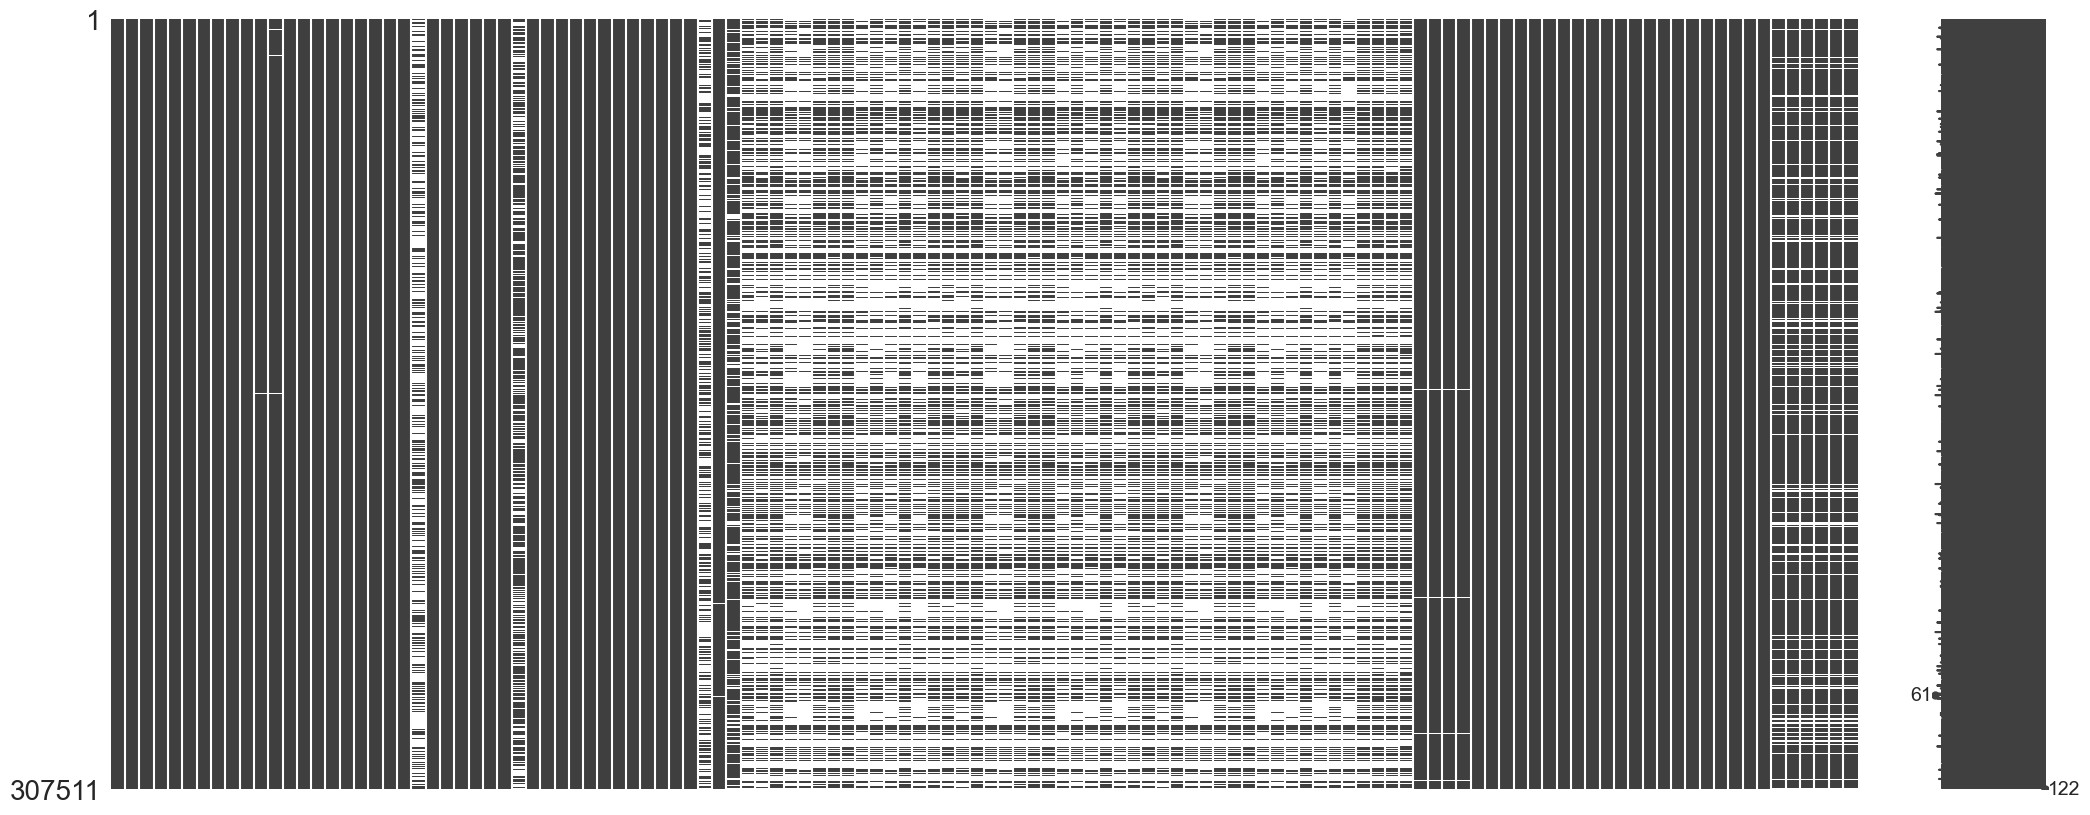

<IPython.core.display.Javascript object>

In [14]:
msno.matrix(application_train)

<Axes: >

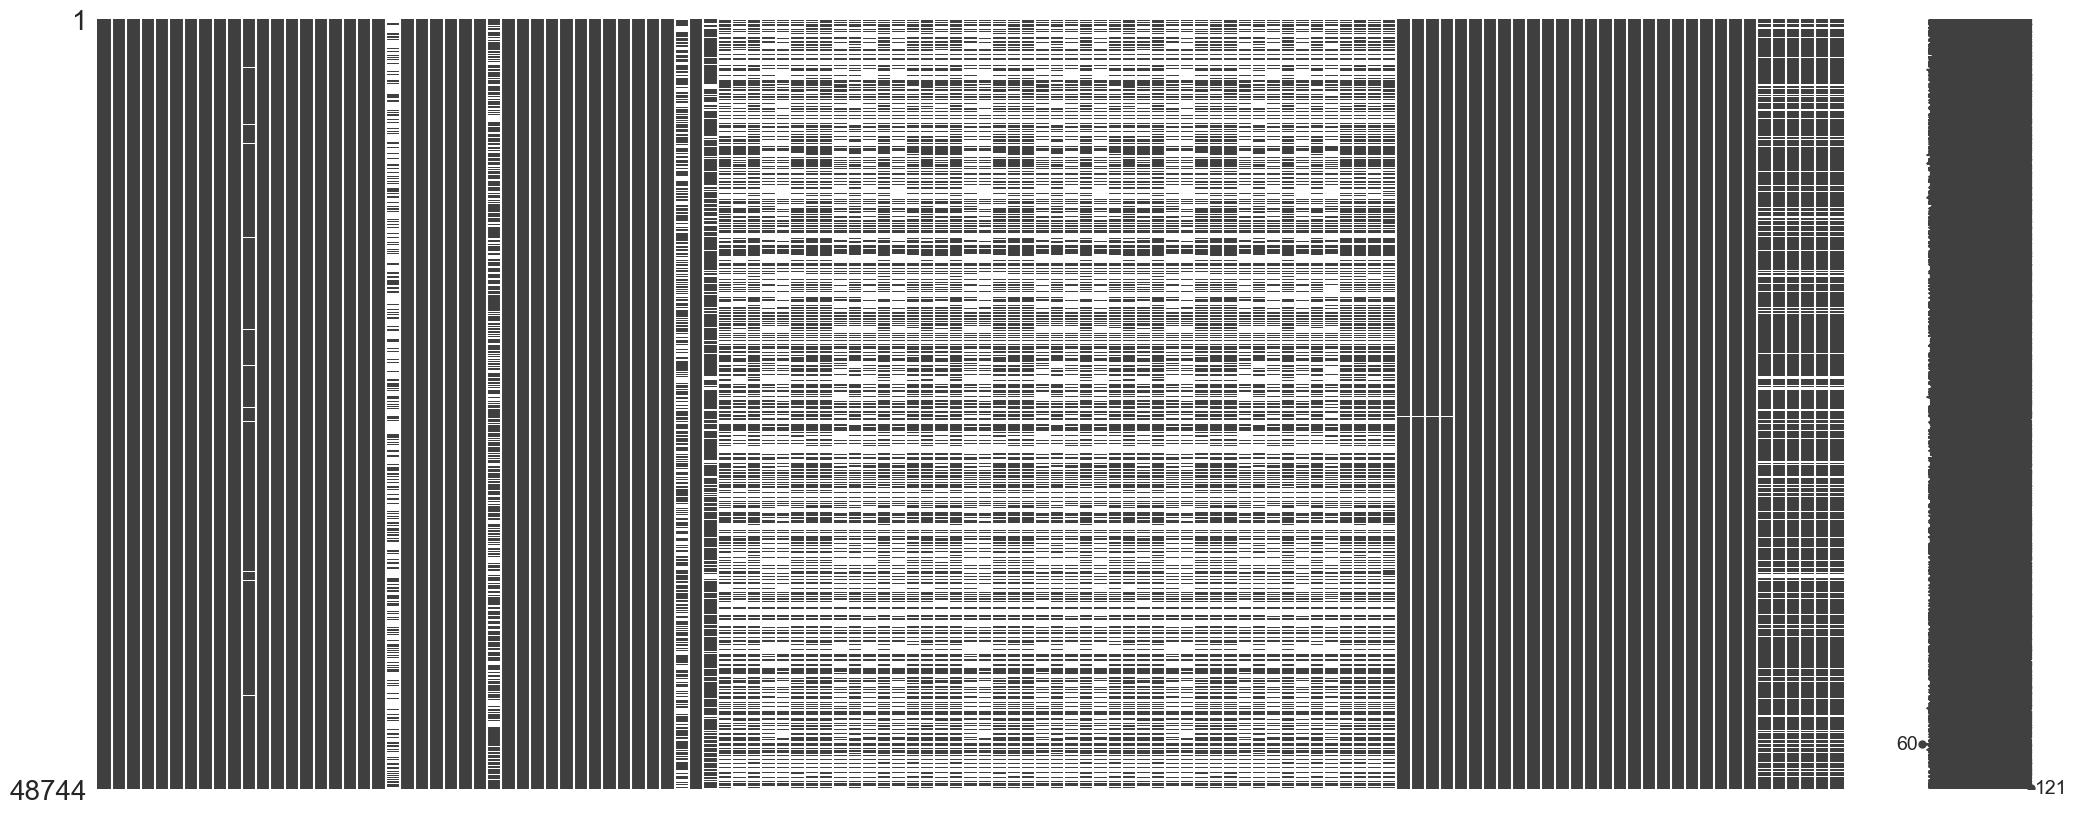

<IPython.core.display.Javascript object>

In [15]:
msno.matrix(application_test)

Let's look into the columns with large percentage of missing values:

In [16]:
missing_percentage_app_train = (application_train.isna().sum() / len(application_train))
missing_cols_application_train = missing_percentage_app_train[missing_percentage_app_train > 0.4].index
missing_cols_application_train

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FO

<IPython.core.display.Javascript object>

In [17]:
for col in missing_cols_application_train:
    print(col, ":")
    print(home_credit_cols_description[home_credit_cols_description.Row == col]['Description'].values[0])
    print("-"*20)

OWN_CAR_AGE :
Age of client's car
--------------------
EXT_SOURCE_1 :
Normalized score from external data source
--------------------
APARTMENTS_AVG :
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
--------------------
BASEMENTAREA_AVG :
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
--------------------
YEARS_BEGINEXPLUATATION_AVG :
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number o

<IPython.core.display.Javascript object>

It looks like the majority of missing data is for features with housing data, and also car age data, and external source score data. Let's find out whether there are some patterns in missing data:

In [18]:
application_train.groupby(["FLAG_OWN_CAR"]).apply(lambda x: x.isna().mean())

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
FLAG_OWN_CAR                                                        
N                    0.0     0.0                 0.0          0.0   
Y                    0.0     0.0                 0.0          0.0   

              FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
FLAG_OWN_CAR                                                                  
N                      0.0              0.0           0.0               0.0   
Y                      0.0              0.0           0.0               0.0   

              AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
FLAG_OWN_CAR                                                              
N                    0.0     0.000044          0.00137         0.004327   
Y                    0.0     0.000029          0.00000         0.003958   

              NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
FLAG_OWN_CAR                                                              
N                          0.0                  0.0                 0.0   
Y                          0.0                  0.0                 0.0   

              NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
FLAG_OWN_CAR                                                              
N                           0.0                         0.0         0.0   
Y                           0.0                         0.0         0.0   

              DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
FLAG_OWN_CAR                                                                   
N                       0.0                0.0              0.0     1.000000   
Y                       0.0                0.0              0.0     0.000048   

              FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
FLAG_OWN_CAR                                                                  
N                    0.0             0.0              0.0               0.0   
Y                    0.0             0.0              0.0               0.0   

              FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
FLAG_OWN_CAR                                                             
N                    0.0         0.0         0.354739          0.00001   
Y                    0.0         0.0         0.233356          0.00000   

              REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
FLAG_OWN_CAR                                                      
N                              0.0                          0.0   
Y                              0.0                          0.0   

              WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
FLAG_OWN_CAR                                                        
N                                    0.0                      0.0   
Y                                    0.0                      0.0   

              REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
FLAG_OWN_CAR                                                           
N                                    0.0                         0.0   
Y                                    0.0                         0.0   

              LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
FLAG_OWN_CAR                                                        
N                                     0.0                     0.0   
Y                                     0.0                     0.0   

              REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
FLAG_OWN_CAR                                                    
N                                0.0                      0.0   
Y                                0.0                      0.0   

              ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
FLAG_OWN_CAR                                                                
N                           0.0      0.580168      0.00

<IPython.core.display.Javascript object>

We can see that clients who don't own a car have NaNs in OWN_CAR_AGE column. We will substitute NaNs with -1 in this column for people who don't own a car.

In [19]:
application_train.loc[application_train['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'] = application_train.loc[application_train['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'].replace({np.nan: -1})

<IPython.core.display.Javascript object>

In [20]:
application_test.loc[application_test['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'] = application_test.loc[application_test['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'].replace({np.nan: -1})

<IPython.core.display.Javascript object>

In [21]:
application_train.groupby(["FLAG_OWN_REALTY"]).apply(lambda x: x.isna().mean())

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
FLAG_OWN_REALTY                                                        
N                       0.0     0.0                 0.0          0.0   
Y                       0.0     0.0                 0.0          0.0   

                 FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
FLAG_OWN_REALTY                                                
N                         0.0              0.0           0.0   
Y                         0.0              0.0           0.0   

                 AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
FLAG_OWN_REALTY                                                               
N                             0.0         0.0     0.000096         0.000584   
Y                             0.0         0.0     0.000014         0.001045   

                 NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
FLAG_OWN_REALTY                                                           
N                       0.008769               0.0                  0.0   
Y                       0.002185               0.0                  0.0   

                 NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
FLAG_OWN_REALTY                                          
N                               0.0                0.0   
Y                               0.0                0.0   

                 REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
FLAG_OWN_REALTY                                                          
N                                       0.0         0.0            0.0   
Y                                       0.0         0.0            0.0   

                 DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
FLAG_OWN_REALTY                                                                
N                              0.0              0.0     0.000032         0.0   
Y                              0.0              0.0     0.000009         0.0   

                 FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
FLAG_OWN_REALTY                                                      
N                           0.0              0.0               0.0   
Y                           0.0              0.0               0.0   

                 FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
FLAG_OWN_REALTY                                                             
N                       0.0         0.0         0.283220         0.000000   
Y                       0.0         0.0         0.326808         0.000009   

                 REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
FLAG_OWN_REALTY                                                      
N                                 0.0                          0.0   
Y                                 0.0                          0.0   

                 WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
FLAG_OWN_REALTY                                                        
N                                       0.0                      0.0   
Y                                       0.0                      0.0   

                 REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
FLAG_OWN_REALTY                                                           
N                                       0.0                         0.0   
Y                                       0.0                         0.0   

                 LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
FLAG_OWN_REALTY                                                        
N                                        0.0                     0.0   
Y                                        0.0                     0.0   

                 REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
FLAG_OWN_REALTY                                                    
N                                   0.0                      0.0   
Y                                   0.0         

<IPython.core.display.Javascript object>

In [22]:
application_train.groupby(["NAME_HOUSING_TYPE"]).apply(lambda x: x.isna().mean())

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
NAME_HOUSING_TYPE                                                          
Co-op apartment             0.0     0.0                 0.0          0.0   
House / apartment           0.0     0.0                 0.0          0.0   
Municipal apartment         0.0     0.0                 0.0          0.0   
Office apartment            0.0     0.0                 0.0          0.0   
Rented apartment            0.0     0.0                 0.0          0.0   
With parents                0.0     0.0                 0.0          0.0   

                     FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
NAME_HOUSING_TYPE                                                  
Co-op apartment               0.0              0.0           0.0   
House / apartment             0.0              0.0           0.0   
Municipal apartment           0.0              0.0           0.0   
Office apartment              0.0              0.0           0.0   
Rented apartment              0.0              0.0           0.0   
With parents                  0.0              0.0           0.0   

                     AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
NAME_HOUSING_TYPE                                                
Co-op apartment                   0.0         0.0     0.000000   
House / apartment                 0.0         0.0     0.000037   
Municipal apartment               0.0         0.0     0.000089   
Office apartment                  0.0         0.0     0.000000   
Rented apartment                  0.0         0.0     0.000205   
With parents                      0.0         0.0     0.000000   

                     AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
NAME_HOUSING_TYPE                                                         
Co-op apartment             0.001783         0.008021               0.0   
House / apartment           0.000858         0.004211               0.0   
Municipal apartment         0.001520         0.003219               0.0   
Office apartment            0.000764         0.005350               0.0   
Rented apartment            0.001024         0.003688               0.0   
With parents                0.001213         0.004447               0.0   

                     NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
NAME_HOUSING_TYPE                                              
Co-op apartment                      0.0                 0.0   
House / apartment                    0.0                 0.0   
Municipal apartment                  0.0                 0.0   
Office apartment                     0.0                 0.0   
Rented apartment                     0.0                 0.0   
With parents                         0.0                 0.0   

                     NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
NAME_HOUSING_TYPE                                                    
Co-op apartment                    0.0                         0.0   
House / apartment                  0.0                         0.0   
Municipal apartment                0.0                         0.0   
Office apartment                   0.0                         0.0   
Rented apartment                   0.0                         0.0   
With parents                       0.0                         0.0   

                     DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
NAME_HOUSING_TYPE                                                   
Co-op apartment             0.0            0.0                0.0   
House / apartment           0.0            0.0                0.0   
Municipal apartment         0.0            0.0                0.0   
Office apartment            0.0            0.0                0.0   
Rented apartment            0.0            0.0                0.0   
With parents                0.0            0.0                0.0   

                     DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  \
NAME_HOUSING_TYPE            

<IPython.core.display.Javascript object>

In [23]:
application_train.groupby(["FLAG_OWN_REALTY"]).apply(lambda x: x.isna().mean())

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
FLAG_OWN_REALTY                                                        
N                       0.0     0.0                 0.0          0.0   
Y                       0.0     0.0                 0.0          0.0   

                 FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
FLAG_OWN_REALTY                                                
N                         0.0              0.0           0.0   
Y                         0.0              0.0           0.0   

                 AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
FLAG_OWN_REALTY                                                               
N                             0.0         0.0     0.000096         0.000584   
Y                             0.0         0.0     0.000014         0.001045   

                 NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
FLAG_OWN_REALTY                                                           
N                       0.008769               0.0                  0.0   
Y                       0.002185               0.0                  0.0   

                 NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
FLAG_OWN_REALTY                                          
N                               0.0                0.0   
Y                               0.0                0.0   

                 REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
FLAG_OWN_REALTY                                                          
N                                       0.0         0.0            0.0   
Y                                       0.0         0.0            0.0   

                 DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
FLAG_OWN_REALTY                                                                
N                              0.0              0.0     0.000032         0.0   
Y                              0.0              0.0     0.000009         0.0   

                 FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
FLAG_OWN_REALTY                                                      
N                           0.0              0.0               0.0   
Y                           0.0              0.0               0.0   

                 FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
FLAG_OWN_REALTY                                                             
N                       0.0         0.0         0.283220         0.000000   
Y                       0.0         0.0         0.326808         0.000009   

                 REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
FLAG_OWN_REALTY                                                      
N                                 0.0                          0.0   
Y                                 0.0                          0.0   

                 WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
FLAG_OWN_REALTY                                                        
N                                       0.0                      0.0   
Y                                       0.0                      0.0   

                 REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
FLAG_OWN_REALTY                                                           
N                                       0.0                         0.0   
Y                                       0.0                         0.0   

                 LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
FLAG_OWN_REALTY                                                        
N                                        0.0                     0.0   
Y                                        0.0                     0.0   

                 REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
FLAG_OWN_REALTY                                                    
N                                   0.0                      0.0   
Y                                   0.0         

<IPython.core.display.Javascript object>

In [24]:
application_train.groupby(["REGION_RATING_CLIENT"]).apply(lambda x: x.isna().mean())

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
REGION_RATING_CLIENT                                                        
1                            0.0     0.0                 0.0          0.0   
2                            0.0     0.0                 0.0          0.0   
3                            0.0     0.0                 0.0          0.0   

                      FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
REGION_RATING_CLIENT                                                
1                              0.0              0.0           0.0   
2                              0.0              0.0           0.0   
3                              0.0              0.0           0.0   

                      AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
REGION_RATING_CLIENT                                              
1                                  0.0         0.0     0.000124   
2                                  0.0         0.0     0.000035   
3                                  0.0         0.0     0.000000   

                      AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
REGION_RATING_CLIENT                                                       
1                            0.000528         0.004535               0.0   
2                            0.000978         0.004317               0.0   
3                            0.000807         0.003435               0.0   

                      NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
REGION_RATING_CLIENT                                            
1                                     0.0                 0.0   
2                                     0.0                 0.0   
3                                     0.0                 0.0   

                      NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
REGION_RATING_CLIENT                                                  
1                                   0.0                         0.0   
2                                   0.0                         0.0   
3                                   0.0                         0.0   

                      DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
REGION_RATING_CLIENT                                                 
1                            0.0            0.0                0.0   
2                            0.0            0.0                0.0   
3                            0.0            0.0                0.0   

                      DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
REGION_RATING_CLIENT                                             
1                                 0.0     0.000000         0.0   
2                                 0.0     0.000018         0.0   
3                                 0.0     0.000021         0.0   

                      FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
REGION_RATING_CLIENT                                                      
1                                0.0              0.0               0.0   
2                                0.0              0.0               0.0   
3                                0.0              0.0               0.0   

                      FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE  \
REGION_RATING_CLIENT                                            
1                            0.0         0.0         0.305184   
2                            0.0         0.0         0.313088   
3                            0.0         0.0         0.320691   

                      CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
REGION_RATING_CLIENT                                          
1                            0.000000                   0.0   
2                            0.000009                   0.0   
3                            0.000000                   0.0   

                      REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
REGION_RATING_CLIENT                                                            
1                            

<IPython.core.display.Javascript object>

In [25]:
application_train.groupby(["TARGET"]).apply(lambda x: x.isna().mean())

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
TARGET                                                                      
0              0.0     0.0                 0.0          0.0           0.0   
1              0.0     0.0                 0.0          0.0           0.0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
TARGET                                                                
0                   0.0           0.0               0.0         0.0   
1                   0.0           0.0               0.0         0.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
TARGET                                                                    
0          0.000042         0.000909         0.004323               0.0   
1          0.000000         0.000846         0.002820               0.0   

        NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
TARGET                                                               
0                       0.0                 0.0                0.0   
1                       0.0                 0.0                0.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
TARGET                                                          
0                              0.0         0.0            0.0   
1                              0.0         0.0            0.0   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
TARGET                                                                
0                     0.0              0.0     0.000018         0.0   
1                     0.0              0.0     0.000000         0.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
TARGET                                                                  
0                  0.0              0.0               0.0         0.0   
1                  0.0              0.0               0.0         0.0   

        FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
TARGET                                                                       
0              0.0         0.318774         0.000007                   0.0   
1              0.0         0.252890         0.000000                   0.0   

        REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
TARGET                                                            
0                               0.0                         0.0   
1                               0.0                         0.0   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
TARGET                                                        
0                           0.0                         0.0   
1                           0.0                         0.0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
TARGET                                                            
0                              0.0                          0.0   
1                              0.0                          0.0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
TARGET                                                   
0                          0.0                     0.0   
1                          0.0                     0.0   

        LIVE_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE  EXT_SOURCE_1  \
TARGET                                                             
0                           0.0                0.0      0.561071   
1                           0.0                0.0      0.595005   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
TARGET                                                                 
0           0.002151      0.195581        0.501532          0.579813   
1           0.002095      0.228681        0.575428          0.646042   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
TARGET                

<IPython.core.display.Javascript object>

We cannot observe any clear patterns in missing data distribution, so we may assume that the features with lots of NaNs contain optional data, or this data is hard to obtain. We will separate data into two dataframes: one with all the rows with missing rows dropped and all features in place; and the second one with dropped columns with a high share of NaNs, and then with dropped rows with missing values (which will be the main dataframe for our further analysis and modeling). 

In [26]:
application_train_all_feats_dropna = application_train.dropna()
application_test_all_feats_dropna = application_test.dropna()

print("application_train_all_feats_dropna.shape:", application_train_all_feats_dropna.shape)
print("application_test_all_feats_dropna.shape:", application_test_all_feats_dropna.shape)

application_train_all_feats_dropna.shape: (22371, 122)
application_test_all_feats_dropna.shape: (4733, 121)


<IPython.core.display.Javascript object>

In [27]:
new_missing_percentage_app_train = (application_train.isna().sum() / len(application_train))
new_missing_cols_application_train = new_missing_percentage_app_train[new_missing_percentage_app_train > 0.4].index
new_missing_cols_application_train

Index(['EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MOD

<IPython.core.display.Javascript object>

In [28]:
missing_percentage_app_test = (application_test.isna().sum() / len(application_test))
missing_cols_application_test = missing_percentage_app_test[missing_percentage_app_test > 0.4].index
missing_cols_application_test

Index(['EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MOD

<IPython.core.display.Javascript object>

In [29]:
short_application_train = application_train.drop(columns=new_missing_cols_application_train)
short_application_test = application_test.drop(columns=new_missing_cols_application_train)

<IPython.core.display.Javascript object>

<Axes: >

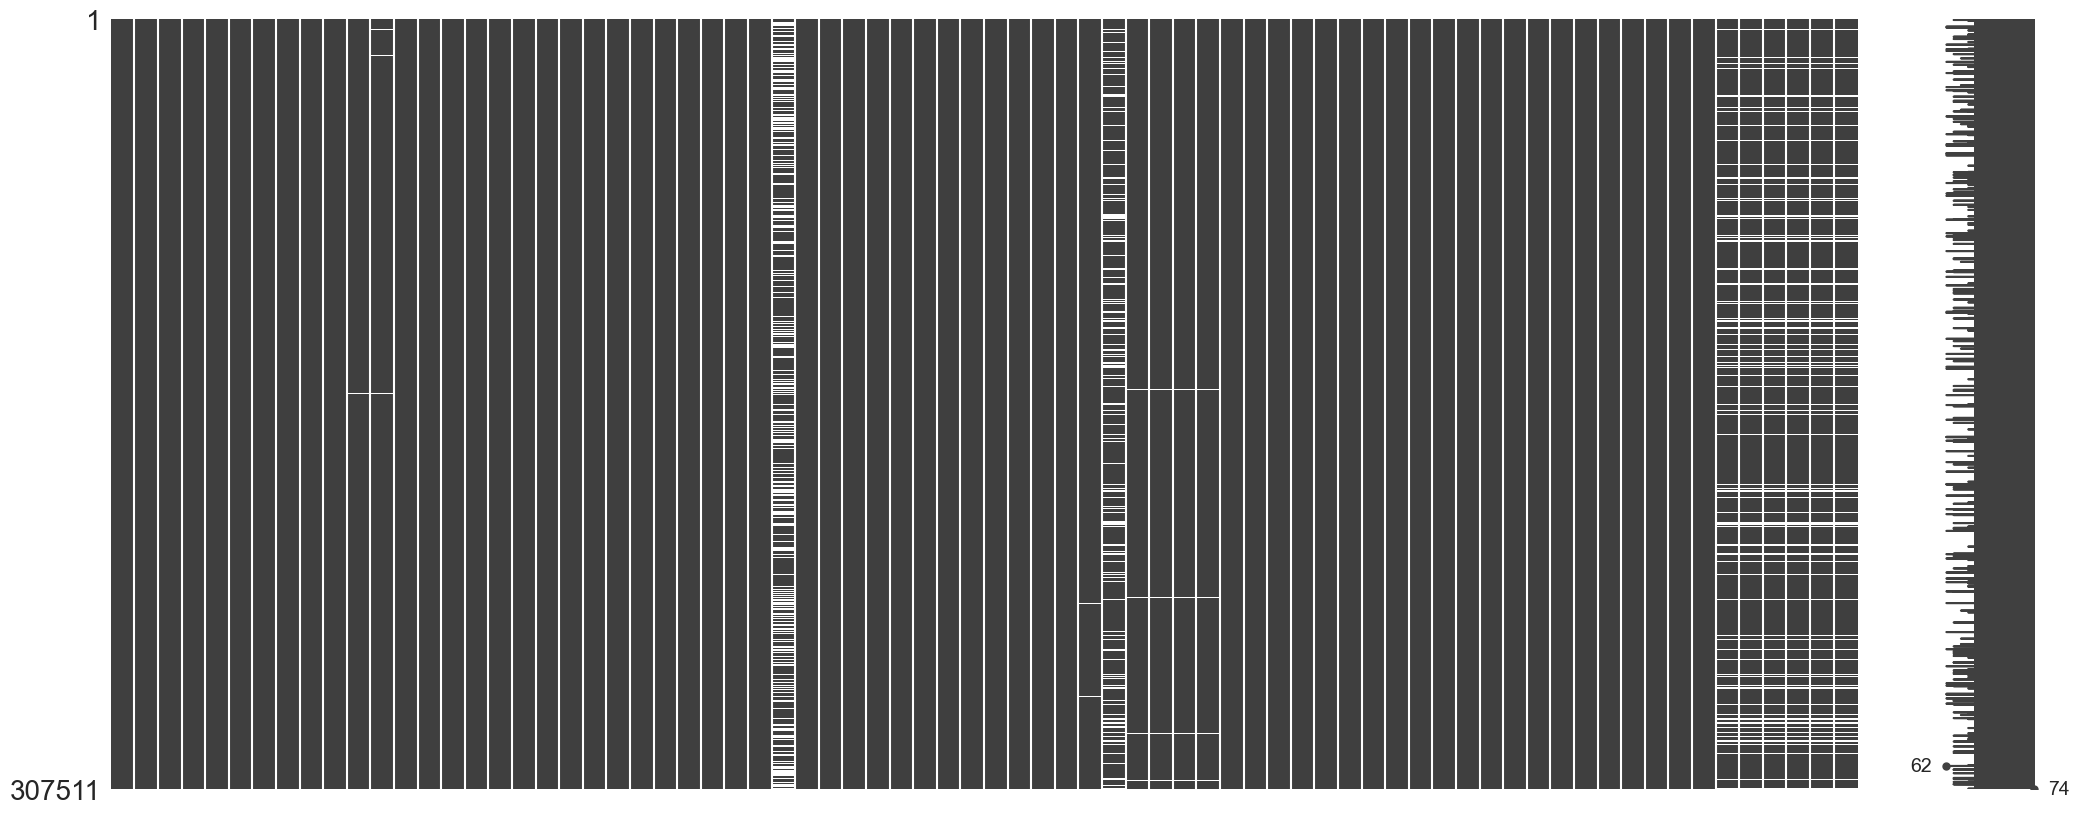

<IPython.core.display.Javascript object>

In [30]:
msno.matrix(short_application_train)

In [31]:
missing_percentage_app_train_short = (short_application_train.isna().sum() / len(short_application_train))
missing_cols_application_train_short = missing_percentage_app_train_short[missing_percentage_app_train_short > 0].index
missing_cols_application_train_short

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

<IPython.core.display.Javascript object>

In [32]:
cat_cols_app = short_application_test.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols_app = short_application_test.select_dtypes(exclude=['object', 'category']).columns.tolist()

<IPython.core.display.Javascript object>

In [33]:
short_application_train[cat_cols_app] = short_application_train[cat_cols_app].fillna('Not specified')
short_application_test[cat_cols_app] = short_application_test[cat_cols_app].fillna('Not specified')

<IPython.core.display.Javascript object>

### 1.1.2. bureau and bureau_balance dataframes

<Axes: >

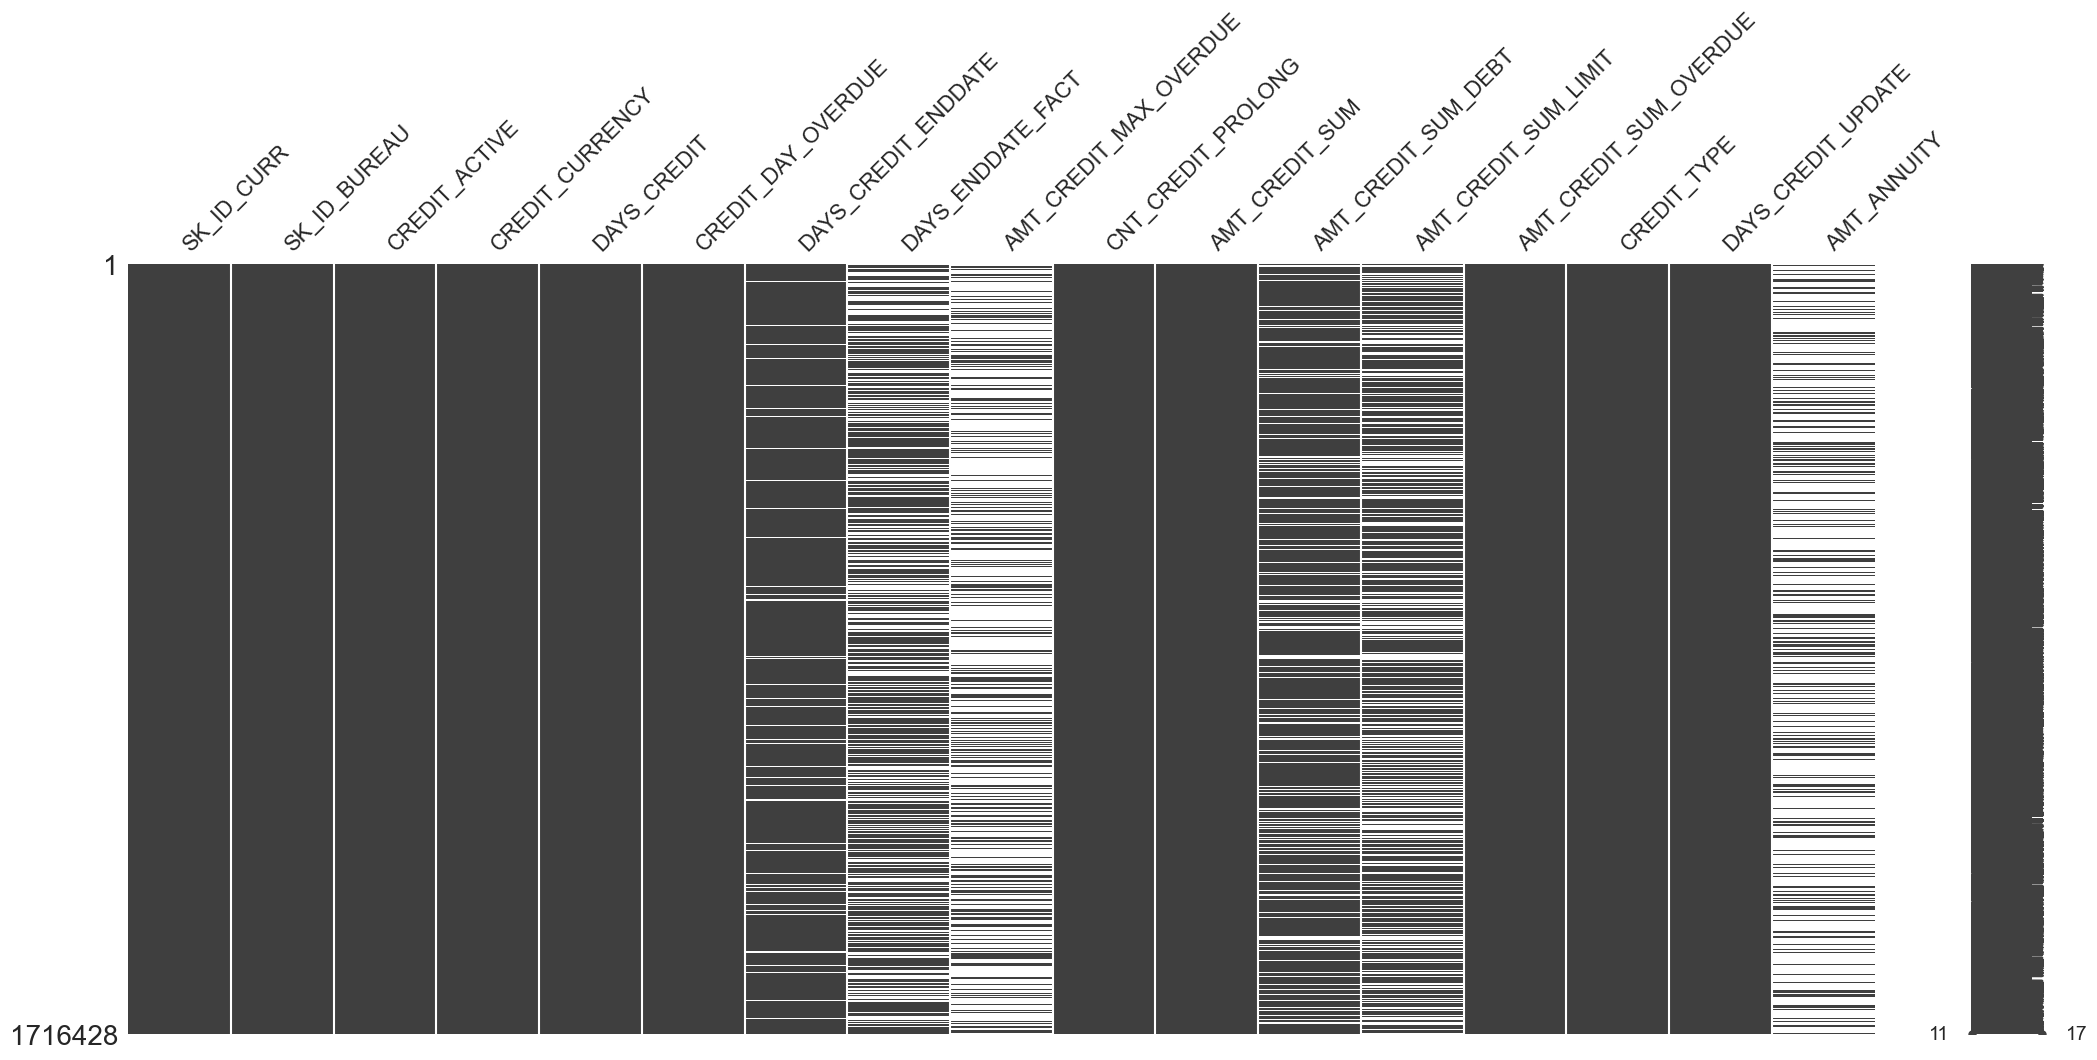

<IPython.core.display.Javascript object>

In [34]:
msno.matrix(bureau)

In [35]:
missing_percentage_bureau= (bureau.isna().sum() / len(bureau))
missing_cols_bureau = missing_percentage_bureau[missing_percentage_bureau > 0].index.tolist()
missing_cols_bureau

['DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_ANNUITY']

<IPython.core.display.Javascript object>

In [36]:
bureau.groupby(["CREDIT_TYPE"])[missing_cols_bureau].apply(lambda x: round(x.isna().mean(), 2))

DAYS_CREDIT_ENDDATE  \
CREDIT_TYPE                                                         
Another type of loan                                         0.57   
Car loan                                                     0.01   
Cash loan (non-earmarked)                                    0.00   
Consumer credit                                              0.01   
Credit card                                                  0.21   
Interbank credit                                             0.00   
Loan for business development                                0.06   
Loan for purchase of shares (margin lending)                 0.25   
Loan for the purchase of equipment                           0.00   
Loan for working capital replenishment                       0.09   
Microloan                                                    0.45   
Mobile operator loan                                         0.00   
Mortgage                                                     0.05   
Real estate loan                                             0.41   
Unknown type of loan                                         0.00   

                                              DAYS_ENDDATE_FACT  \
CREDIT_TYPE                                                       
Another type of loan                                       0.20   
Car loan                                                   0.37   
Cash loan (non-earmarked)                                  0.75   
Consumer credit                                            0.26   
Credit card                                                0.71   
Interbank credit                                           0.00   
Loan for business development                              0.18   
Loan for purchase of shares (margin lending)               0.50   
Loan for the purchase of equipment                         0.26   
Loan for working capital replenishment                     0.51   
Microloan                                                  0.25   
Mobile operator loan                                       1.00   
Mortgage                                                   0.73   
Real estate loan                                           0.67   
Unknown type of loan                                       0.21   

                                              AMT_CREDIT_MAX_OVERDUE  \
CREDIT_TYPE                                                            
Another type of loan                                            0.66   
Car loan                                                        0.74   
Cash loan (non-earmarked)                                       0.00   
Consumer credit                                                 0.65   
Credit card                                                     0.65   
Interbank credit                                                1.00   
Loan for business development                                   0.89   
Loan for purchase of shares (margin lending)                    1.00   
Loan for the purchase of equipment                              0.89   
Loan for working capital replenishment                          0.94   
Microloan                                                       0.82   
Mobile operator loan                                            0.00   
Mortgage                                                        0.84   
Real estate loan                                                0.85   
Unknown type of loan                                            0.00   

                                              AMT_CREDIT_SUM  \
CREDIT_TYPE                                                    
Another type of loan                                    0.01   
Car loan                                                0.00   
Cash loan (non-earmarked)                               0.00   
Consumer credit                                         0.00   
Credit card                                             0.00   
Interbank credit                                        0.0

<IPython.core.display.Javascript object>

In [37]:
bureau.groupby(["CREDIT_ACTIVE"])[missing_cols_bureau].apply(lambda x: round(x.isna().mean(), 2))

DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
CREDIT_ACTIVE                                                                   
Active                        0.11               1.00                    0.65   
Bad debt                      0.05               0.52                    0.29   
Closed                        0.03               0.00                    0.66   
Sold                          0.10               0.75                    0.77   

               AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
CREDIT_ACTIVE                                                              
Active                    0.0                 0.12                  0.27   
Bad debt                  0.0                 0.29                  0.43   
Closed                    0.0                 0.17                  0.38   
Sold                      0.0                 0.55                  0.76   

               AMT_ANNUITY  
CREDIT_ACTIVE               
Active                0.68  
Bad debt              0.95  
Closed                0.73  
Sold                  0.70

<IPython.core.display.Javascript object>

There are no visible patterns in missing values in bureau dataframe. We will handle these NaNs later on, if we need these columns for modeling.

<Axes: >

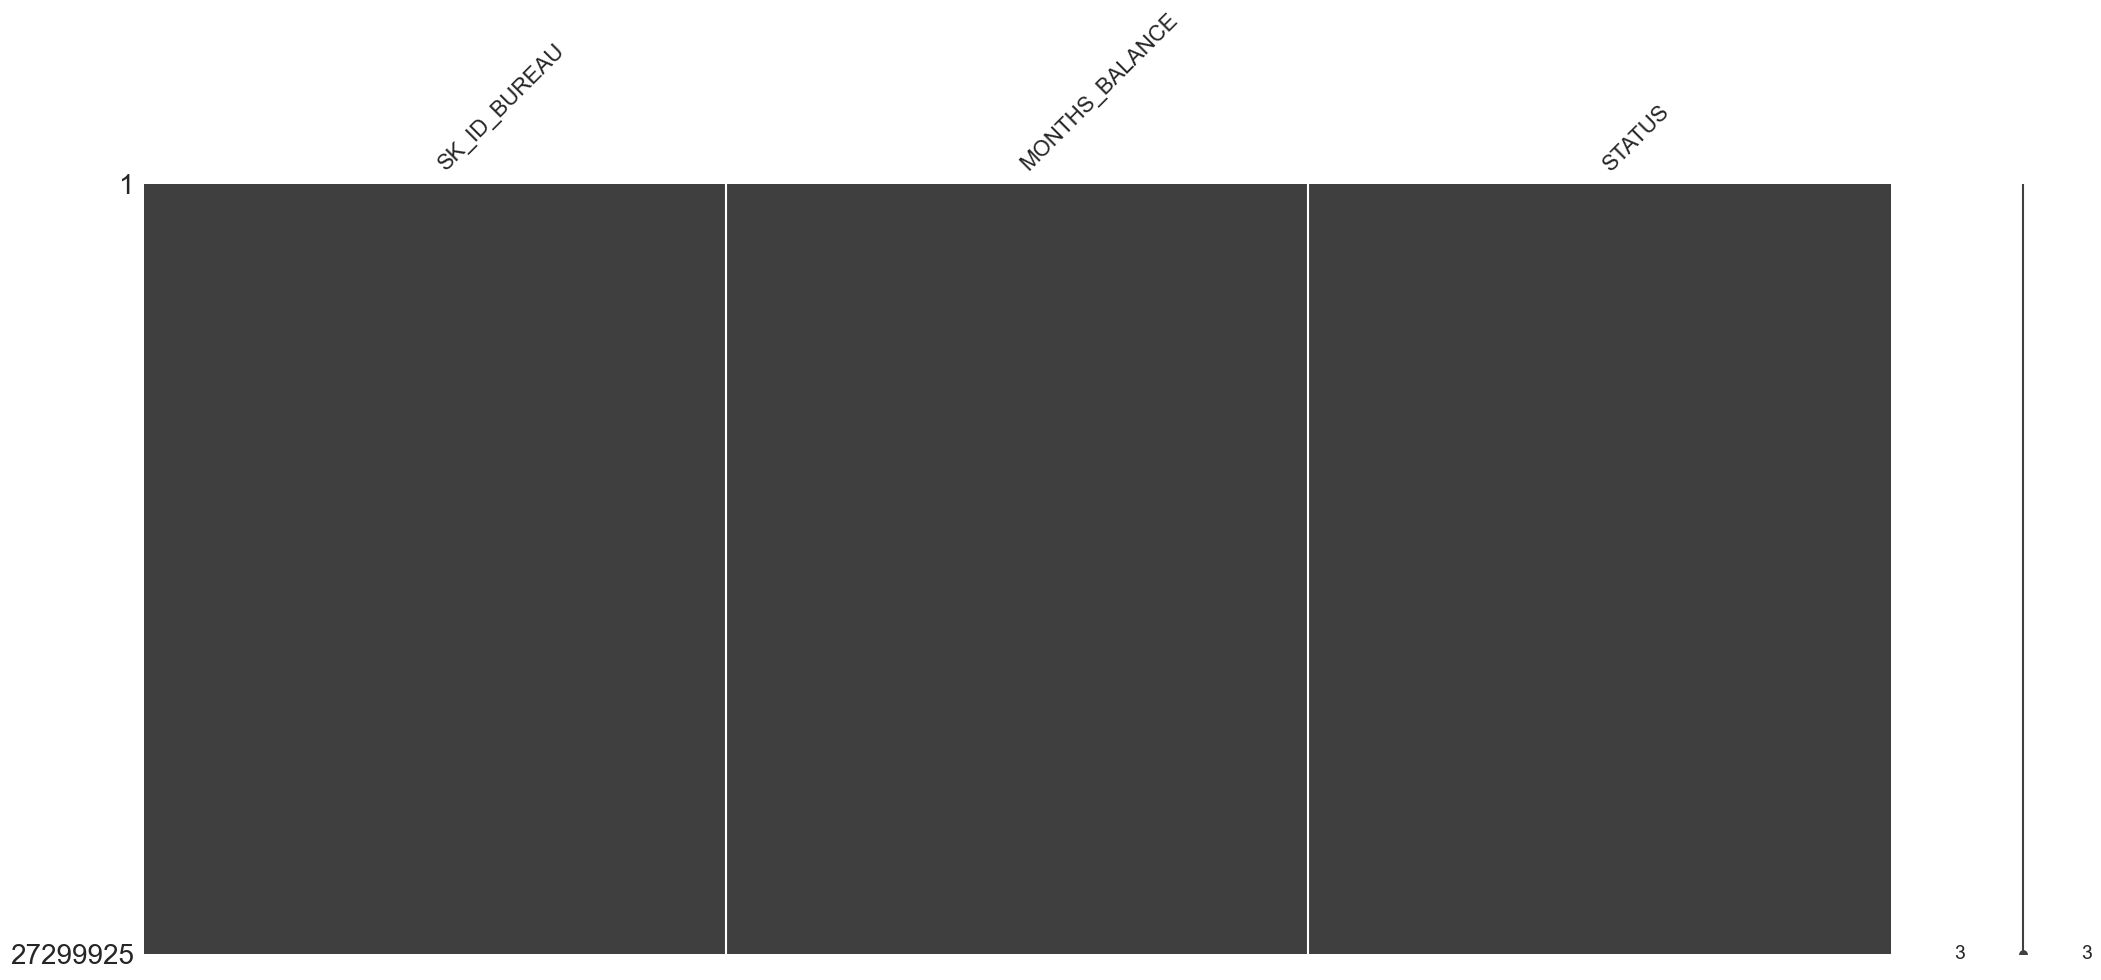

<IPython.core.display.Javascript object>

In [38]:
msno.matrix(bureau_balance)

### 1.1.3. credit_card_balance, previous_application, installments_payments, credit_card_balance, and POS_CASH_balance dataframes

<Axes: >

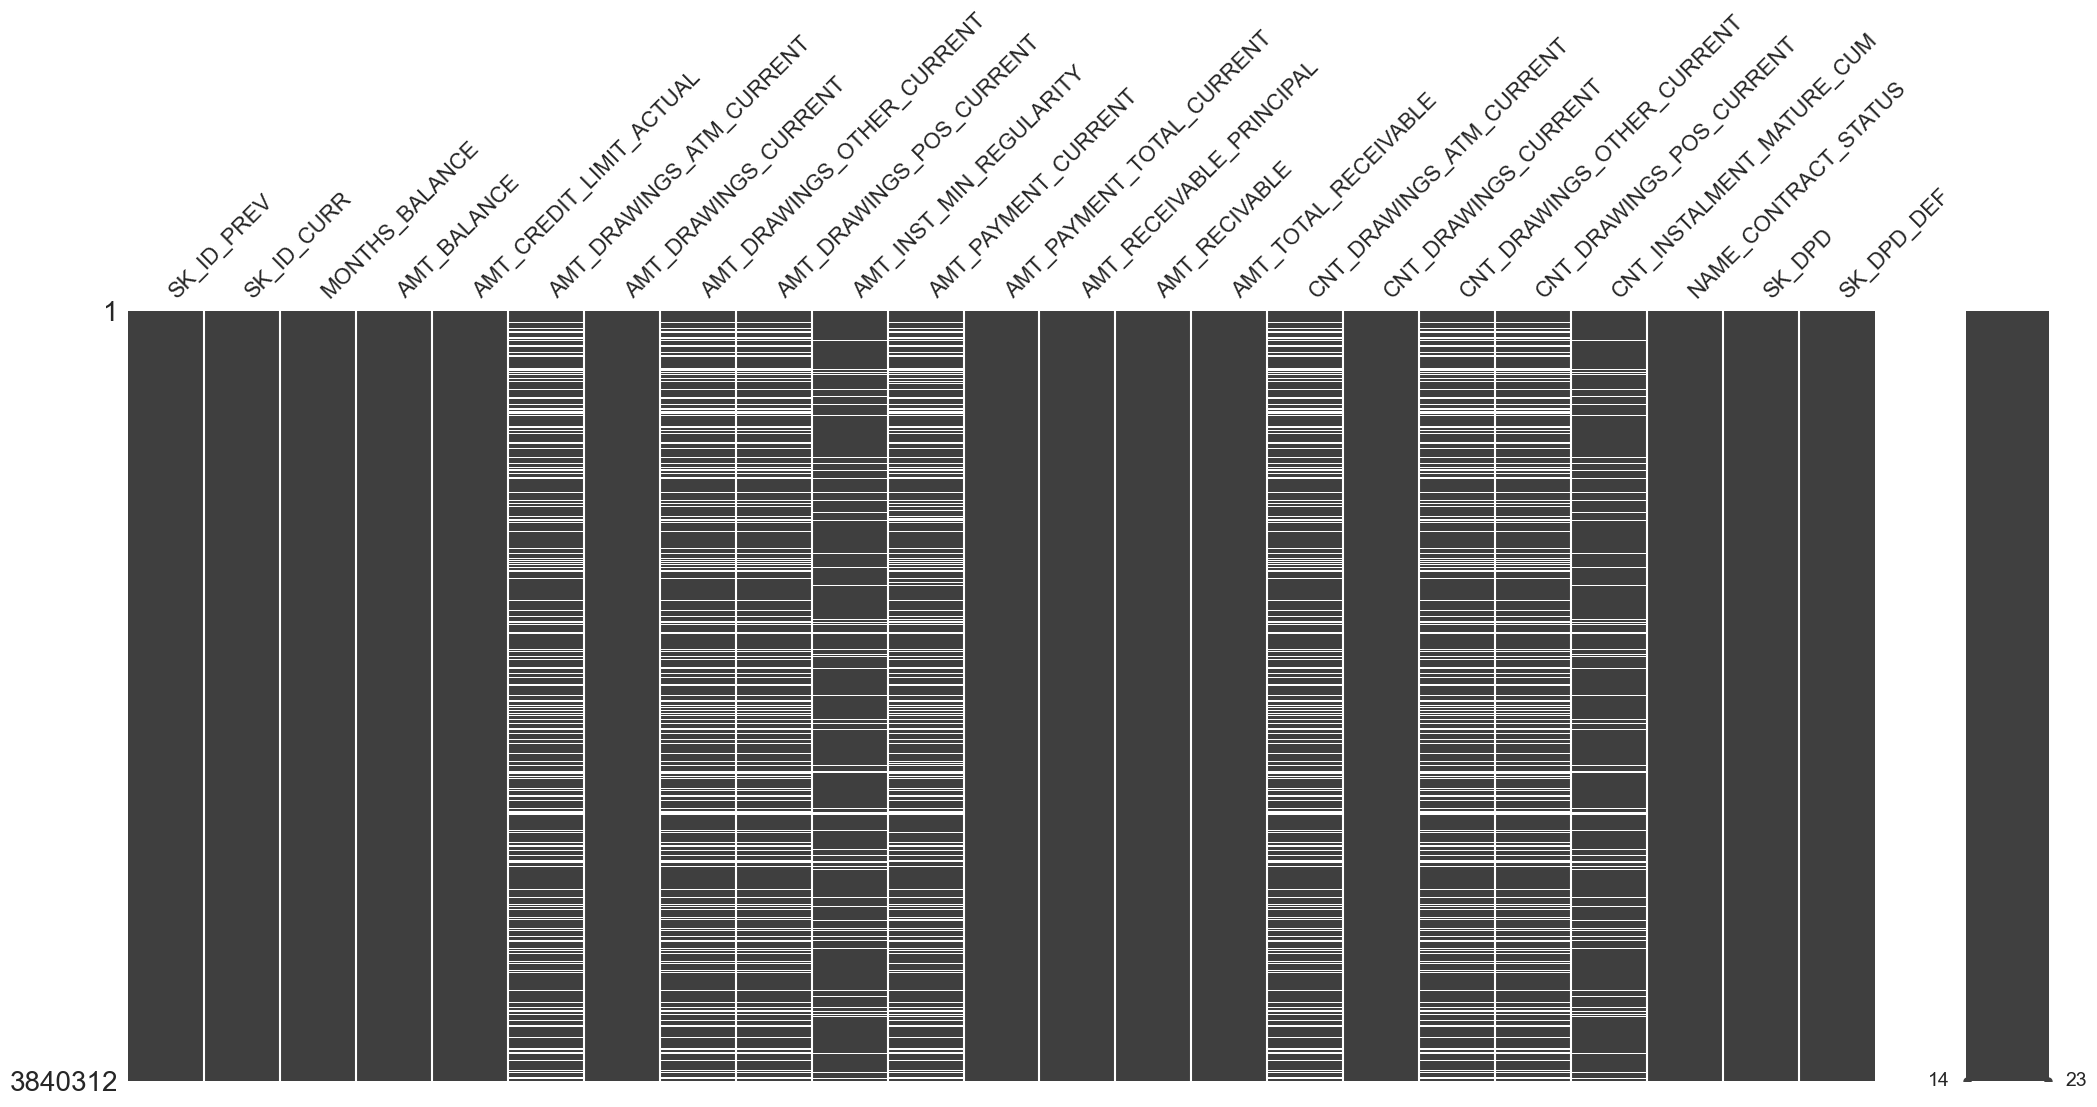

<IPython.core.display.Javascript object>

In [39]:
msno.matrix(credit_card_balance)

In [40]:
round((credit_card_balance.isna().sum().sort_values(ascending=False) / len(credit_card_balance)), 2)

AMT_PAYMENT_CURRENT           0.20
AMT_DRAWINGS_ATM_CURRENT      0.20
CNT_DRAWINGS_POS_CURRENT      0.20
AMT_DRAWINGS_OTHER_CURRENT    0.20
AMT_DRAWINGS_POS_CURRENT      0.20
CNT_DRAWINGS_OTHER_CURRENT    0.20
CNT_DRAWINGS_ATM_CURRENT      0.20
CNT_INSTALMENT_MATURE_CUM     0.08
AMT_INST_MIN_REGULARITY       0.08
SK_ID_PREV                    0.00
AMT_TOTAL_RECEIVABLE          0.00
SK_DPD                        0.00
NAME_CONTRACT_STATUS          0.00
CNT_DRAWINGS_CURRENT          0.00
AMT_PAYMENT_TOTAL_CURRENT     0.00
AMT_RECIVABLE                 0.00
AMT_RECEIVABLE_PRINCIPAL      0.00
SK_ID_CURR                    0.00
AMT_DRAWINGS_CURRENT          0.00
AMT_CREDIT_LIMIT_ACTUAL       0.00
AMT_BALANCE                   0.00
MONTHS_BALANCE                0.00
SK_DPD_DEF                    0.00
dtype: float64

<IPython.core.display.Javascript object>

<Axes: >

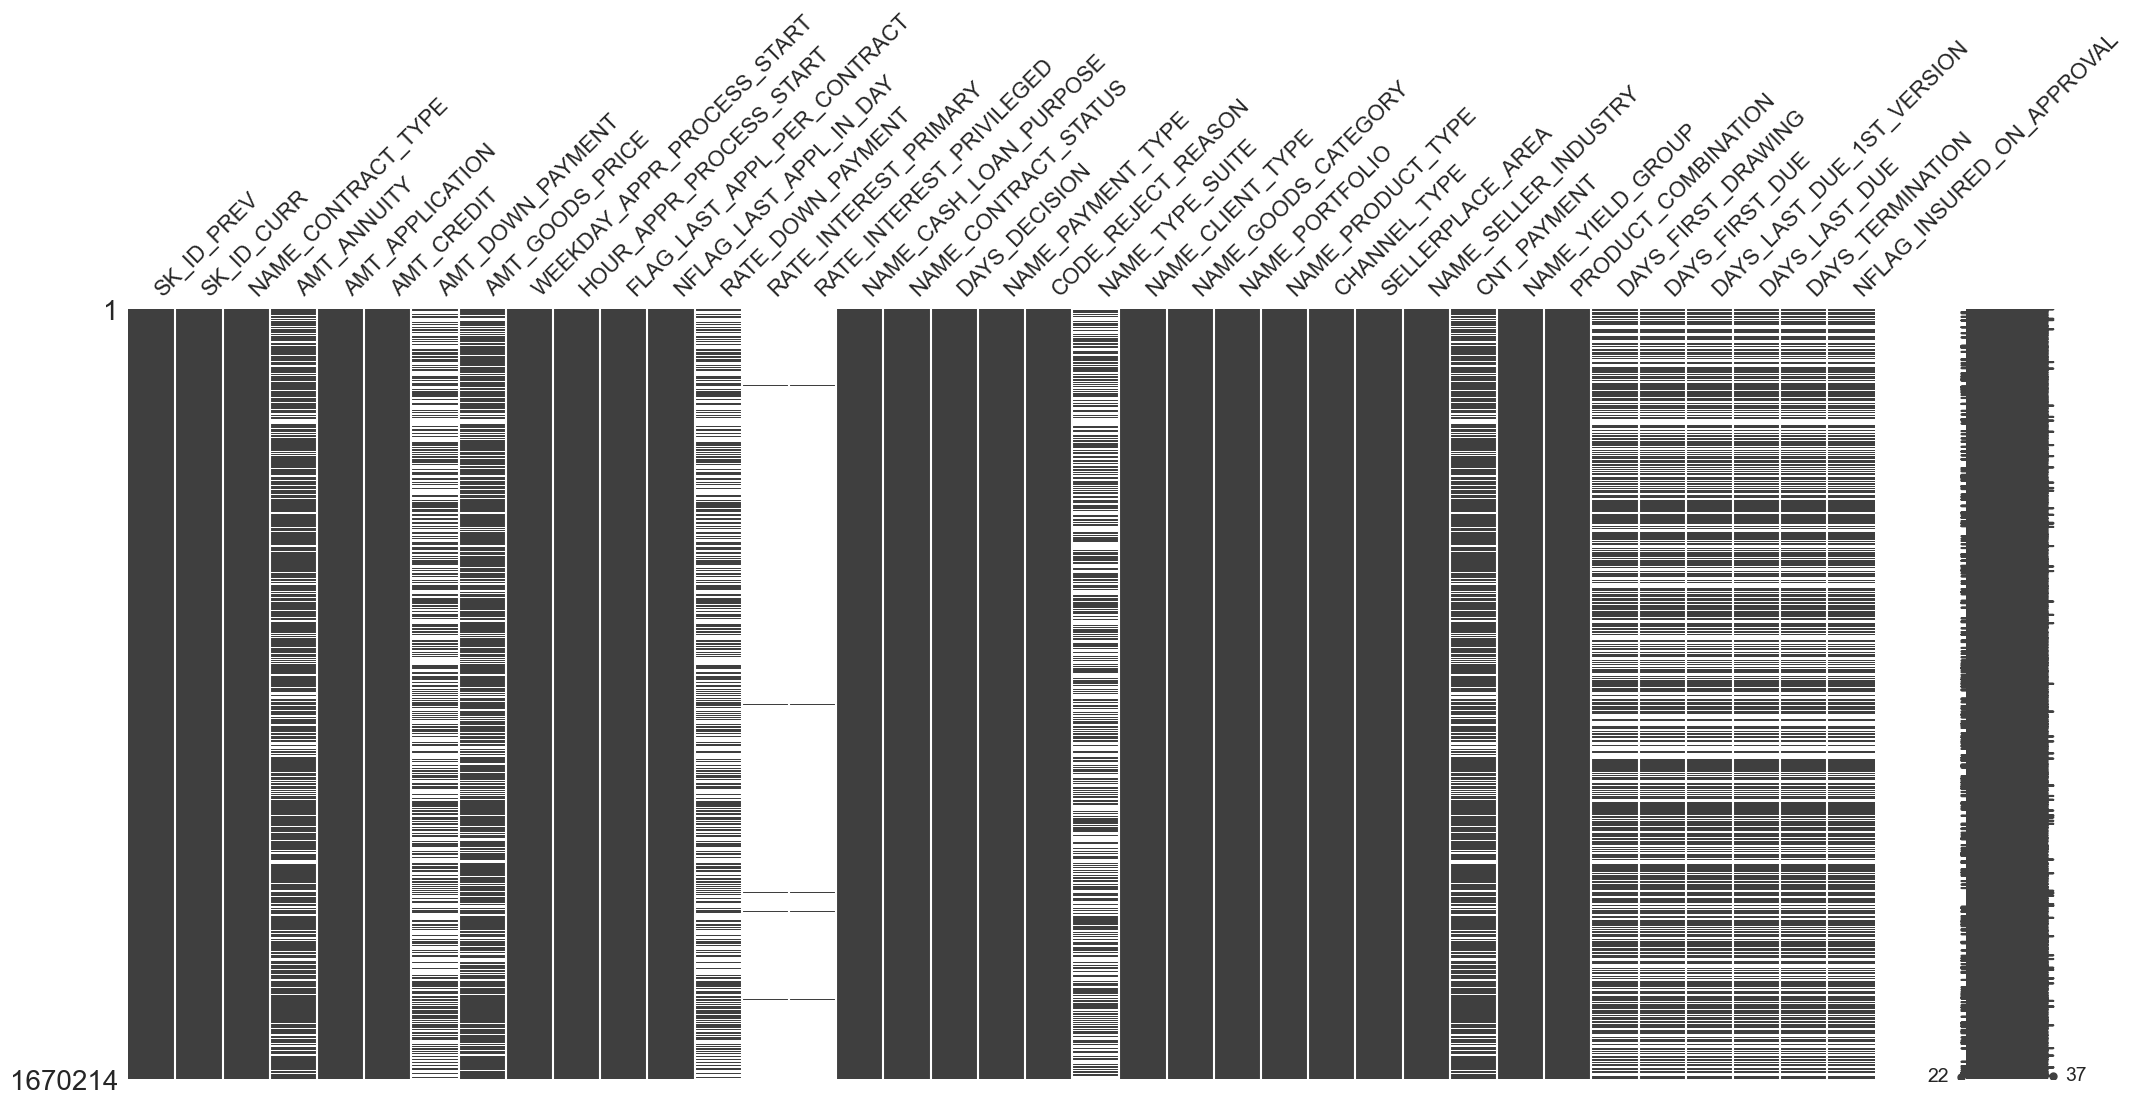

<IPython.core.display.Javascript object>

In [41]:
msno.matrix(previous_application)

In [42]:
round((previous_application.isna().sum().sort_values(ascending=False) / len(previous_application)), 2)

RATE_INTEREST_PRIVILEGED       1.00
RATE_INTEREST_PRIMARY          1.00
AMT_DOWN_PAYMENT               0.54
RATE_DOWN_PAYMENT              0.54
NAME_TYPE_SUITE                0.49
NFLAG_INSURED_ON_APPROVAL      0.40
DAYS_TERMINATION               0.40
DAYS_LAST_DUE                  0.40
DAYS_LAST_DUE_1ST_VERSION      0.40
DAYS_FIRST_DUE                 0.40
DAYS_FIRST_DRAWING             0.40
AMT_GOODS_PRICE                0.23
AMT_ANNUITY                    0.22
CNT_PAYMENT                    0.22
PRODUCT_COMBINATION            0.00
AMT_CREDIT                     0.00
NAME_YIELD_GROUP               0.00
NAME_PORTFOLIO                 0.00
NAME_SELLER_INDUSTRY           0.00
SELLERPLACE_AREA               0.00
CHANNEL_TYPE                   0.00
NAME_PRODUCT_TYPE              0.00
SK_ID_PREV                     0.00
NAME_GOODS_CATEGORY            0.00
NAME_CLIENT_TYPE               0.00
CODE_REJECT_REASON             0.00
SK_ID_CURR                     0.00
DAYS_DECISION               

<IPython.core.display.Javascript object>

We will drop the columns with the higher share of missing values. Regarding other columns with missing values, we will leave them for future imputation on the ML modeling stage.

In [43]:
previous_application = previous_application.drop(columns=['RATE_INTEREST_PRIVILEGED', 
                                                          'RATE_INTEREST_PRIMARY'])

<IPython.core.display.Javascript object>

<Axes: >

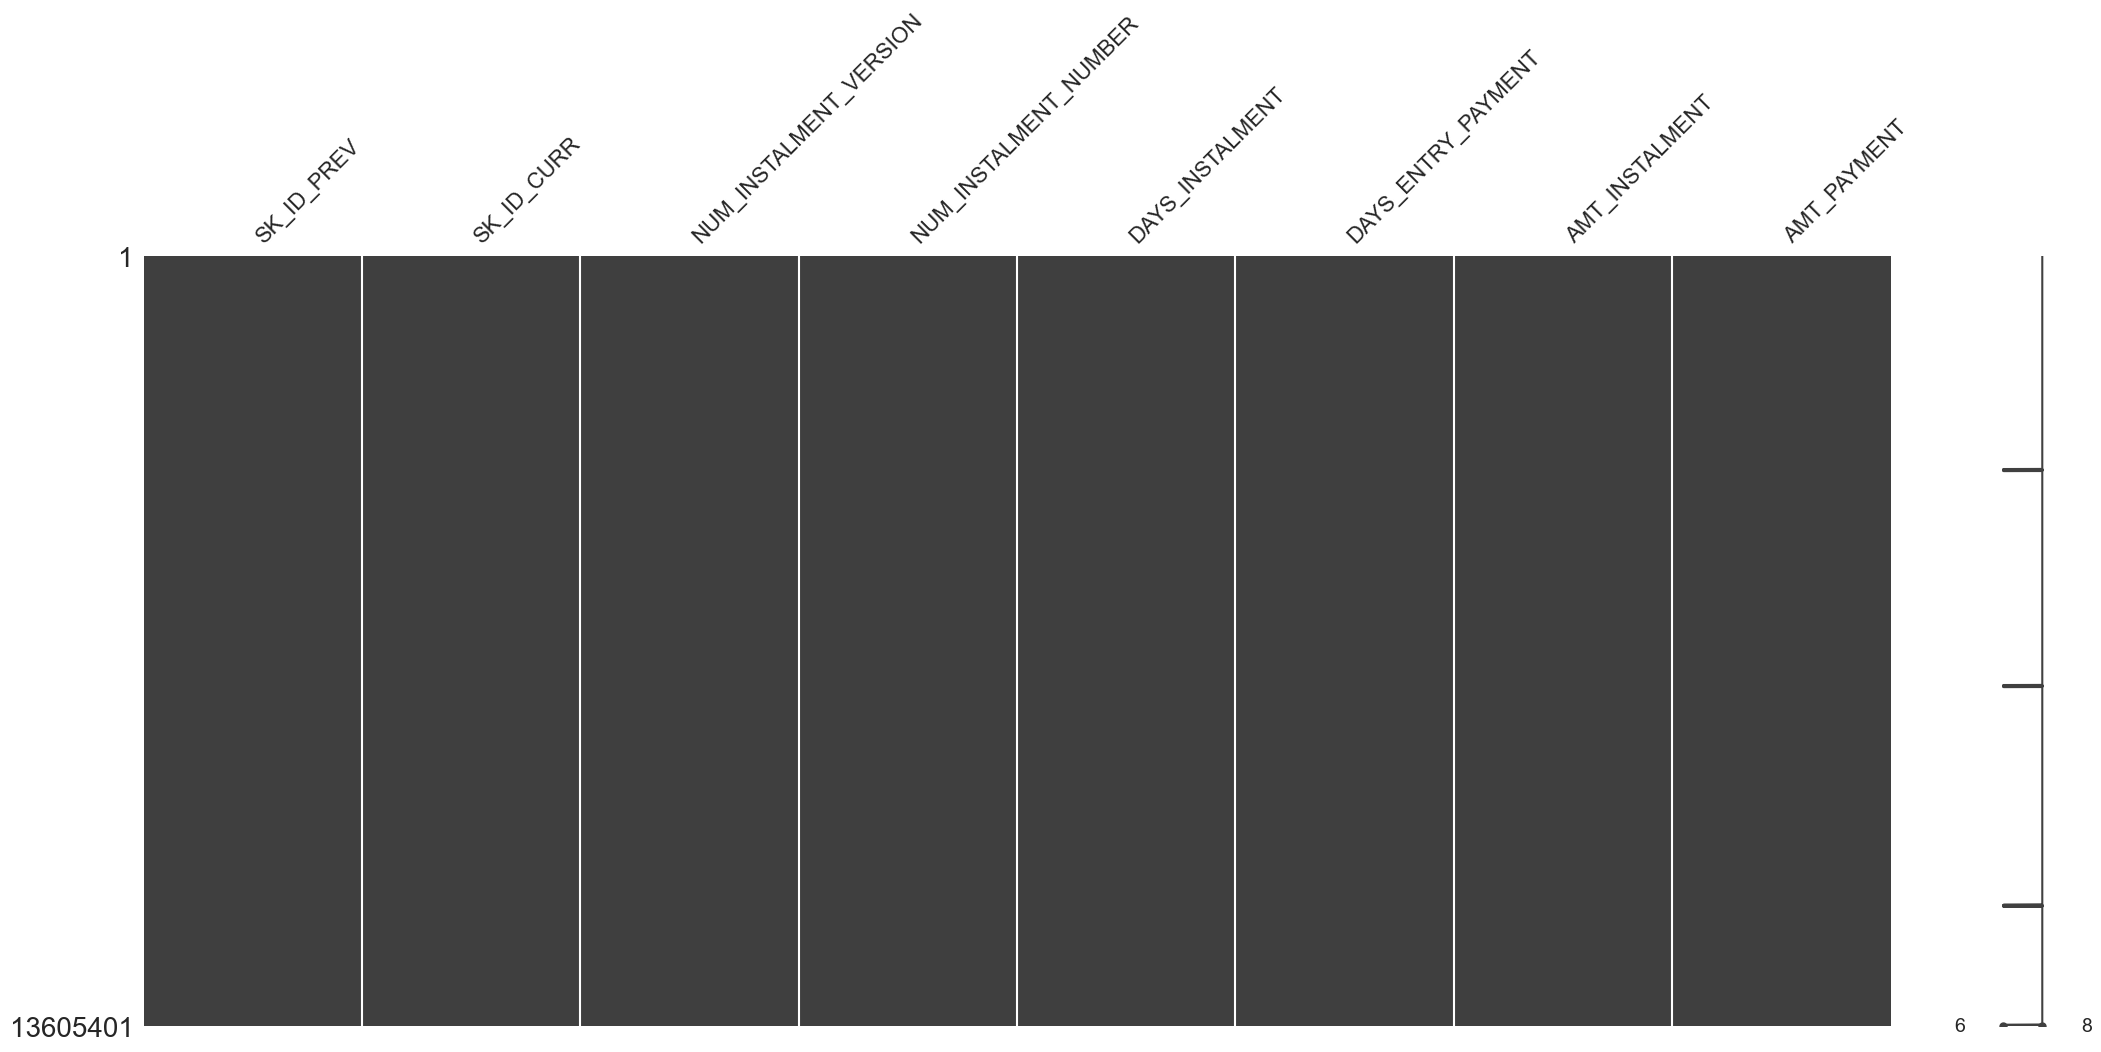

<IPython.core.display.Javascript object>

In [44]:
msno.matrix(installments_payments)

<Axes: >

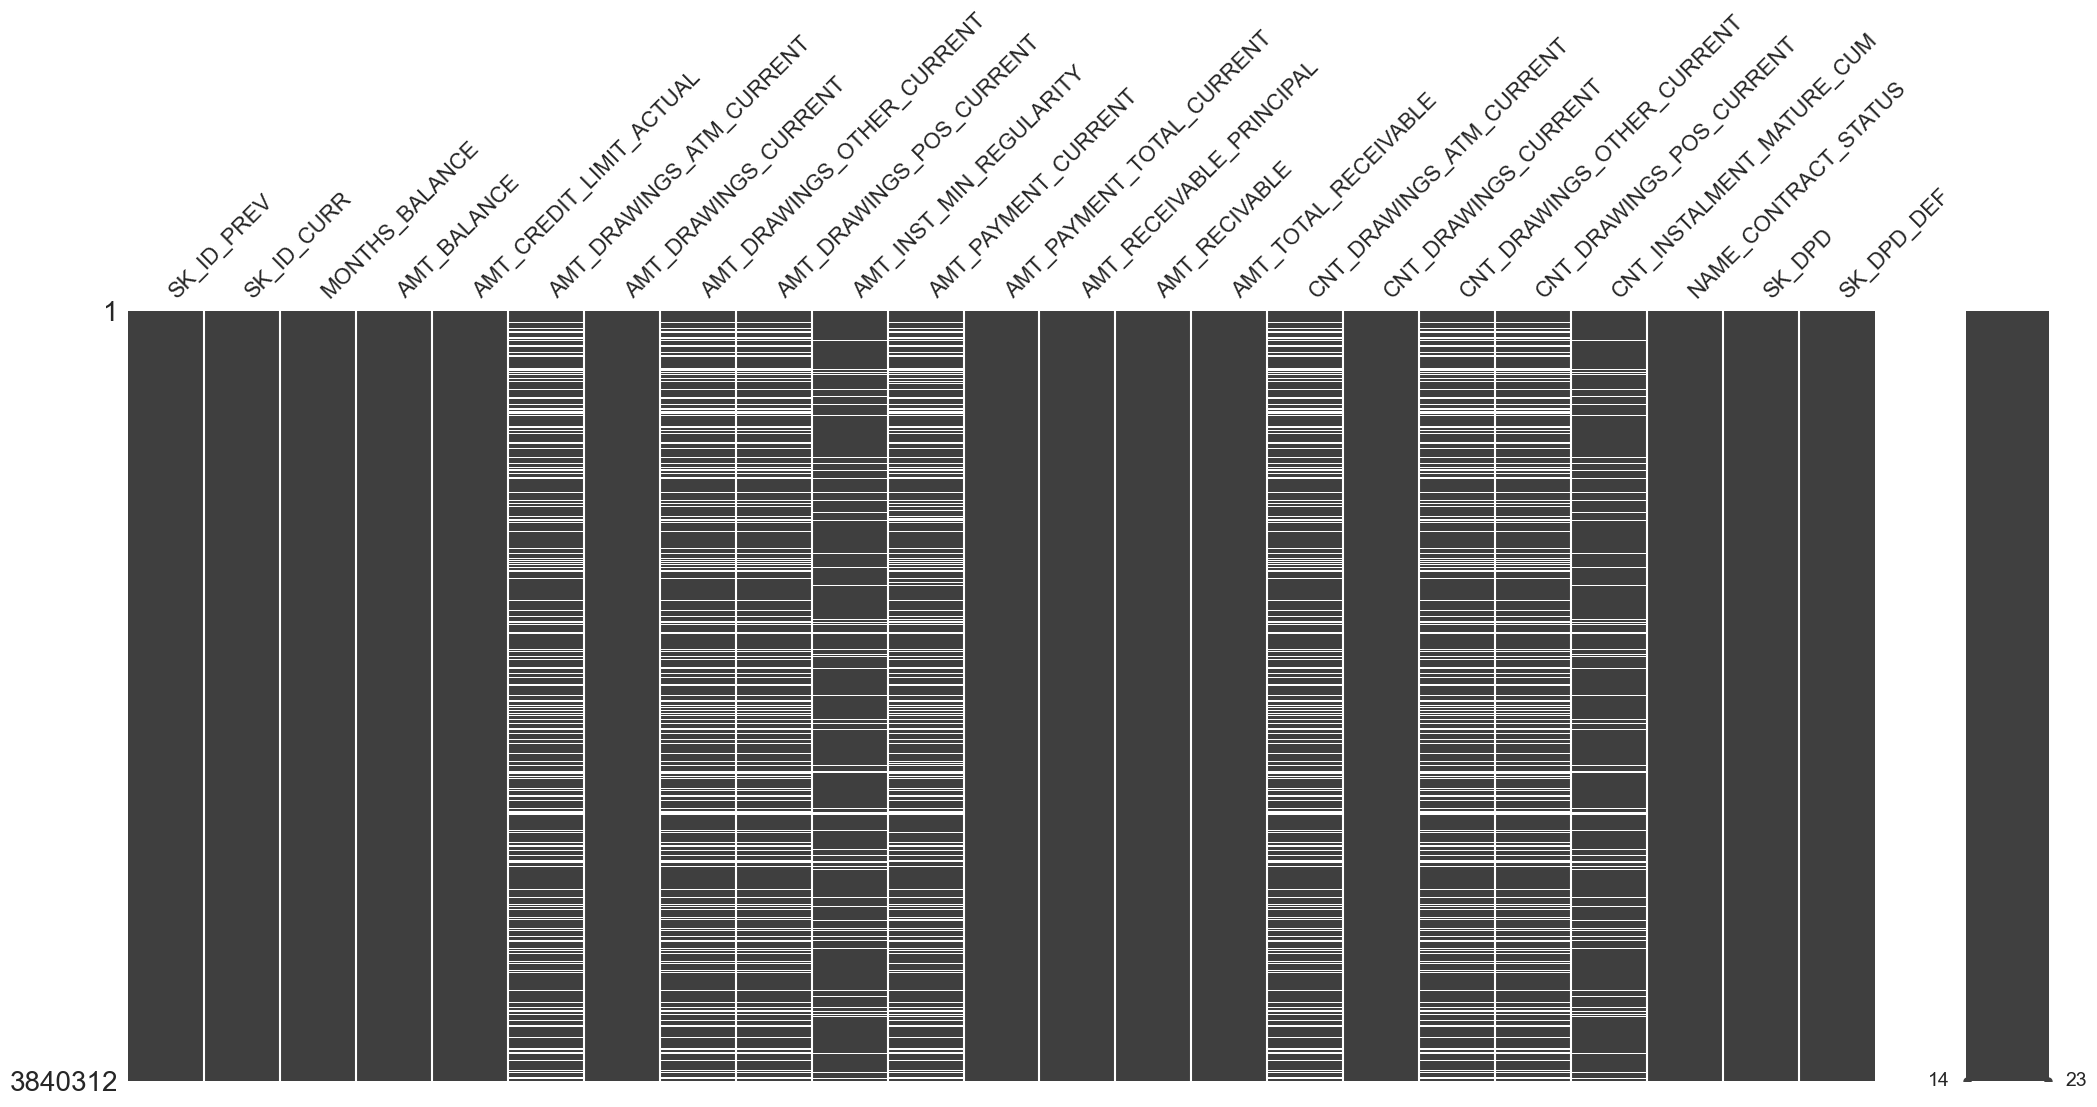

<IPython.core.display.Javascript object>

In [45]:
msno.matrix(credit_card_balance)

In [46]:
round((credit_card_balance.isna().sum().sort_values(ascending=False) / len(credit_card_balance)), 2)

AMT_PAYMENT_CURRENT           0.20
AMT_DRAWINGS_ATM_CURRENT      0.20
CNT_DRAWINGS_POS_CURRENT      0.20
AMT_DRAWINGS_OTHER_CURRENT    0.20
AMT_DRAWINGS_POS_CURRENT      0.20
CNT_DRAWINGS_OTHER_CURRENT    0.20
CNT_DRAWINGS_ATM_CURRENT      0.20
CNT_INSTALMENT_MATURE_CUM     0.08
AMT_INST_MIN_REGULARITY       0.08
SK_ID_PREV                    0.00
AMT_TOTAL_RECEIVABLE          0.00
SK_DPD                        0.00
NAME_CONTRACT_STATUS          0.00
CNT_DRAWINGS_CURRENT          0.00
AMT_PAYMENT_TOTAL_CURRENT     0.00
AMT_RECIVABLE                 0.00
AMT_RECEIVABLE_PRINCIPAL      0.00
SK_ID_CURR                    0.00
AMT_DRAWINGS_CURRENT          0.00
AMT_CREDIT_LIMIT_ACTUAL       0.00
AMT_BALANCE                   0.00
MONTHS_BALANCE                0.00
SK_DPD_DEF                    0.00
dtype: float64

<IPython.core.display.Javascript object>

<Axes: >

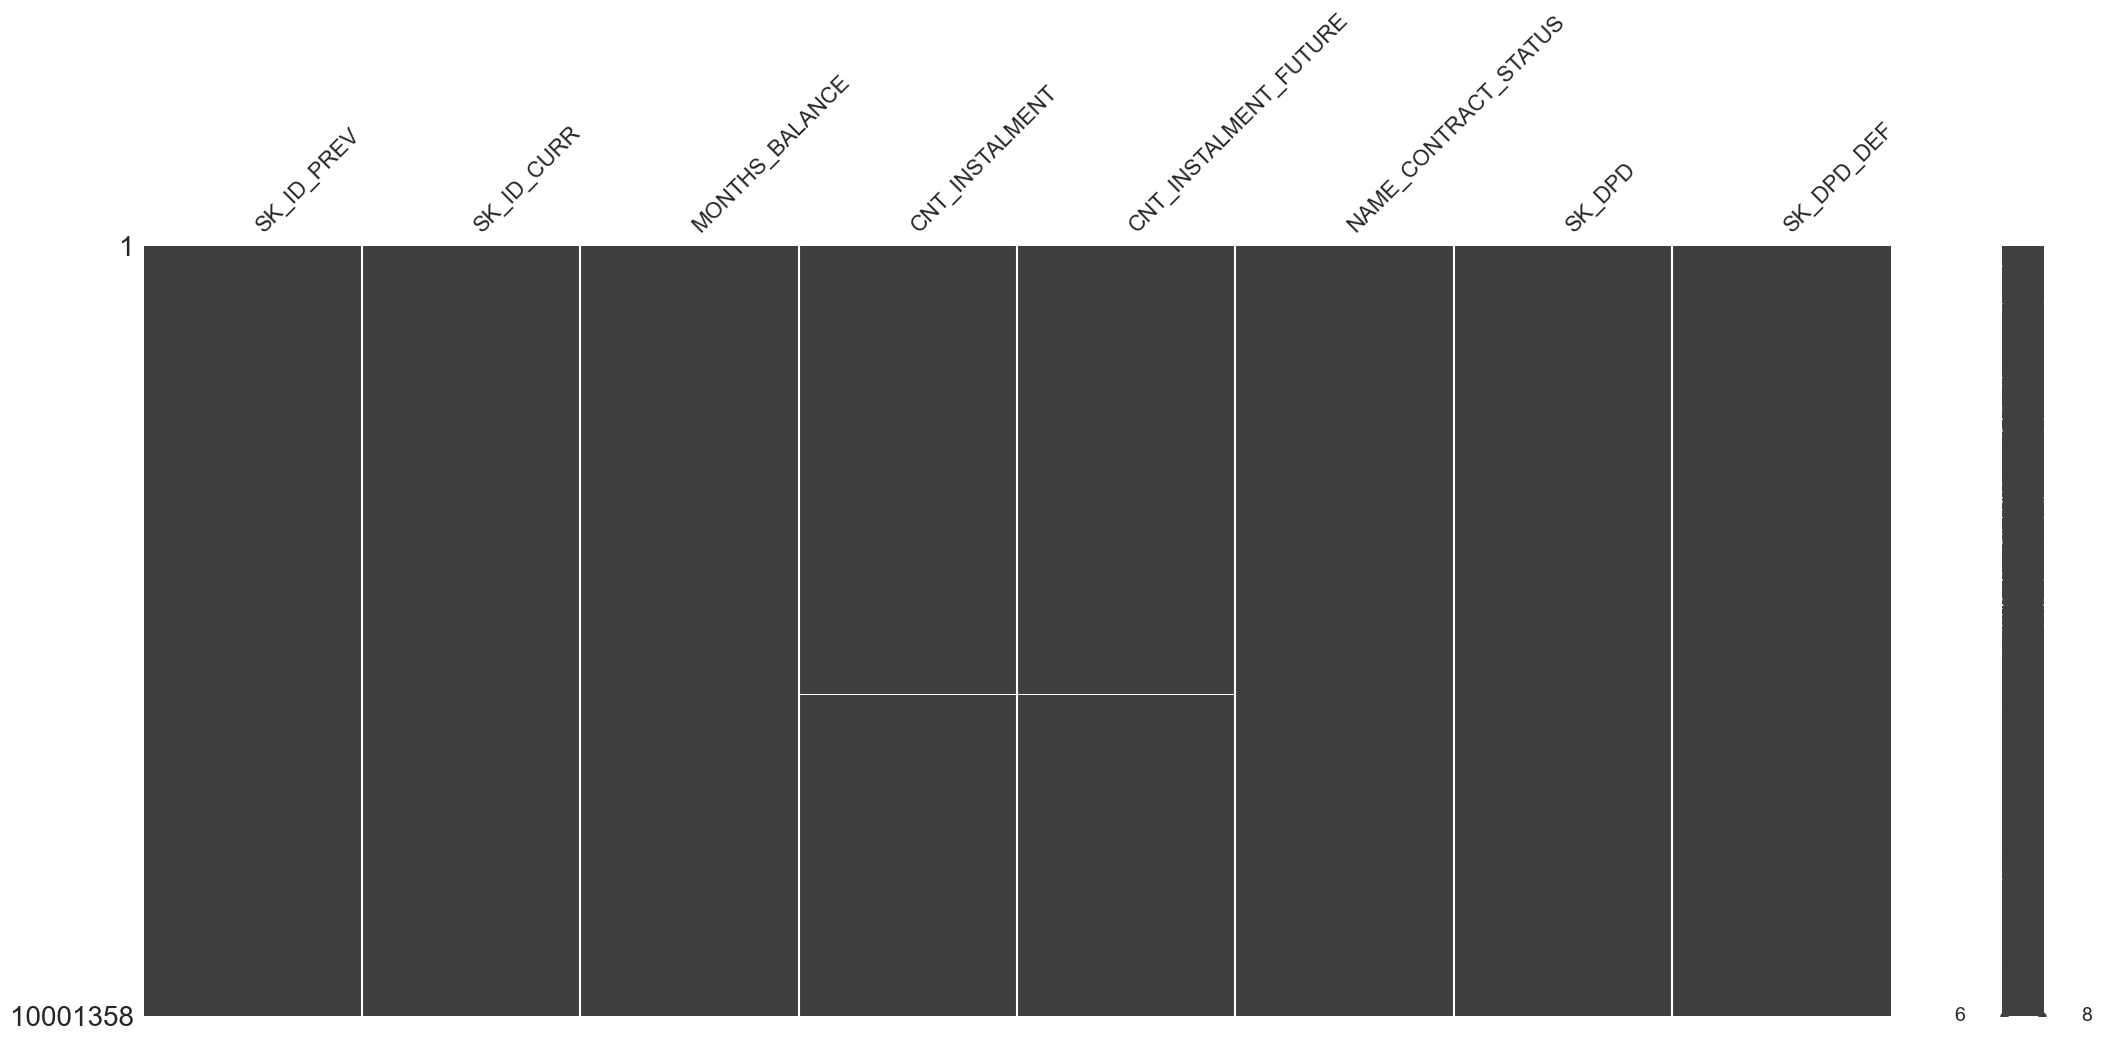

<IPython.core.display.Javascript object>

In [47]:
msno.matrix(pos_cash_balance)

In [48]:
round((pos_cash_balance.isna().sum().sort_values(ascending=False) / len(pos_cash_balance)), 5)

CNT_INSTALMENT_FUTURE    0.00261
CNT_INSTALMENT           0.00261
SK_ID_PREV               0.00000
SK_ID_CURR               0.00000
MONTHS_BALANCE           0.00000
NAME_CONTRACT_STATUS     0.00000
SK_DPD                   0.00000
SK_DPD_DEF               0.00000
dtype: float64

<IPython.core.display.Javascript object>

In [49]:
pos_cash_balance = pos_cash_balance.dropna()

<IPython.core.display.Javascript object>

## 1.2. Duplicate values

There are no duplicates in the dataset.

In [50]:
len(short_application_train) - len(short_application_train.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [51]:
len(short_application_test) - len(short_application_test.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [52]:
len(bureau) - len(bureau.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [53]:
len(bureau_balance) - len(bureau_balance.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [54]:
len(previous_application) - len(previous_application.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [55]:
len(installments_payments) - len(installments_payments.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [56]:
len(credit_card_balance) - len(credit_card_balance.drop_duplicates())  

0

<IPython.core.display.Javascript object>

In [57]:
len(pos_cash_balance) - len(pos_cash_balance.drop_duplicates())  

0

<IPython.core.display.Javascript object>

## 1.3. Data cleaning

In [58]:
def custom_describe_df(my_df):
    for col in my_df.columns:
        print(col)
        if my_df[col].dtype in ['int', 'float']:
            print(home_credit_cols_description[(home_credit_cols_description.Table == 'application_{train|test}.csv') & (home_credit_cols_description.Row == col)]['Description'].values)
            print("Data type:", my_df[col].dtype)
            print("Num of unique values:", my_df[col].nunique())
            print("Min value:", my_df[col].min())
            print("Max value:", my_df[col].max())
            print("-"*50)
        else:        
            print(home_credit_cols_description[(home_credit_cols_description.Table == 'application_{train|test}.csv') & (home_credit_cols_description.Row == col)]['Description'].values)
            print("List of unique values:")
            print(my_df[col].unique())
            print("Num of unique values:", my_df[col].nunique())
            print("Data type:", my_df[col].dtype)
            print("-"*50)

<IPython.core.display.Javascript object>

### 1.3.1. application_{train|test} dataframes

In [59]:
custom_describe_df(short_application_train)

SK_ID_CURR
['ID of loan in our sample']
Data type: int64
Num of unique values: 307511
Min value: 100002
Max value: 456255
--------------------------------------------------
TARGET
['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']
Data type: int64
Num of unique values: 2
Min value: 0
Max value: 1
--------------------------------------------------
NAME_CONTRACT_TYPE
['Identification if loan is cash or revolving']
List of unique values:
['Cash loans' 'Revolving loans']
Num of unique values: 2
Data type: object
--------------------------------------------------
CODE_GENDER
['Gender of the client']
List of unique values:
['M' 'F' 'XNA']
Num of unique values: 3
Data type: object
--------------------------------------------------
FLAG_OWN_CAR
['Flag if the client owns a car']
List of unique values:
['N' 'Y']
Num of unique values: 2
Data type: object
---

<IPython.core.display.Javascript object>

In [60]:
short_application_train_upd = short_application_train.copy()

short_application_train_upd['SK_ID_CURR'] = short_application_train_upd['SK_ID_CURR'].astype('object')

binary_map = {"Y": 1, "N": 0}
bool_cols_apps = [col for col in short_application_train.columns if len(short_application_train[col].unique()) == 2]
bool_cols_apps.remove('NAME_CONTRACT_TYPE')
short_application_train_upd[bool_cols_apps] = short_application_train_upd[bool_cols_apps].replace(binary_map).astype('object')


date_cols_app = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 
                       'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']
date_cols_names = {'DAYS_BIRTH': 'AGE', 'DAYS_EMPLOYED': 'YEARS_EMPLOYED', 
                   'DAYS_REGISTRATION': 'YEARS_REGISTRATION', 
                   'DAYS_ID_PUBLISH': 'YEARS_ID_PUBLISH', 
                   'DAYS_LAST_PHONE_CHANGE': 'YEARS_LAST_PHONE_CHANGE'}
short_application_train_upd[date_cols_app] = (short_application_train_upd[date_cols_app] / -365.25).round(2)

short_application_train_upd.rename(columns=date_cols_names, inplace=True)

amt_req_credit_bureau_cols = ['AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                               'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
                               'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR']
short_application_train_upd['SUM_AMT_REQ_CREDIT_BUREAU'] = short_application_train_upd[amt_req_credit_bureau_cols].sum(axis=1)

float_columns = short_application_train_upd.select_dtypes(include='float64').columns
short_application_train_upd[float_columns] = short_application_train_upd[float_columns].round(2)

<IPython.core.display.Javascript object>

In [61]:
short_application_test_upd = short_application_test.copy()

short_application_test_upd['SK_ID_CURR'] = short_application_test_upd['SK_ID_CURR'].astype('object')

bool_cols_apps_test = [col for col in short_application_test_upd.columns if len(short_application_test_upd[col].unique()) == 2]
bool_cols_apps_test.remove('NAME_CONTRACT_TYPE')
short_application_test_upd[bool_cols_apps_test] = short_application_test_upd[bool_cols_apps_test].replace(binary_map).astype('object')

short_application_test_upd[date_cols_app] = (short_application_test_upd[date_cols_app] / -365.25).round(2)

short_application_test_upd.rename(columns=date_cols_names, inplace=True)

short_application_test_upd['SUM_AMT_REQ_CREDIT_BUREAU'] = short_application_test_upd[amt_req_credit_bureau_cols].sum(axis=1)

float_columns = short_application_test_upd.select_dtypes(include='float64').columns
short_application_test_upd[float_columns] = short_application_test_upd[float_columns].round(2)

<IPython.core.display.Javascript object>

### 1.3.2. bureau and bureau_balance dataframes

In [62]:
custom_describe_df(bureau)

SK_ID_CURR
['ID of loan in our sample']
Data type: int64
Num of unique values: 305811
Min value: 100001
Max value: 456255
--------------------------------------------------
SK_ID_BUREAU
[]
Data type: int64
Num of unique values: 1716428
Min value: 5000000
Max value: 6843457
--------------------------------------------------
CREDIT_ACTIVE
[]
List of unique values:
['Closed' 'Active' 'Sold' 'Bad debt']
Num of unique values: 4
Data type: object
--------------------------------------------------
CREDIT_CURRENCY
[]
List of unique values:
['currency 1' 'currency 2' 'currency 4' 'currency 3']
Num of unique values: 4
Data type: object
--------------------------------------------------
DAYS_CREDIT
[]
Data type: int64
Num of unique values: 2923
Min value: -2922
Max value: 0
--------------------------------------------------
CREDIT_DAY_OVERDUE
[]
Data type: int64
Num of unique values: 942
Min value: 0
Max value: 2792
--------------------------------------------------
DAYS_CREDIT_ENDDATE
[]
Data ty

<IPython.core.display.Javascript object>

In [63]:
bureau_upd = bureau.copy()

bureau_upd[['SK_ID_CURR', 'SK_ID_BUREAU']] = bureau_upd[['SK_ID_CURR', 'SK_ID_BUREAU']].astype('object')

date_cols_bureau = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 
                    'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
date_bureau_map = {'DAYS_CREDIT': 'YEARS_CREDIT', 
                   'CREDIT_DAY_OVERDUE': 'CREDIT_YEAR_OVERDUE', 
                   'DAYS_CREDIT_ENDDATE': 'YEARS_CREDIT_ENDDATE', 
                   'DAYS_ENDDATE_FACT': 'YEARS_ENDDATE_FACT', 
                   'DAYS_CREDIT_UPDATE': 'YEARS_CREDIT_UPDATE'}
bureau_upd[date_cols_bureau] = (bureau_upd[date_cols_bureau] / -365.25).round(2)

bureau_upd.rename(columns=date_bureau_map, inplace=True)

float_columns_bureau = bureau_upd.select_dtypes(include='float64').columns
bureau_upd[float_columns_bureau] = bureau_upd[float_columns_bureau].round(2)

<IPython.core.display.Javascript object>

In [64]:
custom_describe_df(bureau_balance)

SK_ID_BUREAU
[]
Data type: int64
Num of unique values: 817395
Min value: 5001709
Max value: 6842888
--------------------------------------------------
MONTHS_BALANCE
[]
Data type: int64
Num of unique values: 97
Min value: -96
Max value: 0
--------------------------------------------------
STATUS
[]
List of unique values:
['C' '0' 'X' '1' '2' '3' '5' '4']
Num of unique values: 8
Data type: object
--------------------------------------------------


<IPython.core.display.Javascript object>

STATUS column values explanation:
- 'C': Closed (the credit was closed that month)
- '0': No DPD (Days Past Due)
- 'X': No DPD (No DPD information available, commonly used for the current month)
- '1', '2', '3', '4', '5': DPD values, indicating the number of days past due (e.g., '1' for 1 day past due).

In [65]:
bureau_balance_upd = bureau_balance.copy()

bureau_balance_upd['SK_ID_BUREAU'] = bureau_upd['SK_ID_BUREAU'].astype('object')

<IPython.core.display.Javascript object>

In [66]:
bureau_merged = pd.merge(bureau_upd, bureau_balance_upd, on='SK_ID_BUREAU', how='inner')

<IPython.core.display.Javascript object>

### 1.3.3. credit_card_balance, previous_application, installments_payments, and POS_CASH_balance dataframes

In [67]:
custom_describe_df(credit_card_balance)

SK_ID_PREV
[]
Data type: int64
Num of unique values: 104307
Min value: 1000018
Max value: 2843496
--------------------------------------------------
SK_ID_CURR
['ID of loan in our sample']
Data type: int64
Num of unique values: 103558
Min value: 100006
Max value: 456250
--------------------------------------------------
MONTHS_BALANCE
[]
Data type: int64
Num of unique values: 96
Min value: -96
Max value: -1
--------------------------------------------------
AMT_BALANCE
[]
Data type: float64
Num of unique values: 1347904
Min value: -420250.185
Max value: 1505902.185
--------------------------------------------------
AMT_CREDIT_LIMIT_ACTUAL
[]
Data type: int64
Num of unique values: 181
Min value: 0
Max value: 1350000
--------------------------------------------------
AMT_DRAWINGS_ATM_CURRENT
[]
Data type: float64
Num of unique values: 2267
Min value: -6827.31
Max value: 2115000.0
--------------------------------------------------
AMT_DRAWINGS_CURRENT
[]
Data type: float64
Num of unique v

<IPython.core.display.Javascript object>

In [68]:
credit_card_balance_upd = credit_card_balance.copy()

credit_card_balance_upd[['SK_ID_PREV', 'SK_ID_CURR']] = credit_card_balance_upd[['SK_ID_PREV', 'SK_ID_CURR']].astype('object')

float_cols_card_balance = credit_card_balance_upd.select_dtypes(include='float64').columns
credit_card_balance_upd[float_cols_card_balance] = credit_card_balance_upd[float_cols_card_balance].round(2)

<IPython.core.display.Javascript object>

In [69]:
custom_describe_df(previous_application)

SK_ID_PREV
[]
Data type: int64
Num of unique values: 1670214
Min value: 1000001
Max value: 2845382
--------------------------------------------------
SK_ID_CURR
['ID of loan in our sample']
Data type: int64
Num of unique values: 338857
Min value: 100001
Max value: 456255
--------------------------------------------------
NAME_CONTRACT_TYPE
['Identification if loan is cash or revolving']
List of unique values:
['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
Num of unique values: 4
Data type: object
--------------------------------------------------
AMT_ANNUITY
['Loan annuity']
Data type: float64
Num of unique values: 357959
Min value: 0.0
Max value: 418058.145
--------------------------------------------------
AMT_APPLICATION
[]
Data type: float64
Num of unique values: 93885
Min value: 0.0
Max value: 6905160.0
--------------------------------------------------
AMT_CREDIT
['Credit amount of the loan']
Data type: float64
Num of unique values: 86803
Min value: 0.0
Max value: 690516

<IPython.core.display.Javascript object>

In [70]:
previous_application_upd = previous_application.copy()

previous_application_upd[['SK_ID_PREV', 'SK_ID_CURR']] = previous_application_upd[['SK_ID_PREV', 'SK_ID_CURR']].astype('object')

bool_cols_prev = [col for col in previous_application_upd.columns if len(previous_application_upd[col].unique()) == 2]
bool_cols_prev.append('NFLAG_INSURED_ON_APPROVAL')
previous_application_upd[bool_cols_prev] = previous_application_upd[bool_cols_prev].replace(binary_map).astype('object')

day_prev_app_cols = previous_application_upd.filter(like='DAYS').columns.tolist()
previous_application_upd[day_prev_app_cols] = (previous_application_upd[day_prev_app_cols] / -365.25).round(2)
new_date_columns = [col.replace('DAYS', 'YEARS') for col in day_prev_app_cols]
previous_application_upd.rename(columns=dict(zip(day_prev_app_cols, new_date_columns)), inplace=True)

float_cols_prev_app = previous_application_upd.select_dtypes(include='float64').columns
previous_application_upd[float_cols_prev_app] = previous_application_upd[float_cols_prev_app].round(2)

<IPython.core.display.Javascript object>

In [71]:
custom_describe_df(installments_payments)

SK_ID_PREV
[]
Data type: int64
Num of unique values: 997752
Min value: 1000001
Max value: 2843499
--------------------------------------------------
SK_ID_CURR
['ID of loan in our sample']
Data type: int64
Num of unique values: 339587
Min value: 100001
Max value: 456255
--------------------------------------------------
NUM_INSTALMENT_VERSION
[]
Data type: float64
Num of unique values: 65
Min value: 0.0
Max value: 178.0
--------------------------------------------------
NUM_INSTALMENT_NUMBER
[]
Data type: int64
Num of unique values: 277
Min value: 1
Max value: 277
--------------------------------------------------
DAYS_INSTALMENT
[]
Data type: float64
Num of unique values: 2922
Min value: -2922.0
Max value: -1.0
--------------------------------------------------
DAYS_ENTRY_PAYMENT
[]
Data type: float64
Num of unique values: 3039
Min value: -4921.0
Max value: -1.0
--------------------------------------------------
AMT_INSTALMENT
[]
Data type: float64
Num of unique values: 902539
Min val

<IPython.core.display.Javascript object>

In [72]:
installments_payments_upd = installments_payments.copy()

installments_payments_upd[['SK_ID_PREV', 'SK_ID_CURR']] = installments_payments_upd[['SK_ID_PREV', 'SK_ID_CURR']].astype('object')

day_inst_paym_cols = installments_payments_upd.filter(like='DAYS').columns.tolist()
installments_payments_upd[day_inst_paym_cols] = (installments_payments_upd[day_inst_paym_cols] / -365.25).round(2)
new_date_columns = [col.replace('DAYS', 'YEARS') for col in day_inst_paym_cols]
installments_payments_upd.rename(columns=dict(zip(day_inst_paym_cols, new_date_columns)), inplace=True)

float_cols_inst_paym = installments_payments_upd.select_dtypes(include='float64').columns
installments_payments_upd[float_cols_inst_paym] = installments_payments_upd[float_cols_inst_paym].round(2)

<IPython.core.display.Javascript object>

In [73]:
custom_describe_df(pos_cash_balance)

SK_ID_PREV
[]
Data type: int64
Num of unique values: 935435
Min value: 1000001
Max value: 2843499
--------------------------------------------------
SK_ID_CURR
['ID of loan in our sample']
Data type: int64
Num of unique values: 337224
Min value: 100001
Max value: 456255
--------------------------------------------------
MONTHS_BALANCE
[]
Data type: int64
Num of unique values: 96
Min value: -96
Max value: -1
--------------------------------------------------
CNT_INSTALMENT
[]
Data type: float64
Num of unique values: 73
Min value: 1.0
Max value: 92.0
--------------------------------------------------
CNT_INSTALMENT_FUTURE
[]
Data type: float64
Num of unique values: 79
Min value: 0.0
Max value: 85.0
--------------------------------------------------
NAME_CONTRACT_STATUS
[]
List of unique values:
['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'Amortized debt']
Num of unique values: 8
Data type: object
-------------------------------------------------

<IPython.core.display.Javascript object>

In [74]:
pos_cash_balance_upd = pos_cash_balance.copy()

pos_cash_balance_upd[['SK_ID_PREV', 'SK_ID_CURR']] = pos_cash_balance_upd[['SK_ID_PREV', 'SK_ID_CURR']].astype('object')

float_cols_pos_cash = pos_cash_balance_upd.select_dtypes(include='float64').columns
pos_cash_balance_upd[float_cols_pos_cash] = pos_cash_balance_upd[float_cols_pos_cash].round(2)

<IPython.core.display.Javascript object>

## 1.4. Handling outliers

- There are many outliers in the dataset. Some of them are in acceptable ranges, others seem to be erroneous entries. For the EDA part of the project we substituted seemingly false entries with NaNs, and left other outliers in place. We will additionally handle the outliers at the modeling stage.

### 1.4.1. application_{train|test} dataframes

In [75]:
short_application_train_upd.select_dtypes(exclude=["object", "bool"]).describe().round(1)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count      307511.0          307511.0    307511.0     307499.0   
mean            0.4          168797.9    599026.0      27108.6   
std             0.7          237123.1    402490.8      14493.7   
min             0.0           25650.0     45000.0       1615.5   
25%             0.0          112500.0    270000.0      16524.0   
50%             0.0          147150.0    513531.0      24903.0   
75%             1.0          202500.0    808650.0      34596.0   
max            19.0       117000000.0   4050000.0     258025.5   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE       AGE  YEARS_EMPLOYED  \
count         307233.0                    307511.0  307511.0        307511.0   
mean          538396.2                         0.0      43.9          -174.7   
std           369446.5                         0.0      11.9           386.8   
min            40500.0                         0.0      20.5         -1000.0   
25%           238500.0                         0.0      34.0             0.8   
50%           450000.0                         0.0      43.1             3.3   
75%           679500.0                         0.0      53.9             7.6   
max          4050000.0                         0.1      69.1            49.0   

       YEARS_REGISTRATION  YEARS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
count            307511.0          307511.0     307506.0         307509.0   
mean                 13.7               8.2          3.4              2.2   
std                   9.6               4.1          9.3              0.9   
min                   0.0               0.0         -1.0              1.0   
25%                   5.5               4.7         -1.0              2.0   
50%                  12.3               8.9         -1.0              2.0   
75%                  20.5              11.8          5.0              3.0   
max                  67.6              19.7         91.0             20.0   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count              307511.0                     307511.0   
mean                    2.1                          2.0   
std                     0.5                          0.5   
min                     1.0                          1.0   
25%                     2.0                          2.0   
50%                     2.0                          2.0   
75%                     2.0                          2.0   
max                     3.0                          3.0   

       HOUR_APPR_PROCESS_START  EXT_SOURCE_2  EXT_SOURCE_3  \
count                 307511.0      306851.0      246546.0   
mean                      12.1           0.5           0.5   
std                        3.3           0.2           0.2   
min                        0.0           0.0           0.0   
25%                       10.0           0.4           0.4   
50%                       12.0           0.6           0.5   
75%                       14.0           0.7           0.7   
max                       23.0           0.8           0.9   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count                  306490.0                  306490.0   
mean                        1.4                       0.1   
std                         2.4                       0.4   
min                         0.0                       0.0   
25%                         0.0                       0.0   
50%                         0.0                       0.0   
75%                         2.0                       0.0   
max                       348.0                      34.0   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count                  306490.0                  306490.0   
mean                        1.4                       0.1   
std                         2.4                       0.4   
min                         0.0                       0.0   
25%                         0.0           

<IPython.core.display.Javascript object>

55374


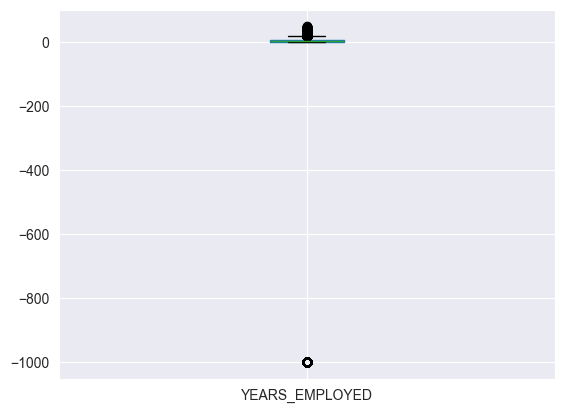

<IPython.core.display.Javascript object>

In [76]:
short_application_train_upd.boxplot(column='YEARS_EMPLOYED')
print(short_application_train_upd['YEARS_EMPLOYED'][short_application_train_upd['YEARS_EMPLOYED'] < -100].count())

There are more than 55K of entries with almost 1000 years of employment, which seems like a data entry error. We will change all values higher than 100 to NaN.

In [77]:
short_application_train_upd['YEARS_EMPLOYED'][short_application_train_upd['YEARS_EMPLOYED'] < -100] = np.nan

<IPython.core.display.Javascript object>

In [78]:
num_cols_app_train = short_application_train_upd.select_dtypes(exclude=["object", "bool"]).columns.tolist()
numeric_cols_app_train = short_application_train_upd[num_cols_app_train]

<IPython.core.display.Javascript object>

In [79]:
discrete_numeric_cols = ['CNT_CHILDREN', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START']
filtered_num_cols_app_train = numeric_cols_app_train.drop(columns=discrete_numeric_cols)

scaler = MinMaxScaler()
scaled_num_app_train = scaler.fit_transform(filtered_num_cols_app_train)
scaled_num_app_train=pd.DataFrame(scaled_num_app_train)
scaled_num_app_train.columns=filtered_num_cols_app_train.columns

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Boxplot for numeric features in Loan Applications dataframe')

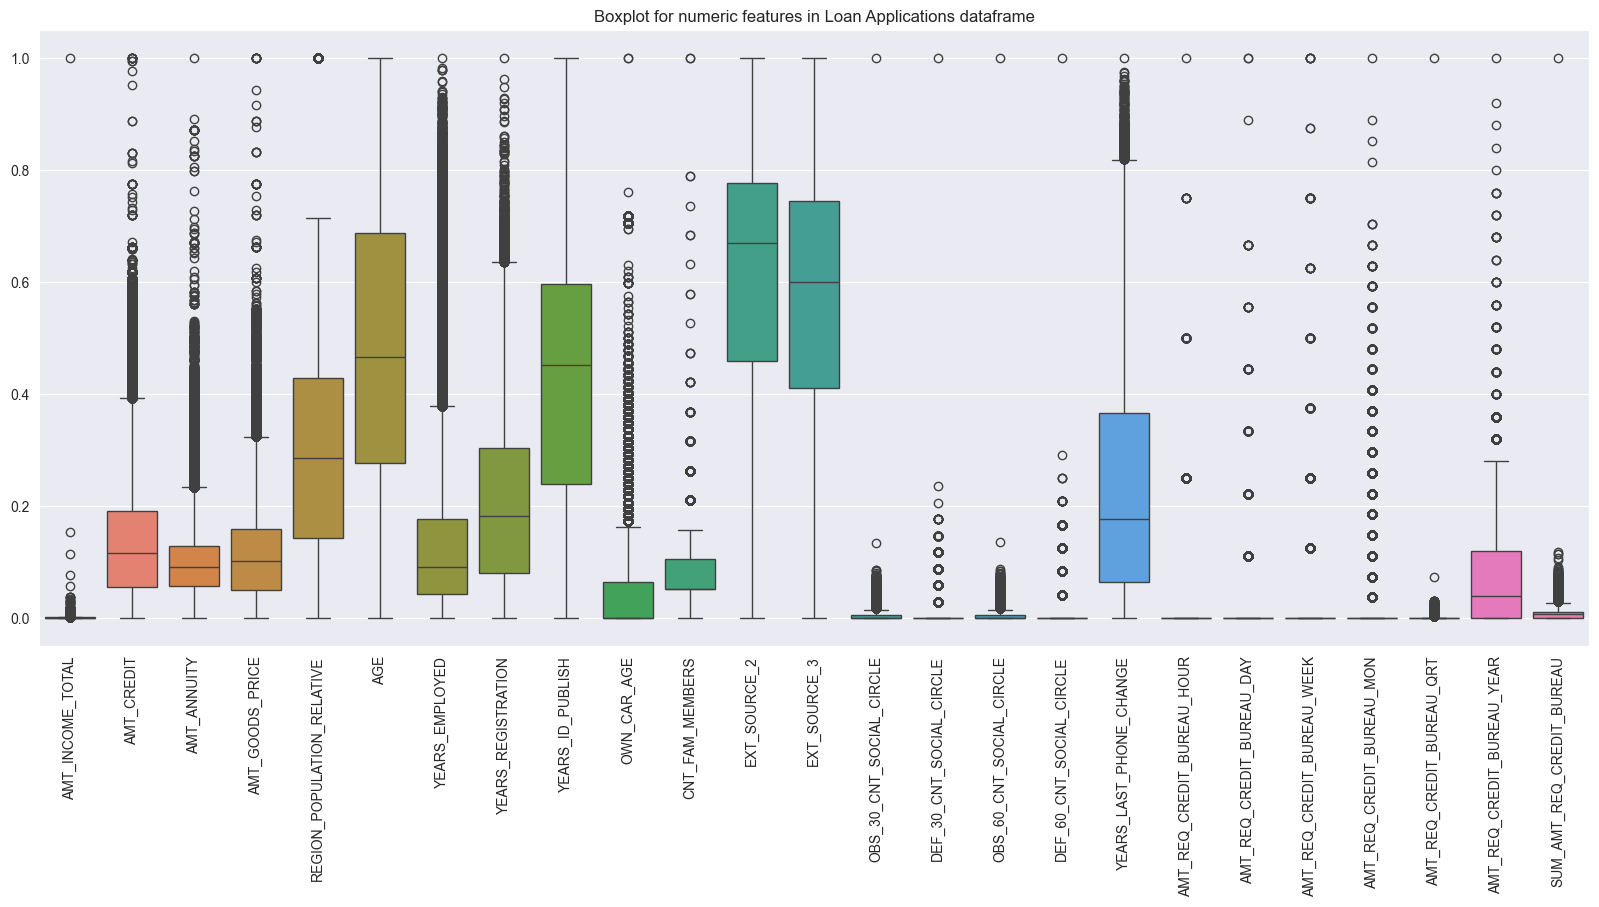

<IPython.core.display.Javascript object>

In [80]:
plt.figure(figsize=(20,8))
s=sns.boxplot(data=scaled_num_app_train)
s.set_xticklabels(scaled_num_app_train.columns,rotation=90)
plt.title("Boxplot for numeric features in Loan Applications dataframe")

Multiple columns in the application_train dataframe contain extreme outliers. Some of them look like data entry errors. We will handle the outliers at the modeling stage.

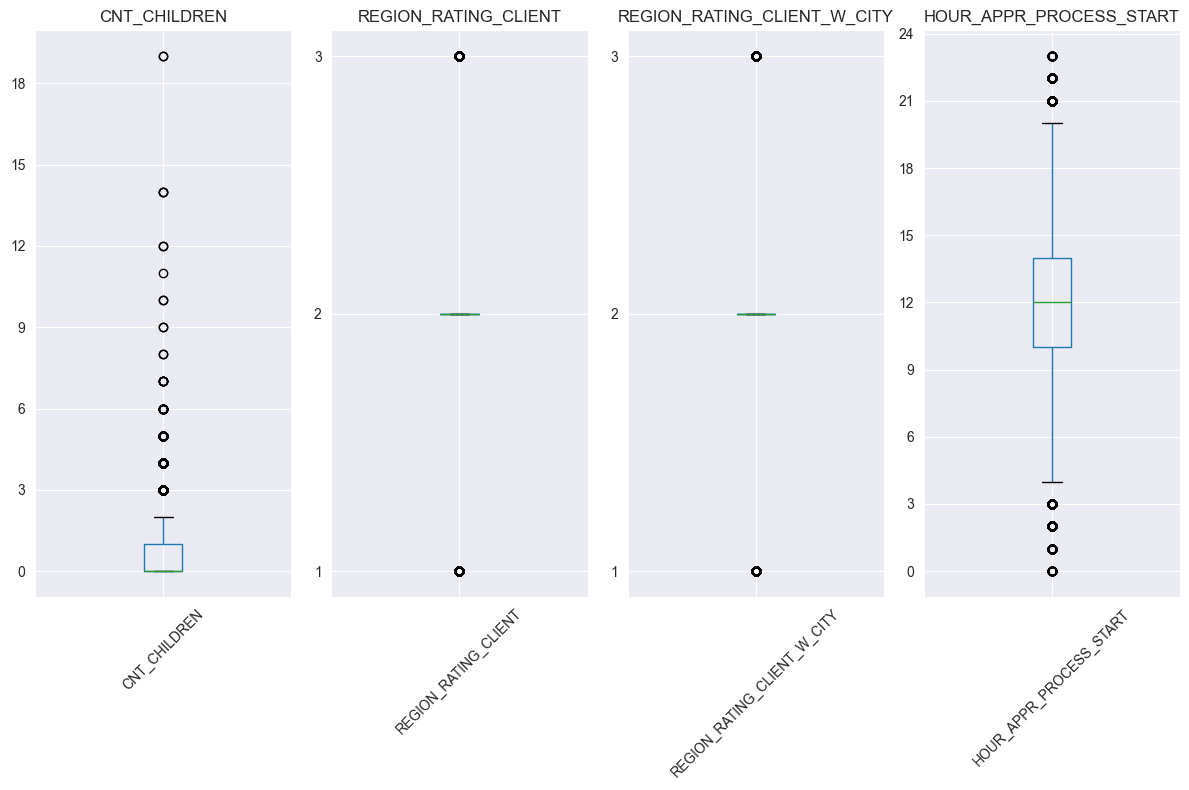

<IPython.core.display.Javascript object>

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols_app_train[discrete_numeric_cols].columns), figsize=(12, 8))

for i, column in enumerate(numeric_cols_app_train[discrete_numeric_cols].columns):
    ax = (
        axes[i] if len(numeric_cols_app_train[discrete_numeric_cols].columns) > 1 else axes
    )
    numeric_cols_app_train[discrete_numeric_cols].boxplot(column=column, ax=ax)
    ax.set_title(column)
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Discrete numerical columns' values seem to be in acceptable ranges. During the modeling stage, we will further handle outliers.

### 1.4.2. Other dataframes

- All of dataframes contain multiple columns with outliers. We will handle the outliers at the modeling stage.

bureau_merged dataframe

In [82]:
bureau_merged.select_dtypes(exclude=["object", "bool"]).describe().round(1)

YEARS_CREDIT  CREDIT_YEAR_OVERDUE  YEARS_CREDIT_ENDDATE  \
count     1716428.0            1716428.0             1610875.0   
mean            3.1                 -0.0                  -1.4   
std             2.2                  0.1                  13.7   
min             0.0                 -7.6                 -85.4   
25%             1.3                 -0.0                  -1.3   
50%             2.7                 -0.0                   0.9   
75%             4.6                  0.0                   3.1   
max             8.0                 -0.0                 115.2   

       YEARS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
count           1082775.0                591940.0           1716428.0   
mean                  2.8                  3825.4                 0.0   
std                   2.0                206031.6                 0.1   
min                   0.0                     0.0                 0.0   
25%                   1.2                     0.0                 0.0   
50%                   2.5                     0.0                 0.0   
75%                   4.1                     0.0                 0.0   
max                 115.0             115987185.0                 9.0   

       AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count       1716415.0            1458759.0             1124648.0   
mean         354994.6             137085.1                6229.5   
std         1149811.3             677401.1               45032.0   
min               0.0           -4705600.3             -586406.1   
25%           51300.0                  0.0                   0.0   
50%          125518.5                  0.0                   0.0   
75%          315000.0              40153.5                   0.0   
max       585000000.0          170100000.0             4705600.3   

       AMT_CREDIT_SUM_OVERDUE  YEARS_CREDIT_UPDATE  AMT_ANNUITY  \
count               1716428.0            1716428.0     489637.0   
mean                     37.9                  1.6      15712.8   
std                    5937.7                  2.0     325826.9   
min                       0.0                 -1.0          0.0   
25%                       0.0                  0.1          0.0   
50%                       0.0                  1.1          0.0   
75%                       0.0                  2.5      13500.0   
max                 3756681.0                114.8  118453423.5   

       MONTHS_BALANCE  
count       1716428.0  
mean            -29.7  
std              23.4  
min             -96.0  
25%             -44.0  
50%             -24.0  
75%             -11.0  
max               0.0

<IPython.core.display.Javascript object>

In [83]:
num_cols_bureau = bureau_merged.select_dtypes(exclude=["object", "bool"]).columns.tolist()
numeric_cols_num_cols_bureau = bureau_merged[num_cols_bureau]

<IPython.core.display.Javascript object>

In [84]:
scaler = MinMaxScaler()
scaled_num_bureau = scaler.fit_transform(numeric_cols_num_cols_bureau)
scaled_num_bureau=pd.DataFrame(scaled_num_bureau)
scaled_num_bureau.columns=numeric_cols_num_cols_bureau.columns

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Boxplot for numeric features in Bureau dataframe')

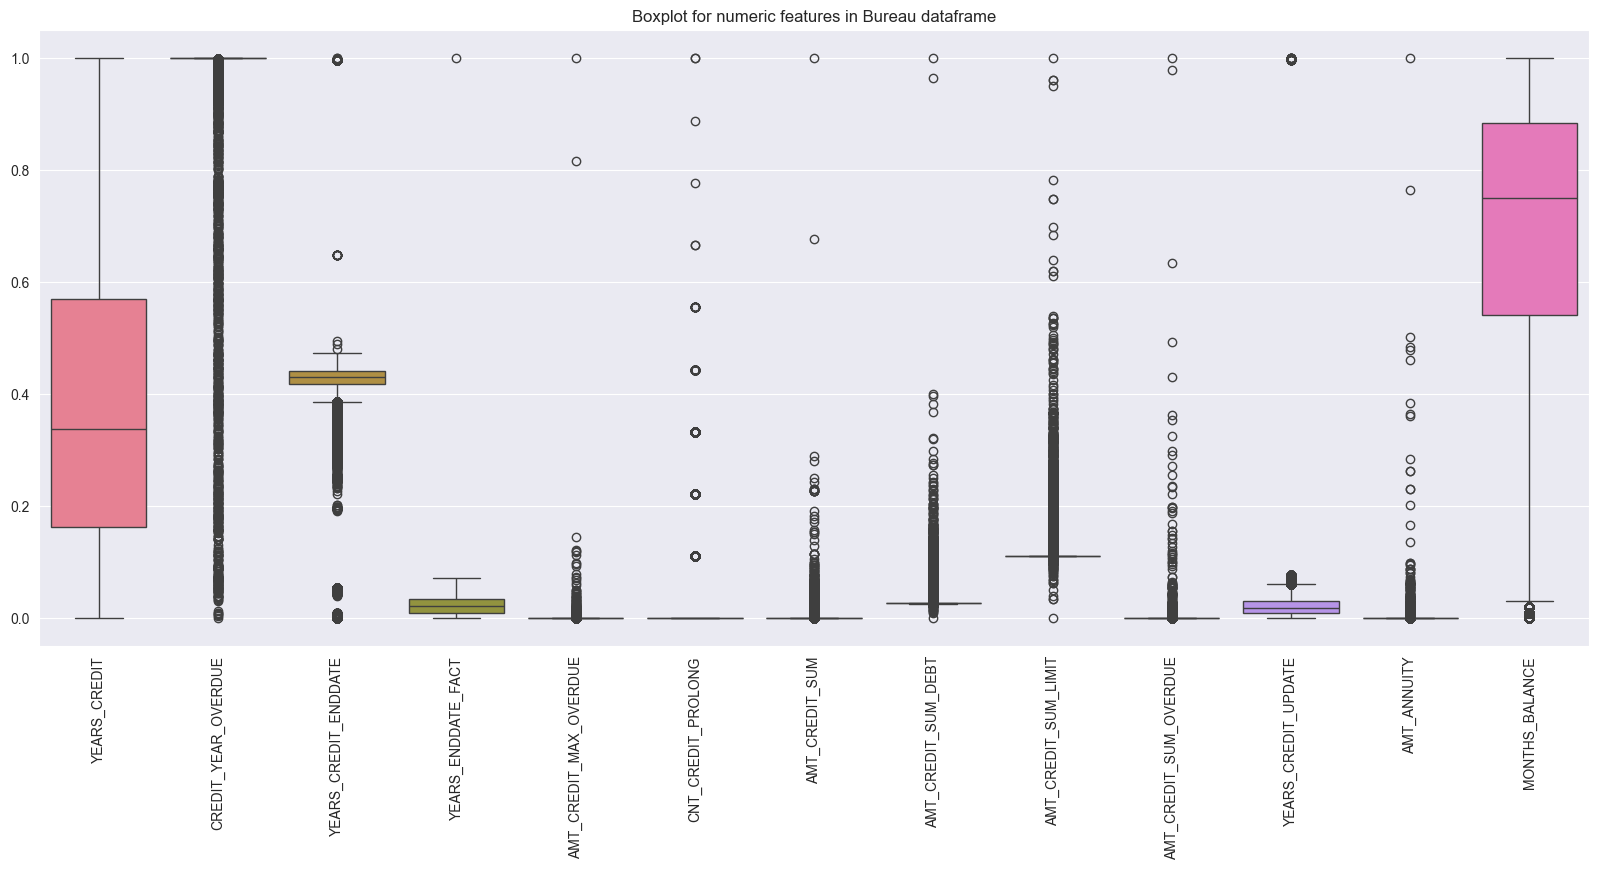

<IPython.core.display.Javascript object>

In [85]:
plt.figure(figsize=(20,8))
s=sns.boxplot(data=scaled_num_bureau)
s.set_xticklabels(scaled_num_bureau.columns,rotation=90)
plt.title("Boxplot for numeric features in Bureau dataframe")

previous_application_upd dataframe

In [86]:
previous_application_upd.select_dtypes(exclude=["object", "bool"]).describe().round(1)

AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  \
count    1297979.0        1670214.0   1670213.0          774370.0   
mean       15955.1         175233.9    196114.0            6697.4   
std        14782.1         292779.8    318574.6           20921.5   
min            0.0              0.0         0.0              -0.9   
25%         6321.8          18720.0     24160.5               0.0   
50%        11250.0          71046.0     80541.0            1638.0   
75%        20658.4         180360.0    216418.5            7740.0   
max       418058.1        6905160.0   6905160.0         3060045.0   

       AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  RATE_DOWN_PAYMENT  \
count        1284699.0                1670214.0           774370.0   
mean          227847.3                     12.5                0.1   
std           315396.6                      3.3                0.1   
min                0.0                      0.0                0.0   
25%            50841.0                     10.0                0.0   
50%           112320.0                     12.0                0.0   
75%           234000.0                     15.0                0.1   
max          6905160.0                     23.0                1.0   

       YEARS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  YEARS_FIRST_DRAWING  \
count       1670214.0         1670214.0    1297984.0             997149.0   
mean              2.4             314.0         16.1               -936.9   
std               2.1            7127.4         14.6                243.4   
min               0.0              -1.0          0.0              -1000.0   
25%               0.8              -1.0          6.0              -1000.0   
50%               1.6               3.0         12.0              -1000.0   
75%               3.6              82.0         24.0              -1000.0   
max               8.0         4000000.0         84.0                  8.0   

       YEARS_FIRST_DUE  YEARS_LAST_DUE_1ST_VERSION  YEARS_LAST_DUE  \
count         997149.0                    997149.0        997149.0   
mean             -37.9                       -92.5          -209.7   
std              198.3                       292.6           409.7   
min            -1000.0                     -1000.0         -1000.0   
25%                1.1                        -0.4             0.2   
50%                2.3                         1.0             1.5   
75%                4.5                         3.4             3.6   
max                7.9                         7.7             7.9   

       YEARS_TERMINATION  
count           997149.0  
mean              -224.5  
std                419.7  
min              -1000.0  
25%                  0.1  
50%                  1.4  
75%                  3.5  
max                  7.9

<IPython.core.display.Javascript object>

In [87]:
years_prev_app_cols = previous_application_upd.filter(like='YEARS').columns.tolist()

previous_application_upd[years_prev_app_cols] = previous_application_upd[years_prev_app_cols].applymap(lambda x: np.nan if x < -100 else x)

<IPython.core.display.Javascript object>

In [88]:
num_cols_prev_app = previous_application_upd.select_dtypes(exclude=["object", "bool"]).columns.tolist()
numeric_cols_prev_app = previous_application_upd[num_cols_prev_app]

<IPython.core.display.Javascript object>

In [89]:
scaler = MinMaxScaler()
scaled_num_prev_app = scaler.fit_transform(numeric_cols_prev_app)
scaled_num_prev_app=pd.DataFrame(scaled_num_prev_app)
scaled_num_prev_app.columns=numeric_cols_prev_app.columns

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Boxplot for numeric features in the Previous Applications dataframe')

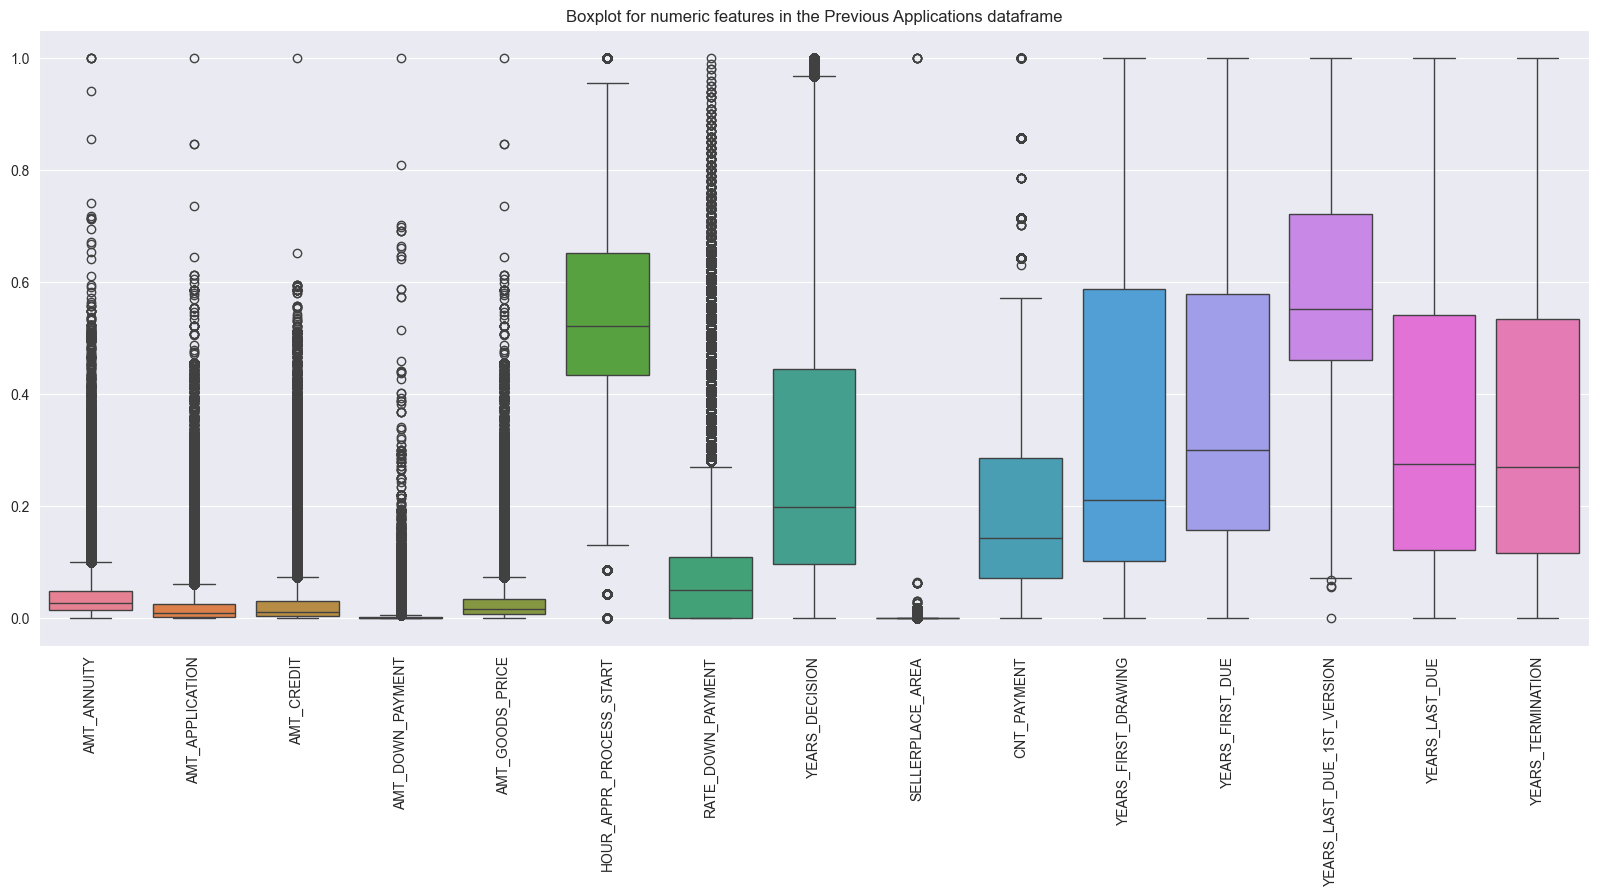

<IPython.core.display.Javascript object>

In [90]:
plt.figure(figsize=(20,8))
s=sns.boxplot(data=scaled_num_prev_app)
s.set_xticklabels(scaled_num_prev_app.columns,rotation=90)
plt.title("Boxplot for numeric features in the Previous Applications dataframe")

installments_payments_upd dataframe

In [91]:
installments_payments_upd.select_dtypes(exclude=["object", "bool"]).describe().round(1)

NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  YEARS_INSTALMENT  \
count              13605401.0             13605401.0        13605401.0   
mean                      0.9                   18.9               2.9   
std                       1.0                   26.7               2.2   
min                       0.0                    1.0               0.0   
25%                       0.0                    4.0               1.0   
50%                       1.0                    8.0               2.2   
75%                       1.0                   19.0               4.5   
max                     178.0                  277.0               8.0   

       YEARS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
count           13602496.0      13605401.0   13602496.0  
mean                   2.9         17050.9      17238.2  
std                    2.2         50570.3      54735.8  
min                    0.0             0.0          0.0  
25%                    1.0          4226.1       3398.3  
50%                    2.3          8884.1       8125.5  
75%                    4.6         16710.2      16108.4  
max                   13.5       3771487.8    3771487.8

<IPython.core.display.Javascript object>

In [92]:
num_cols_install_paym = installments_payments_upd.select_dtypes(exclude=["object", "bool"]).columns.tolist()
numeric_cols_install_paym = installments_payments_upd[num_cols_install_paym]

<IPython.core.display.Javascript object>

In [93]:
scaler = MinMaxScaler()
scaled_num_install_paym = scaler.fit_transform(numeric_cols_install_paym)
scaled_num_install_paym=pd.DataFrame(scaled_num_install_paym)
scaled_num_install_paym.columns=numeric_cols_install_paym.columns

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Boxplot for numeric features in the Installment Payments dataframe')

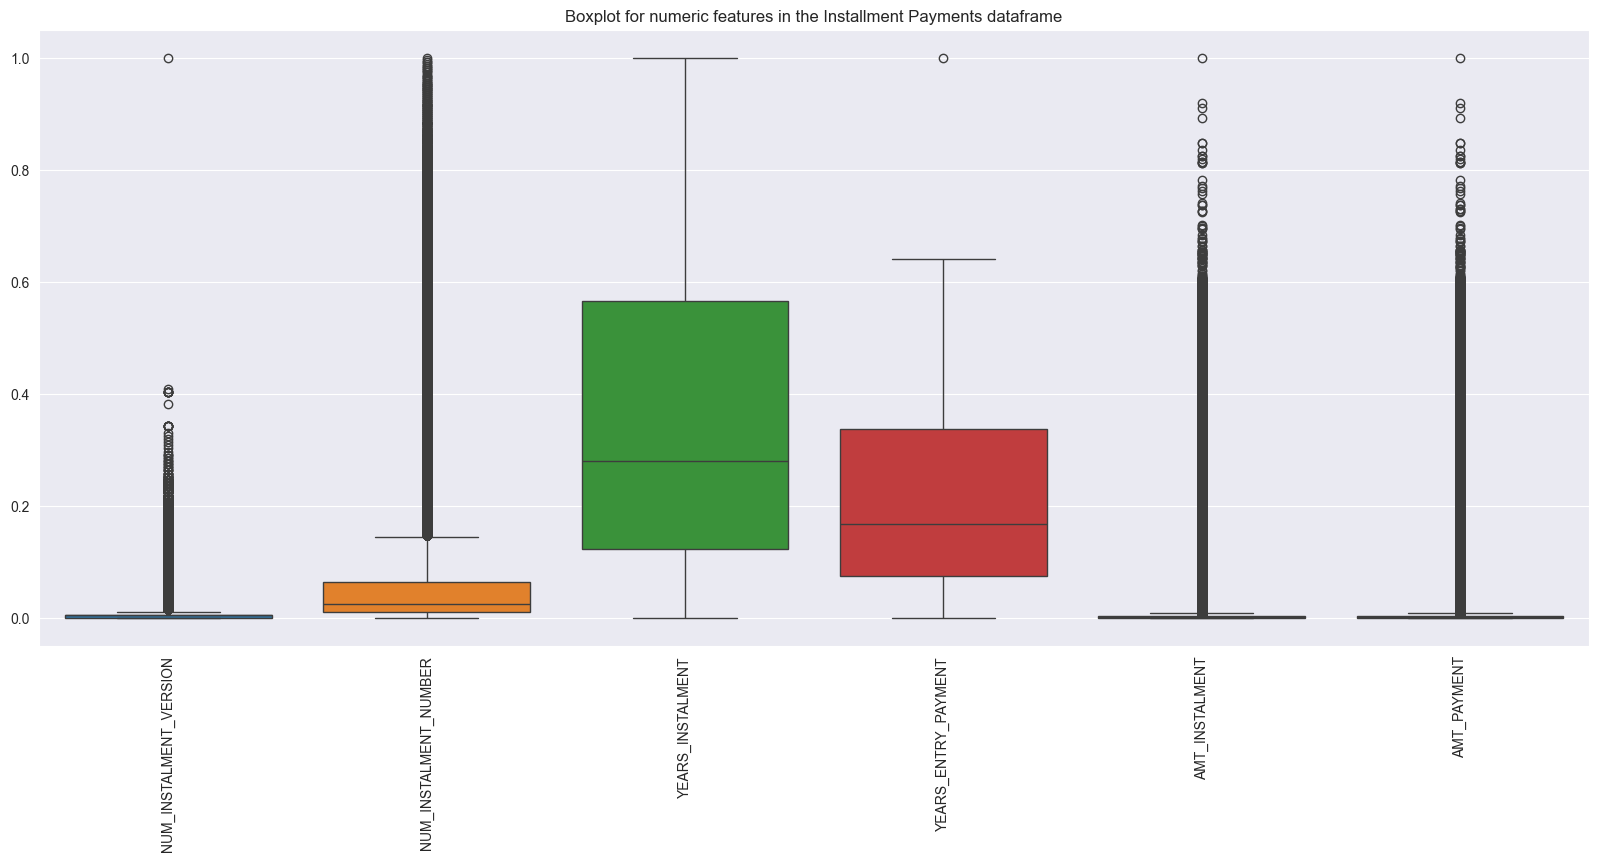

<IPython.core.display.Javascript object>

In [94]:
plt.figure(figsize=(20, 8))
s = sns.boxplot(data=scaled_num_install_paym)
s.set_xticklabels(scaled_num_install_paym.columns, rotation=90)
plt.title("Boxplot for numeric features in the Installment Payments dataframe")

credit_card_balance_upd dataframe

In [95]:
credit_card_balance_upd.select_dtypes(exclude=["object", "bool"]).describe().round(1)

MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
count       3840312.0    3840312.0                3840312.0   
mean            -34.5      58300.2                 153808.0   
std              26.7     106307.0                 165145.7   
min             -96.0    -420250.2                      0.0   
25%             -55.0          0.0                  45000.0   
50%             -28.0          0.0                 112500.0   
75%             -11.0      89046.7                 180000.0   
max              -1.0    1505902.2                1350000.0   

       AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
count                 3090496.0             3840312.0   
mean                     5961.3                7433.4   
std                     28225.7               33846.1   
min                     -6827.3               -6211.6   
25%                         0.0                   0.0   
50%                         0.0                   0.0   
75%                         0.0                   0.0   
max                   2115000.0             2287098.3   

       AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
count                   3090496.0                 3090496.0   
mean                        288.2                    2968.8   
std                        8202.0                   20796.9   
min                           0.0                       0.0   
25%                           0.0                       0.0   
50%                           0.0                       0.0   
75%                           0.0                       0.0   
max                     1529847.0                 2239274.2   

       AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
count                3535076.0            3072324.0   
mean                    3540.2              10280.5   
std                     5600.2              36078.1   
min                        0.0                  0.0   
25%                        0.0                152.4   
50%                        0.0               2702.7   
75%                     6633.9               9000.0   
max                   202882.0            4289207.4   

       AMT_PAYMENT_TOTAL_CURRENT  AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  \
count                  3840312.0                 3840312.0      3840312.0   
mean                      7588.9                   55965.9        58088.8   
std                      32006.0                  102533.6       105965.4   
min                          0.0                 -423305.8      -420250.2   
25%                          0.0                       0.0            0.0   
50%                          0.0                       0.0            0.0   
75%                       6750.0                   85359.2        88899.5   
max                    4278315.7                 1472316.8      1493338.2   

       AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count             3840312.0                 3090496.0             3840312.0   
mean                58098.3                       0.3                   0.7   
std                105971.8                       1.1                   3.2   
min               -420250.2                       0.0                   0.0   
25%                     0.0                       0.0                   0.0   
50%                     0.0                       0.0                   0.0   
75%                 88914.5                       0.0                   0.0   
max               1493338.2                      51.0                 165.0   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                   3090496.0                 3090496.0   
mean                          0.0                       0.6   
std                           0.1                       3.2   
min                           0.0                       0.0   
25%                           0.0                       0.0   
50%                           0.0                       0.0   
75%           

<IPython.core.display.Javascript object>

In [96]:
num_cols_cc_balance = credit_card_balance_upd.select_dtypes(exclude=["object", "bool"]).columns.tolist()
numeric_cols_cc_balance = credit_card_balance_upd[num_cols_cc_balance]

<IPython.core.display.Javascript object>

In [97]:
scaler = MinMaxScaler()
scaled_num_cc_balance = scaler.fit_transform(numeric_cols_cc_balance)
scaled_num_cc_balance=pd.DataFrame(scaled_num_cc_balance)
scaled_num_cc_balance.columns=numeric_cols_cc_balance.columns

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Boxplot for numeric features in the Credit card balance dataframe')

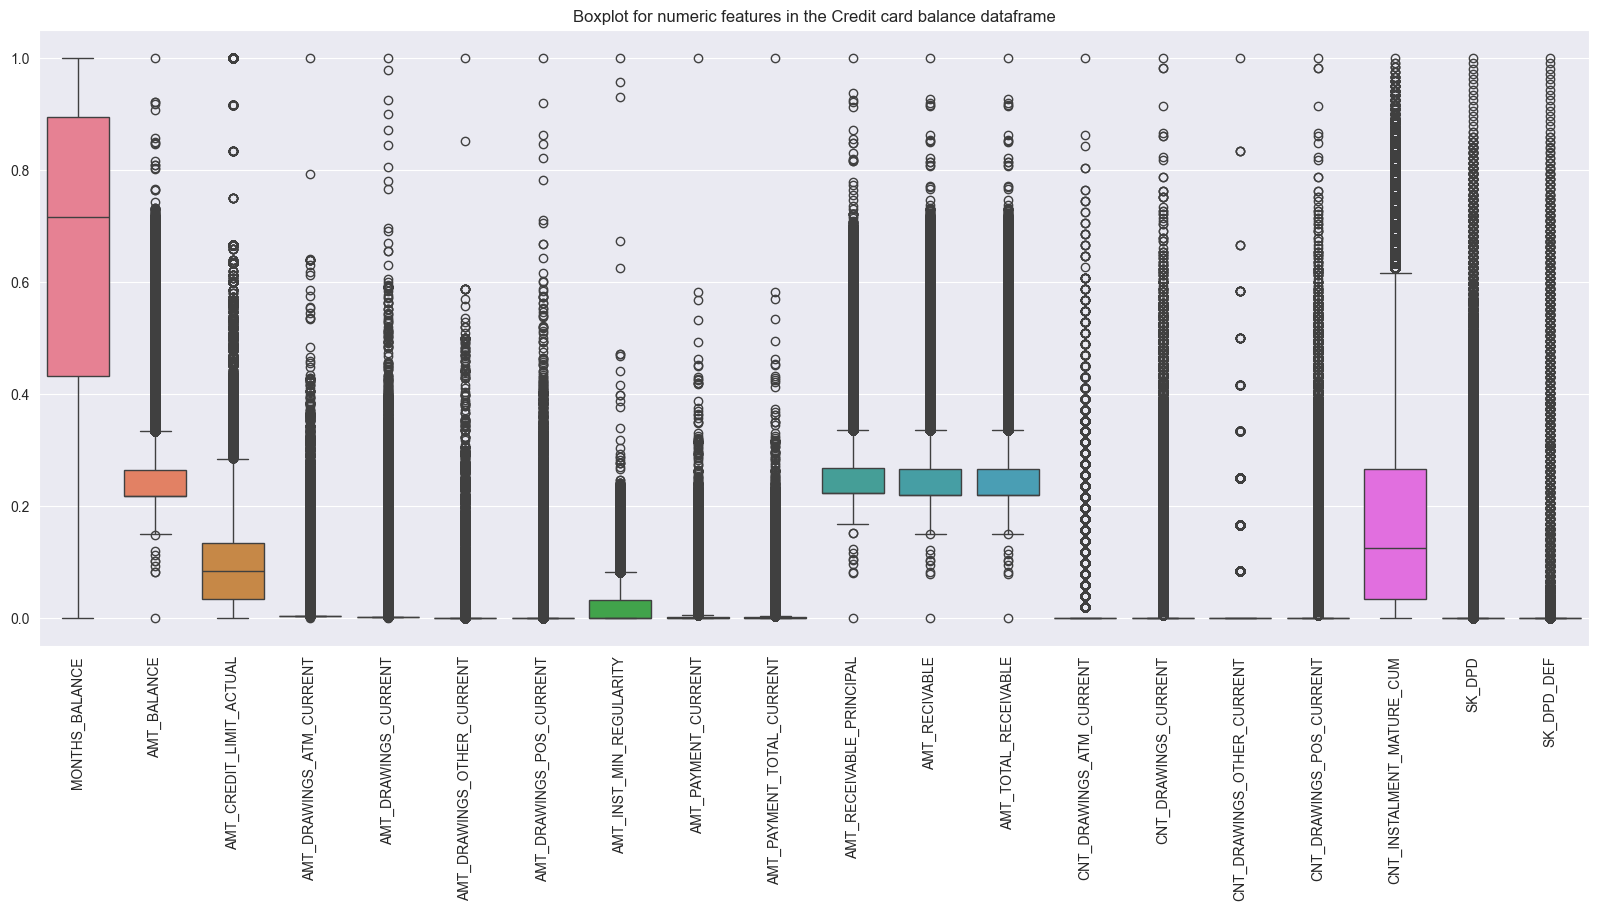

<IPython.core.display.Javascript object>

In [98]:
plt.figure(figsize=(20, 8))
s = sns.boxplot(data=scaled_num_cc_balance)
s.set_xticklabels(scaled_num_cc_balance.columns, rotation=90)
plt.title("Boxplot for numeric features in the Credit card balance dataframe")

pos_cash_balance dataframe

In [99]:
pos_cash_balance_upd.select_dtypes(exclude=["object", "bool"]).describe().round(1)

MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE     SK_DPD  \
count       9975174.0       9975174.0              9975174.0  9975174.0   
mean            -35.1            17.1                   10.5       11.6   
std              26.1            12.0                   11.1      132.9   
min             -96.0             1.0                    0.0        0.0   
25%             -54.0            10.0                    3.0        0.0   
50%             -28.0            12.0                    7.0        0.0   
75%             -13.0            24.0                   14.0        0.0   
max              -1.0            92.0                   85.0     4231.0   

       SK_DPD_DEF  
count   9975174.0  
mean          0.7  
std          32.8  
min           0.0  
25%           0.0  
50%           0.0  
75%           0.0  
max        3595.0

<IPython.core.display.Javascript object>

In [100]:
num_cols_pos_cash = pos_cash_balance_upd.select_dtypes(exclude=["object", "bool"]).columns.tolist()
numeric_cols_pos_cash = pos_cash_balance_upd[num_cols_pos_cash]

<IPython.core.display.Javascript object>

In [101]:
scaler = MinMaxScaler()
scaled_num_pos_cash = scaler.fit_transform(numeric_cols_pos_cash)
scaled_num_pos_cash=pd.DataFrame(scaled_num_pos_cash)
scaled_num_pos_cash.columns=numeric_cols_pos_cash.columns

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Boxplot for numeric features in the POS CASH balance dataframe')

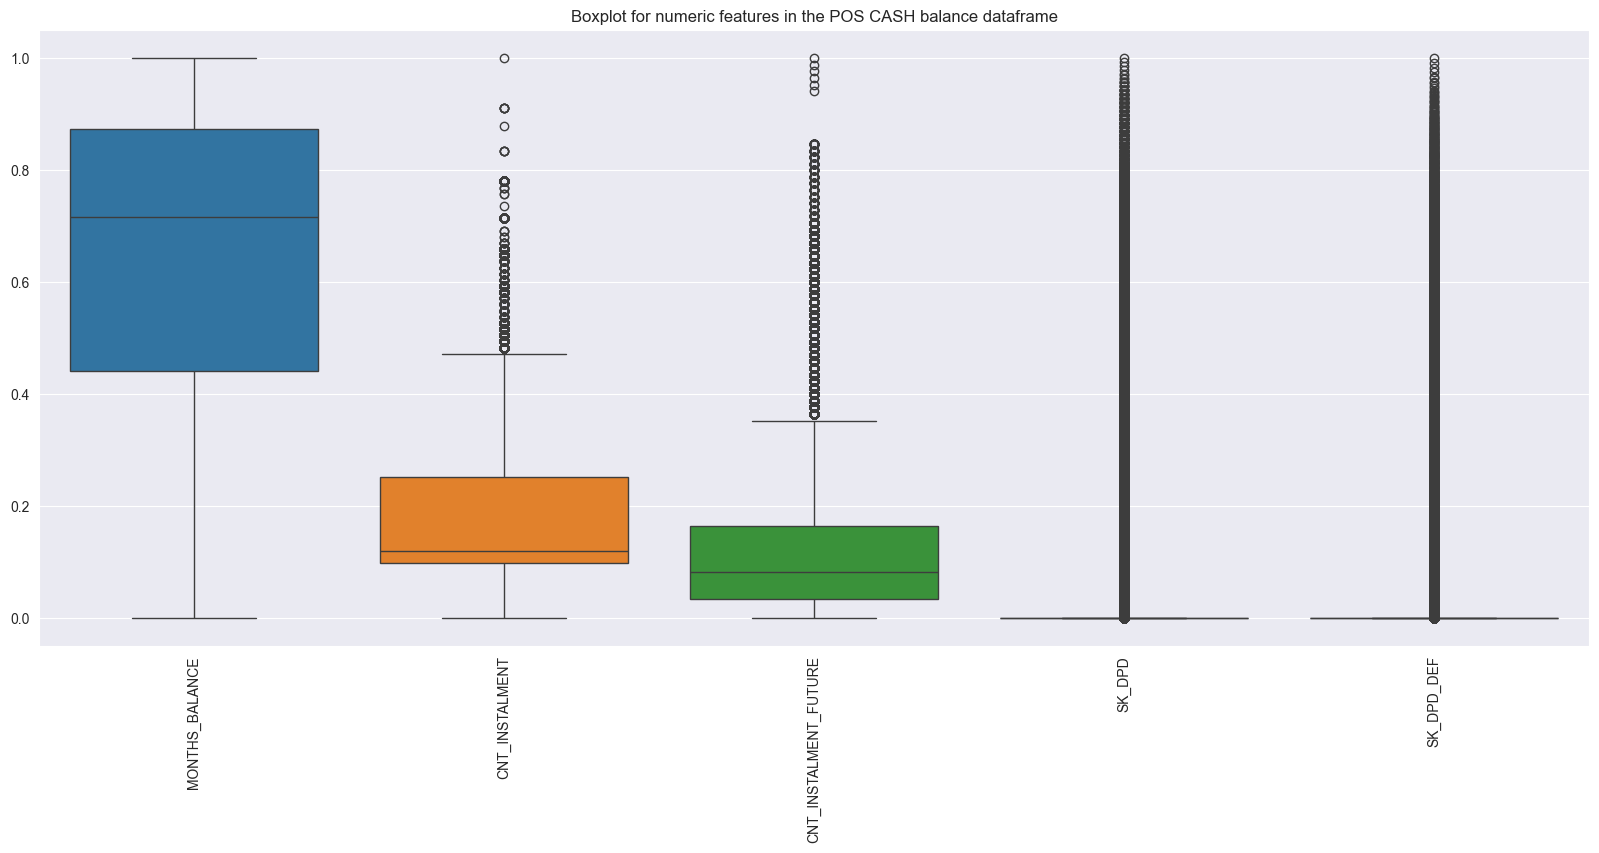

<IPython.core.display.Javascript object>

In [102]:
plt.figure(figsize=(20, 8))
s = sns.boxplot(data=scaled_num_pos_cash)
s.set_xticklabels(scaled_num_pos_cash.columns, rotation=90)
plt.title("Boxplot for numeric features in the POS CASH balance dataframe")

## 1.5. Feature engineering

- Aside from the current loan application data, we have previous loans' info. We will mainly focus on current applications' data in this project, but we will create some new features from other dataframes.

In [103]:
application_train_upd = short_application_train_upd.copy()

<IPython.core.display.Javascript object>

In [402]:
application_test_upd = short_application_test_upd.copy()

<IPython.core.display.Javascript object>

Total credits mentioned in the Credit Bureau and number of previous applications at Home Credit:

In [104]:
num_total_credits_df = bureau_merged.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count().reset_index(name='NUM_TOTAL_CREDITS')
num_prev_apps_df = previous_application_upd.groupby('SK_ID_CURR')['SK_ID_PREV'].count().reset_index(name='NUM_PREV_APPS')

application_train_upd = application_train_upd.merge(num_total_credits_df, on='SK_ID_CURR', how='left')
application_train_upd = application_train_upd.merge(num_prev_apps_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

In [403]:
application_test_upd = application_test_upd.merge(num_total_credits_df, on='SK_ID_CURR', how='left')
application_test_upd = application_test_upd.merge(num_prev_apps_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

Average credit limit: 

In [105]:
avg_credit_limit_df = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].mean().reset_index(name='AVG_CREDIT_LIMIT_BUREAU').round(2)
application_train_upd = application_train_upd.merge(avg_credit_limit_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

In [404]:
application_test_upd = application_test_upd.merge(avg_credit_limit_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

Share of the loan to client's income:
- This ratio is useful in assessing the affordability of the loan for the borrower. A lower ratio suggests a more manageable debt burden relative to income, while a higher ratio may indicate a higher risk of financial strain for the borrower.

In [106]:
application_train_upd['LOAN_INCOME_RATIO'] = (application_train_upd['AMT_CREDIT'] / application_train_upd['AMT_INCOME_TOTAL']).round(2)

<IPython.core.display.Javascript object>

In [405]:
application_test_upd['LOAN_INCOME_RATIO'] = (application_test_upd['AMT_CREDIT'] / application_test_upd['AMT_INCOME_TOTAL']).round(2)

<IPython.core.display.Javascript object>

Average down payment:
- reflects the initial payment made by the borrower when obtaining credit for a specific purchase.

In [107]:
previous_application_upd['DOWN_PAYMENT'] = previous_application_upd['AMT_GOODS_PRICE'] - previous_application_upd['AMT_CREDIT'] 
down_payment_df = previous_application_upd.groupby('SK_ID_CURR')['DOWN_PAYMENT'].mean().round(2).reset_index(name='AVG_DOWN_PAYMENT')
application_train_upd = application_train_upd.merge(down_payment_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

In [406]:
application_test_upd = application_test_upd.merge(down_payment_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

Credit annuity ratio:
-  indicates how many times the annuity payment fits into the total loan amount. Higher values of this ratio suggest a smaller annuity payment relative to the total loan amount, and vice versa. This ratio is significant in understanding the affordability of the loan for the borrower, as it reflects the number of annuity payments required to fully repay the loan.

In [108]:
previous_application_upd['CREDIT_ANNUITY_RATIO'] = previous_application_upd['AMT_CREDIT'] / previous_application_upd['AMT_ANNUITY']
credit_annuity_ratio_df = previous_application_upd.groupby('SK_ID_CURR')['CREDIT_ANNUITY_RATIO'].mean().round(2).reset_index(name='AVG_CREDIT_ANNUITY_RATIO')
application_train_upd = application_train_upd.merge(credit_annuity_ratio_df, on='SK_ID_CURR', how='left') 

<IPython.core.display.Javascript object>

In [407]:
application_test_upd = application_test_upd.merge(credit_annuity_ratio_df, on='SK_ID_CURR', how='left') 

<IPython.core.display.Javascript object>

Credit goods price ratio:
- This ratio is relevant in assessing whether the loan amount aligns appropriately with the intended purpose of the loan. A higher ratio may suggest that a significant portion of the loan is not directly tied to the acquisition of goods or services, while a lower ratio indicates a closer alignment between the loan amount and the cost of the specified goods or services.

In [109]:
previous_application_upd['CREDIT_GOODS_RATIO'] = previous_application_upd['AMT_CREDIT'] / previous_application_upd['AMT_GOODS_PRICE']  
credit_goods_ratio_df = previous_application_upd.groupby('SK_ID_CURR')['CREDIT_GOODS_RATIO'].mean().round(2).reset_index(name='AVG_CREDIT_GOODS_RATIO')
application_train_upd = application_train_upd.merge(credit_goods_ratio_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

In [408]:
application_test_upd = application_test_upd.merge(credit_goods_ratio_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

Number of past due installments:

In [110]:
installments_payments_upd['PAST_DUE'] = (installments_payments_upd['YEARS_ENTRY_PAYMENT'] > installments_payments_upd['YEARS_INSTALMENT']).astype(int)
past_due_installments_df = installments_payments_upd.groupby('SK_ID_CURR')['PAST_DUE'].sum().reset_index(name='NUM_PAST_DUE_INSTALL')
application_train_upd = application_train_upd.merge(past_due_installments_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

In [409]:
application_test_upd = application_test_upd.merge(past_due_installments_df, on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

Approval rate:

In [111]:
previous_application_upd['APPROVED_FLAG'] = (previous_application_upd['NAME_CONTRACT_STATUS']=='Approved').astype(int) 
num_approved = previous_application_upd.groupby('SK_ID_CURR')['APPROVED_FLAG'].sum().reset_index(name='NUM_APPROVED_APPS')
approval_rate = num_prev_apps_df.merge(num_approved, on='SK_ID_CURR', how='left')
approval_rate['APPS_APPROVAL_RATE'] = (approval_rate['NUM_APPROVED_APPS'] / approval_rate['NUM_PREV_APPS']).round(2) 
application_train_upd = application_train_upd.merge(approval_rate[['SK_ID_CURR', 'APPS_APPROVAL_RATE']], on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

In [410]:
application_test_upd = application_test_upd.merge(approval_rate[['SK_ID_CURR', 'APPS_APPROVAL_RATE']], 
                                                  on='SK_ID_CURR', how='left')

<IPython.core.display.Javascript object>

Let's add some other features that could be useful for our analysis and modeling:

In [112]:
pos_cash_cols = pos_cash_balance_upd.groupby('SK_ID_CURR').agg({'SK_DPD':'mean',
                                                                'SK_DPD_DEF':'mean'}).round(2).reset_index()
pos_cash_cols = pos_cash_cols.rename(columns={'SK_DPD': 'AVG_SK_DPD', 
                                              'SK_DPD_DEF': 'AVG_SK_DPD_DEF'})
application_train_upd = application_train_upd.merge(pos_cash_cols, on='SK_ID_CURR', how='left')

bureau_cols_df = bureau_merged[['SK_ID_CURR','CREDIT_ACTIVE','YEARS_CREDIT', 'AMT_CREDIT_MAX_OVERDUE']] 
bureau_cols_df = bureau_cols_df.groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE': 'max', 
                                                           'YEARS_CREDIT': 'min',
                                                           'AMT_CREDIT_MAX_OVERDUE': 'sum'})
bureau_cols_df = bureau_cols_df.rename(columns={'CREDIT_ACTIVE': 'LAST_BURR_CREDIT_STATUS', 
                                                'YEARS_CREDIT': 'YEARS_SINCE_LAST_BURR_CREDIT', 
                                                'AMT_CREDIT_MAX_OVERDUE': 'SUM_CREDIT_MAX_OVERDUE_BURR'})
bureau_cols_df['YEARS_SINCE_LAST_BURR_CREDIT'] = bureau_cols_df['YEARS_SINCE_LAST_BURR_CREDIT'].abs()
application_train_upd = application_train_upd.merge(bureau_cols_df, on='SK_ID_CURR', how='left') 
                                            
previous_application_cols_df = previous_application_upd[['SK_ID_CURR',
                                                         'RATE_DOWN_PAYMENT',
                                                         'NAME_CONTRACT_STATUS',
                                                         'YEARS_DECISION']]
previous_application_cols_df = previous_application_cols_df.groupby('SK_ID_CURR')\
                                                           .agg({'RATE_DOWN_PAYMENT': 'mean',
                                                                 'NAME_CONTRACT_STATUS': 'max',
                                                                 'YEARS_DECISION': 'min'})
previous_application_cols_df['YEARS_DECISION'] = previous_application_cols_df['YEARS_DECISION'].abs()
previous_application_cols_df = previous_application_cols_df\
                                    .rename(columns={'RATE_DOWN_PAYMENT': 'AVG_RATE_DOWN_PAYMENT', 
                                                     'NAME_CONTRACT_STATUS': 'LAST_CONTRACT_STATUS', 
                                                     'YEARS_DECISION': 'YEARS_SINCE_LAST_APP'})
previous_application_cols_df['YEARS_SINCE_LAST_APP'] = previous_application_cols_df['YEARS_SINCE_LAST_APP'].abs()
application_train_upd = application_train_upd.merge(previous_application_cols_df.round(2), 
                                                    on='SK_ID_CURR', how='left') 

<IPython.core.display.Javascript object>

In [411]:
application_test_upd = application_test_upd.merge(pos_cash_cols, on='SK_ID_CURR', how='left')
application_test_upd = application_test_upd.merge(bureau_cols_df, on='SK_ID_CURR', how='left') 
application_test_upd = application_test_upd.merge(previous_application_cols_df.round(2), 
                                                  on='SK_ID_CURR', how='left') 

<IPython.core.display.Javascript object>

Binning numerical features

In [113]:
application_train_upd['INCOME_LEVEL_BIN'] = pd.cut(application_train_upd['AMT_INCOME_TOTAL'], 
                                               bins=[0, 20000, 50000, 100000, 
                                               application_train_upd['AMT_INCOME_TOTAL'].max()])

application_train_upd['AMT_CREDIT_BIN'] = pd.cut(application_train_upd['AMT_CREDIT'], 
                                               bins=[0, 50000, 500000, 1000000, 
                                               application_train_upd['AMT_CREDIT'].max()])

application_train_upd['AMT_ANNUITY_BIN'] = pd.cut(application_train_upd['AMT_ANNUITY'], 
                                               bins=[0, 15000, 25000, 35000, 50000, 100000,
                                               application_train_upd['AMT_ANNUITY'].max()])

<IPython.core.display.Javascript object>

## 1.6. Answering research questions and visualizing distributions

##### Main insights and observations:
- There distribution of classes in the target feature is imbalanced. There are around 8% of observations with problematic loans.
- Most of the loans are cash loans.
- There are around twice female applicants more than male applicants in this dataset. The share of defaulted loans is higher among male applicants.
- The majority of applicants are unaccompanied or accompanied by family members/spouses.
- The majority of applicants are married or single. The least amount of applicants are separated or widowed.
- The majority of applicants own real estate. There seems to be no significant association between the realty ownership and the loan status.
- The majority of applicants are working, are commercial associates or pensioners. There are very few applicants who are students, unemployed, businessmen, or are on maternity leave.
- The most popular education levels among the applicants are Secondary/secondary special and higher education.
- The majority of applicants haven't specified their occupation type. Among the ones who have specified this information, the majority of applicants are laborers, sales and care staff.
- Regarding the previous loans statuses, the applicants who have been refused a loan before, had higher share of problematic current loans.
- The majority of applicants live in medium-rated regions (based on Home Credit rating system). Applicants coming from regions with rating 3 have the highest share of problematic loans.
- Applicants with a higher income level seem to have a higher credit amount of the loan.
- Higher credit amount of the loan is seemingly associated with a higher annuity amount.
- Applicants from more populated regions seem to have a bit higher credit amount of the loan. 
- Most of the columns of interest seem to be not normally distributed. 
- The majority of the features have similar distributions for good and problematic loans. 
- Many applicants with problematic loans seems to be a bit younger.

In [114]:
cat_cols_app_train = application_train_upd.select_dtypes(include=['object', 'category']).columns
cat_app_train = application_train_upd[cat_cols_app_train]

<IPython.core.display.Javascript object>

### 1.6.1. Distribution of the target feature

<Axes: title={'center': 'Counts of Applications by Loan Status'}, xlabel='Loan status (0 - Good loan, 1 - Problematic loan)', ylabel='Count'>

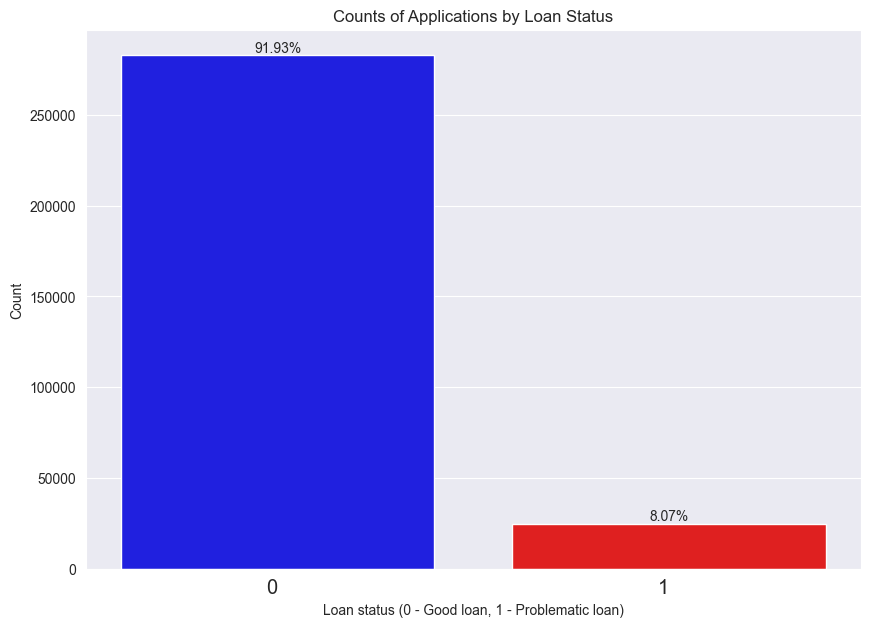

<IPython.core.display.Javascript object>

In [115]:
hf.plot_sns_countplot(application_train_upd, x='TARGET', plot_order=[0, 1],
                      x_label='Loan status (0 - Good loan, 1 - Problematic loan)', y_label='Count', 
                      title='Counts of Applications by Loan Status',
                      xtick_rot=0, percentages=True, palette=['blue', 'red'])  

- There distribution of classes in the target feature is imbalanced. We should keep this in mind during statistical analysis and ML modeling.

### 1.6.2. Distributions of the contract type

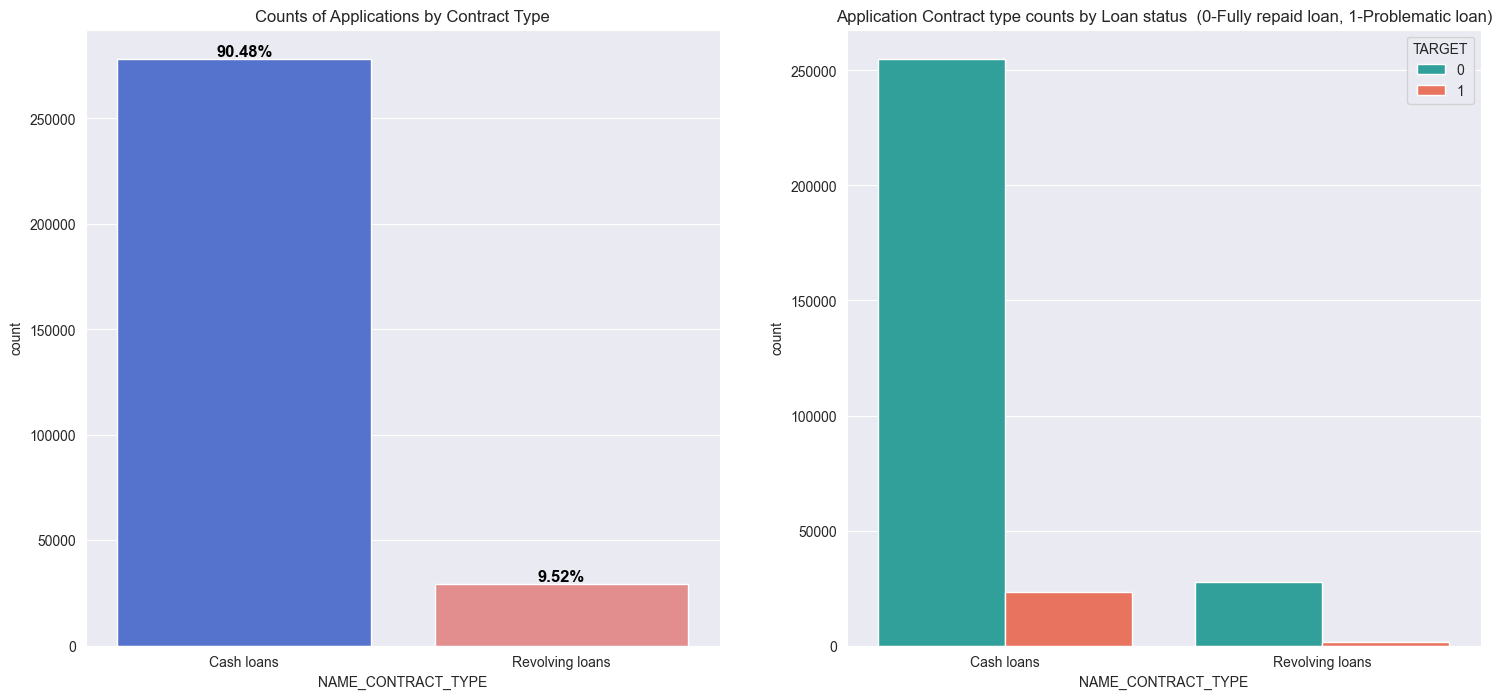

<IPython.core.display.Javascript object>

In [116]:
hf.visualize_double_countplots(application_train_upd, feature='NAME_CONTRACT_TYPE', 
                               hue_feature=application_train_upd['TARGET'].astype('str'),
                               plot_1_title='Counts of Applications by Contract Type',
                               plot_2_title='Application Contract type counts by Loan status  (0-Fully repaid loan, 1-Problematic loan)',
                               x_axis_label_order = ['Cash loans', 'Revolving loans'],
                               left_plot_colors = ["royalblue", "lightcoral"],
                               hue_feature_order=['0', '1'], hue_colors=["lightseagreen", "tomato"], 
                               percentages=True)

In [117]:
pd.crosstab(application_train_upd['NAME_CONTRACT_TYPE'], 
            application_train_upd['TARGET'], 
            normalize='index') * 100

TARGET                      0         1
NAME_CONTRACT_TYPE                     
Cash loans          91.654087  8.345913
Revolving loans     94.521671  5.478329

<IPython.core.display.Javascript object>

### 1.6.3. Distribution of applicants' gender

In [118]:
application_train_upd['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

<IPython.core.display.Javascript object>

- There are no enough observations with people of non-binary gender in this dataset. We will drop these applications for this analysis.

In [119]:
application_train_upd = application_train_upd[application_train_upd['CODE_GENDER'] != 'XNA']

<IPython.core.display.Javascript object>

In [412]:
application_test_upd = application_test_upd[application_test_upd['CODE_GENDER'] != 'XNA']

<IPython.core.display.Javascript object>

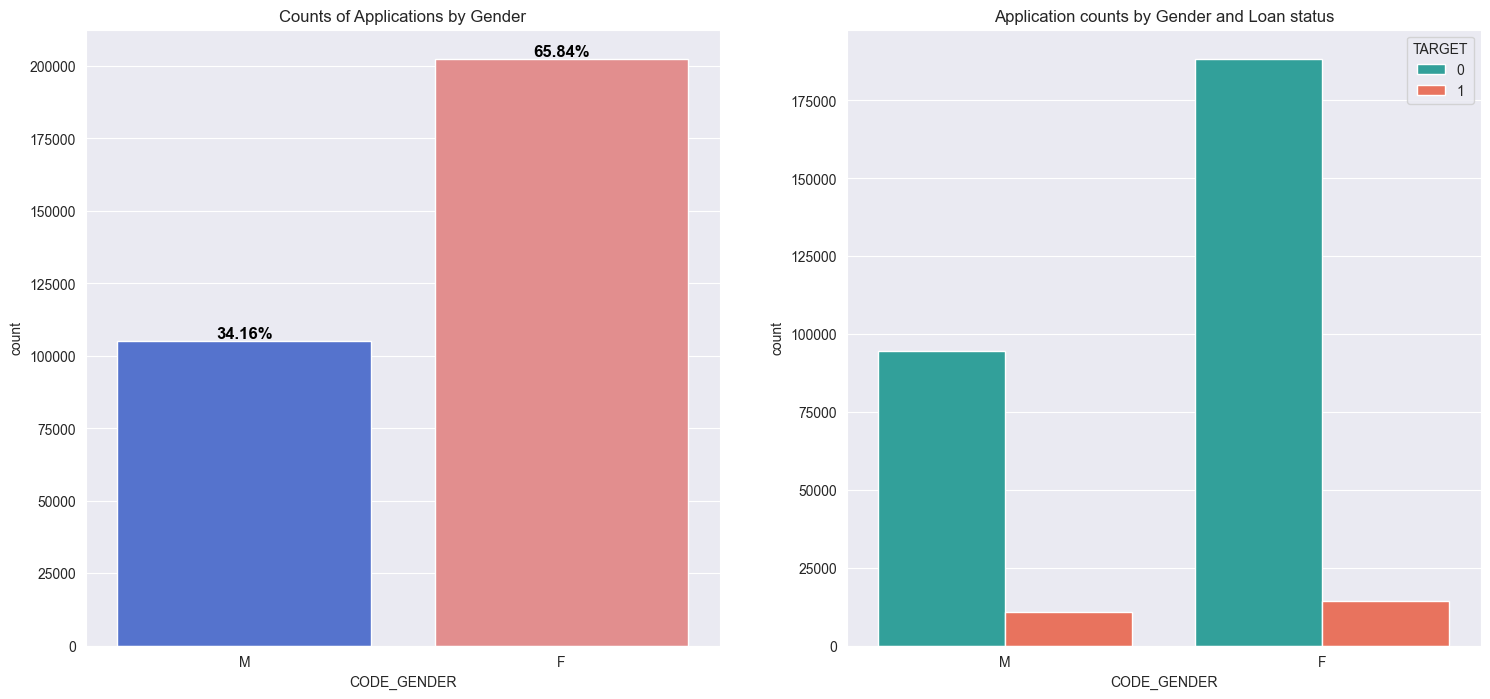

<IPython.core.display.Javascript object>

In [120]:
hf.visualize_double_countplots(application_train_upd, feature='CODE_GENDER', 
                               hue_feature=application_train_upd['TARGET'].astype('str'),
                               plot_1_title='Counts of Applications by Gender',
                               plot_2_title='Application counts by Gender and Loan status',
                               left_plot_colors = ["royalblue", "lightcoral"],
                               hue_feature_order=['0', '1'], hue_colors=["lightseagreen", "tomato"], 
                               percentages=True)

In [121]:
pd.crosstab(application_train_upd['CODE_GENDER'], 
            application_train_upd['TARGET'], 
            normalize='index') * 100

TARGET               0          1
CODE_GENDER                      
F            93.000672   6.999328
M            89.858080  10.141920

<IPython.core.display.Javascript object>

- There are around twice female applicants more than male applicants in this dataset. The share of defaulted loans is higher among male applicants.

### 1.6.4. Type of company present during the application process vs Gender

In [122]:
application_train_upd['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248523
Family              40148
Spouse, partner     11370
Children             3267
Other_B              1770
Not specified        1292
Other_A               866
Group of people       271
Name: count, dtype: int64

<IPython.core.display.Javascript object>

The counts of Other_A and Other_B are not very high. Let's combine Other_A and Other_B classes into one class:

In [123]:
application_train_upd['NAME_TYPE_SUITE'] = application_train_upd['NAME_TYPE_SUITE'].replace({'Other_A': 'Other', 'Other_B': 'Other'})

<IPython.core.display.Javascript object>

In [413]:
application_test_upd['NAME_TYPE_SUITE'] = application_test_upd['NAME_TYPE_SUITE'].replace({'Other_A': 'Other', 'Other_B': 'Other'})

<IPython.core.display.Javascript object>

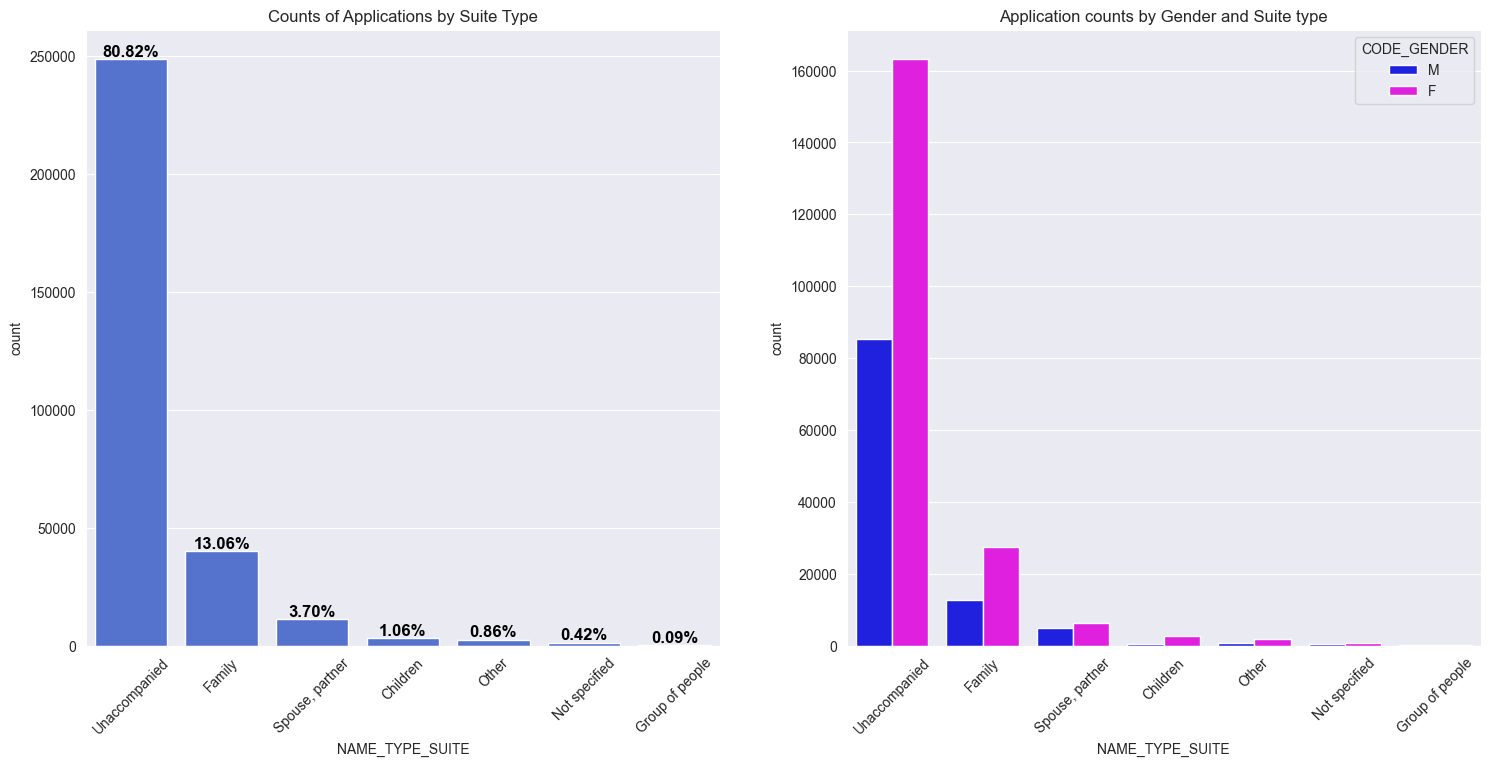

<IPython.core.display.Javascript object>

In [124]:
hf.visualize_double_countplots(application_train_upd, feature='NAME_TYPE_SUITE', 
                               hue_feature=application_train_upd['CODE_GENDER'].astype('str'),
                               plot_1_title='Counts of Applications by Suite Type',
                               plot_2_title='Application counts by Gender and Suite type',
                               left_plot_colors = ["royalblue"],
                               hue_colors=["blue", "magenta"], 
                               xticklabel_rotation=45, 
                               percentages=True)

In [125]:
pd.crosstab(application_train_upd['NAME_TYPE_SUITE'], 
            application_train_upd['CODE_GENDER'], 
            normalize='index') * 100

CODE_GENDER              F          M
NAME_TYPE_SUITE                      
Children         85.460667  14.539333
Family           68.384477  31.615523
Group of people  61.992620  38.007380
Not specified    62.306502  37.693498
Other            66.995448  33.004552
Spouse, partner  55.329815  44.670185
Unaccompanied    65.656297  34.343703

<IPython.core.display.Javascript object>

- The majority of applicants are unaccompanied or accompanied by family members/spouses.

### 1.6.5. Family status vs loan status

In [126]:
application_train_upd['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

<IPython.core.display.Javascript object>

There are only two observations that have unknown family status. We will drop them:

In [127]:
application_train_upd = application_train_upd[application_train_upd['NAME_FAMILY_STATUS'] != 'Unknown']

<IPython.core.display.Javascript object>

In [414]:
application_test_upd = application_test_upd[application_test_upd['NAME_FAMILY_STATUS'] != 'Unknown']

<IPython.core.display.Javascript object>

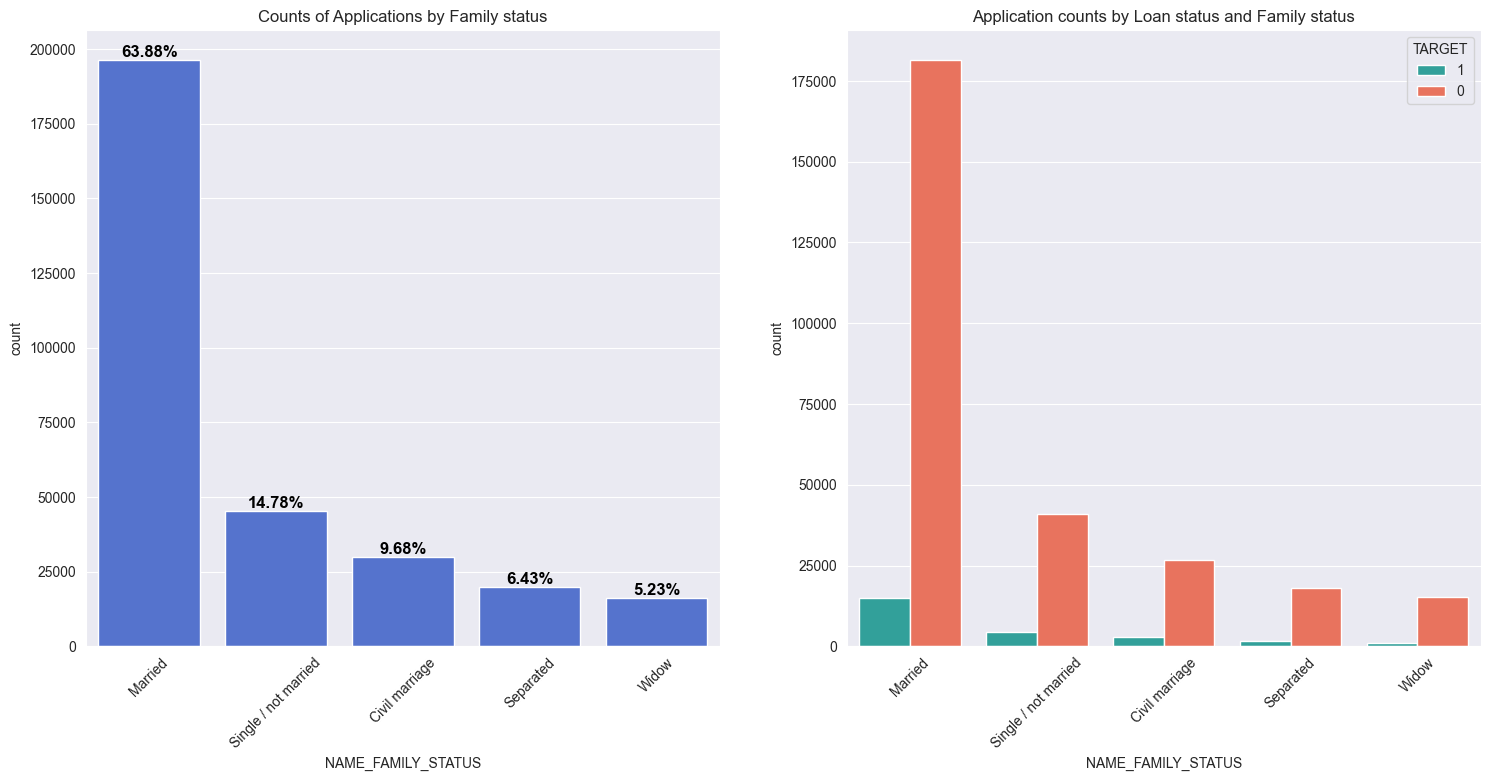

<IPython.core.display.Javascript object>

In [128]:
hue_order = application_train_upd['NAME_FAMILY_STATUS'].value_counts().index.tolist()

hf.visualize_double_countplots(application_train_upd, feature='NAME_FAMILY_STATUS', 
                               hue_feature=application_train_upd['TARGET'].astype('str'),
                               plot_1_title='Counts of Applications by Family status',
                               plot_2_title='Application counts by Loan status and Family status',
                               left_plot_colors = ["royalblue"],
                               x_axis_label_order=hue_order,
                               hue_colors=["lightseagreen", "tomato"], 
                               xticklabel_rotation=45, 
                               percentages=True)

In [129]:
pd.crosstab(application_train_upd['NAME_FAMILY_STATUS'], 
            application_train_upd['TARGET'], 
            normalize='index') * 100

TARGET                        0         1
NAME_FAMILY_STATUS                       
Civil marriage        90.055082  9.944918
Married               92.440016  7.559984
Separated             91.805766  8.194234
Single / not married  90.192325  9.807675
Widow                 94.175783  5.824217

<IPython.core.display.Javascript object>

- The majority of applicants are married or single. The least amount of applicants are separated or widowed.

### 1.6.6. Do applicants who own realty estate are more likely to fully repay their loan?

In [130]:
application_train_upd['FLAG_OWN_REALTY'].value_counts()

FLAG_OWN_REALTY
1    213306
0     94199
Name: count, dtype: int64

<IPython.core.display.Javascript object>

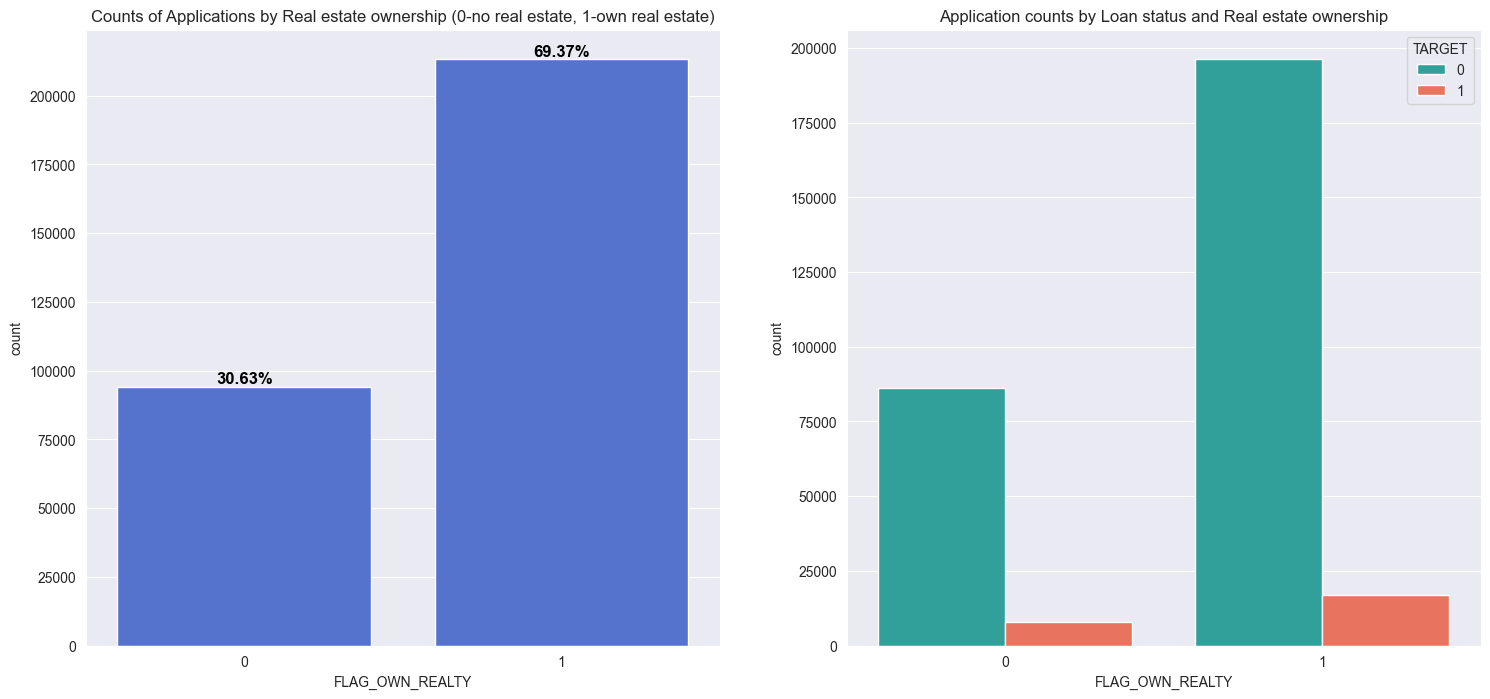

<IPython.core.display.Javascript object>

In [131]:
hf.visualize_double_countplots(application_train_upd, feature='FLAG_OWN_REALTY', 
                               hue_feature=application_train_upd['TARGET'].astype('str'),
                               plot_1_title='Counts of Applications by Real estate ownership (0-no real estate, 1-own real estate)',
                               plot_2_title='Application counts by Loan status and Real estate ownership',
                               left_plot_colors = ["royalblue"],
                               hue_colors=["lightseagreen", "tomato"], 
                               percentages=True)

In [132]:
pd.crosstab(application_train_upd['FLAG_OWN_REALTY'], 
            application_train_upd['TARGET'], 
            normalize='index') * 100

TARGET                   0         1
FLAG_OWN_REALTY                     
0                91.675071  8.324929
1                92.038199  7.961801

<IPython.core.display.Javascript object>

- The majority of applicants own real estate. There seems to be no significant association between the realty ownership and the loan status.

### 1.6.7. What are the distributions of the income/education/occupation types and the last contract status? How are the distributions different for good and problematic loans?

NAME_INCOME_TYPE


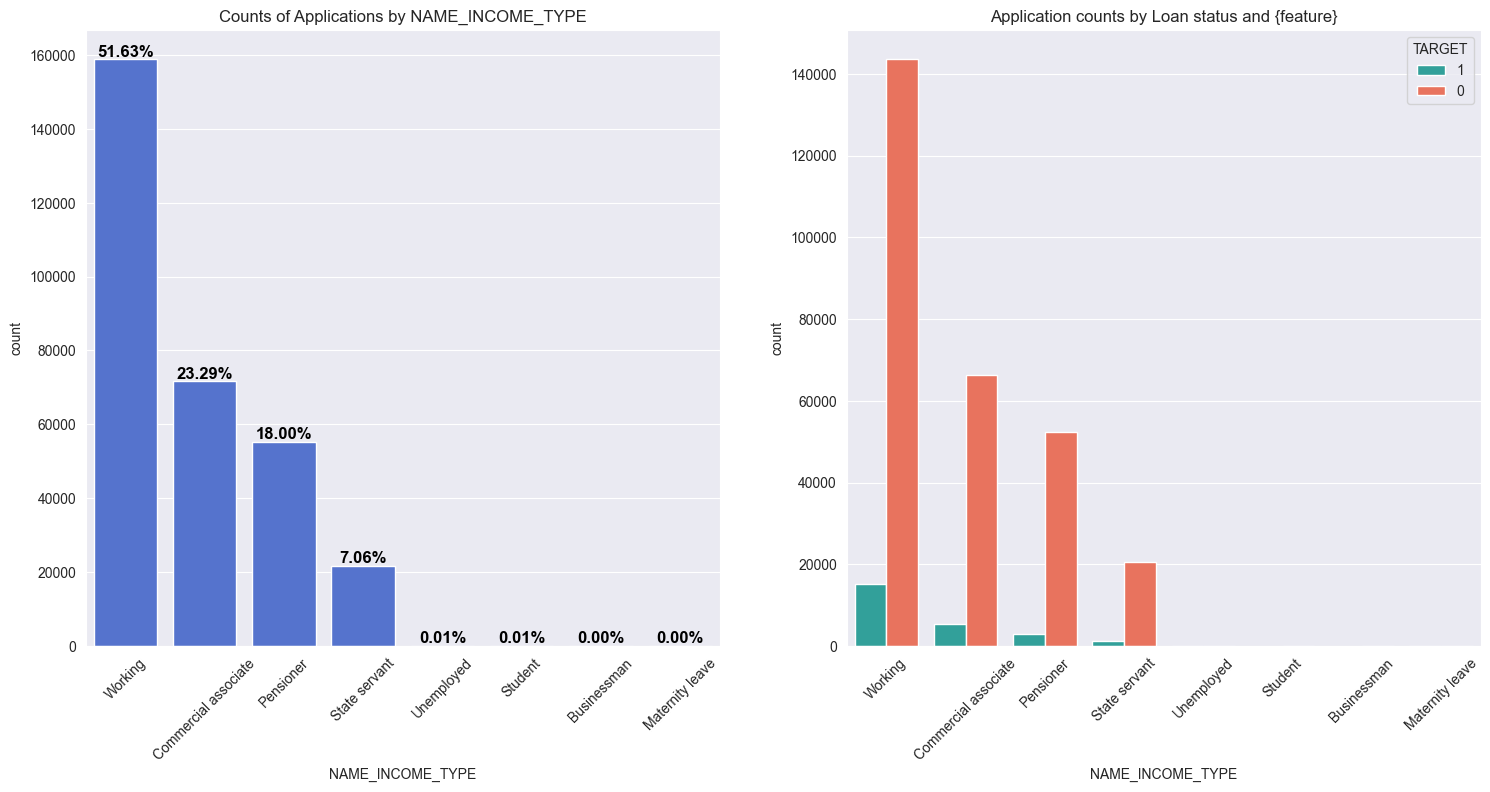

TARGET                         0          1
NAME_INCOME_TYPE                           
Businessman           100.000000   0.000000
Commercial associate   92.515430   7.484570
Maternity leave        60.000000  40.000000
Pensioner              94.613634   5.386366
State servant          94.245035   5.754965
Student               100.000000   0.000000
Unemployed             63.636364  36.363636
Working                90.411347   9.588653
--------------------------------------------------
NAME_EDUCATION_TYPE


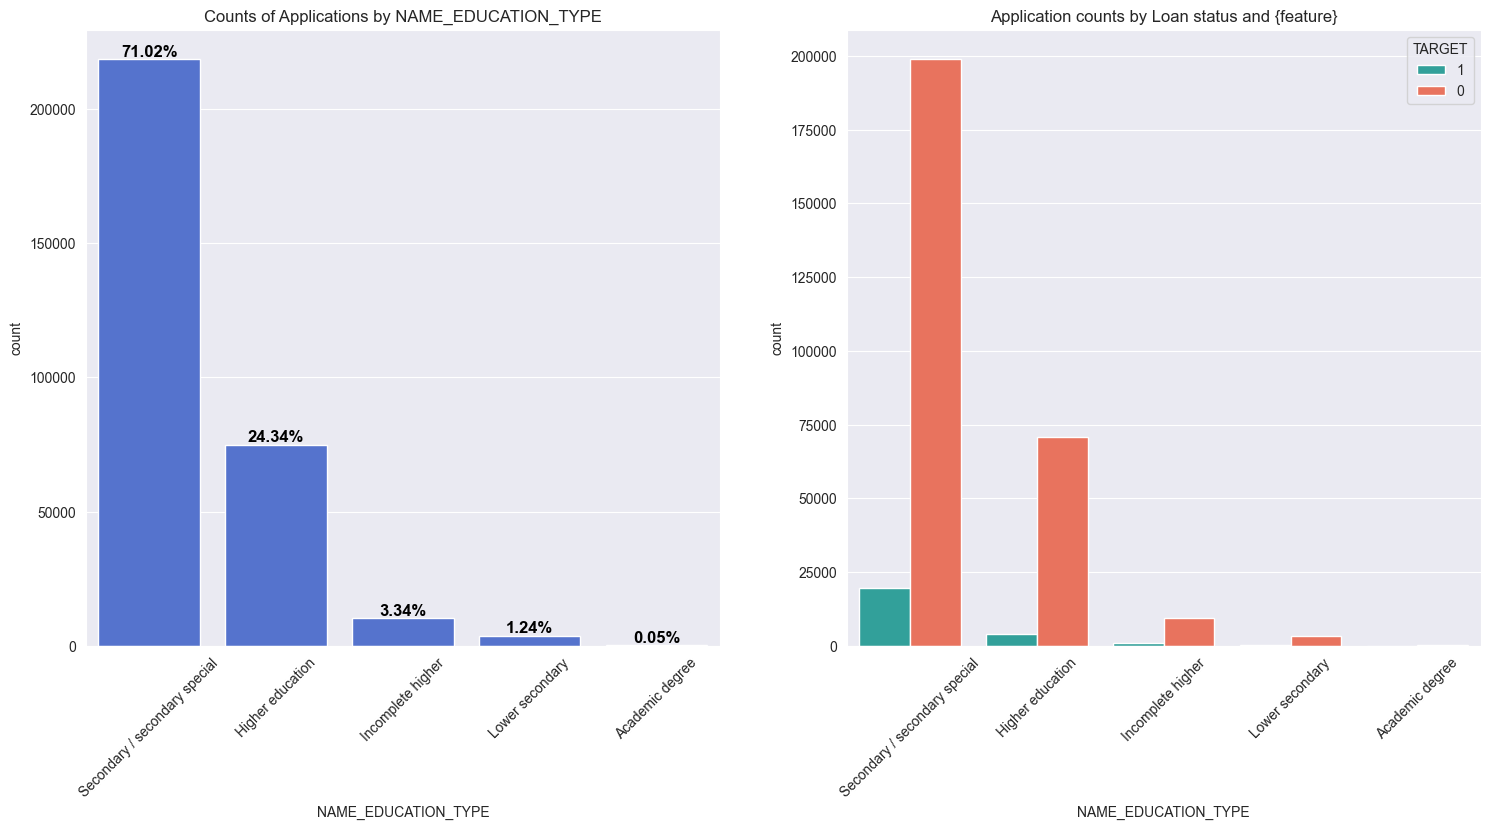

TARGET                                 0          1
NAME_EDUCATION_TYPE                                
Academic degree                98.170732   1.829268
Higher education               94.644742   5.355258
Incomplete higher              91.514208   8.485792
Lower secondary                89.069463  10.930537
Secondary / secondary special  91.059989   8.940011
--------------------------------------------------
OCCUPATION_TYPE


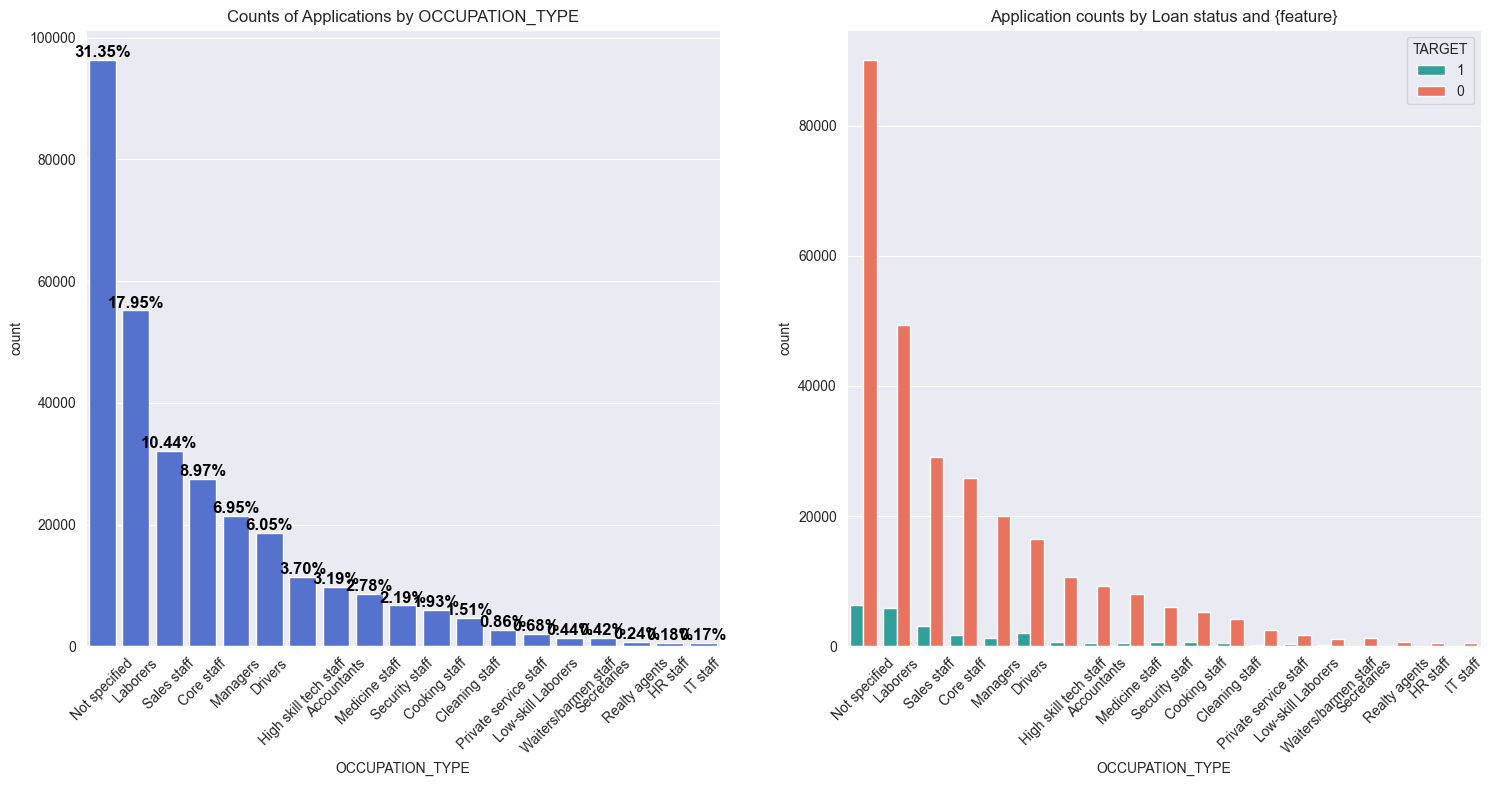

TARGET                         0          1
OCCUPATION_TYPE                            
Accountants            95.169181   4.830819
Cleaning staff         90.393295   9.606705
Cooking staff          89.556004  10.443996
Core staff             93.695818   6.304182
Drivers                88.673870  11.326130
HR staff               93.605684   6.394316
High skill tech staff  93.840070   6.159930
IT staff               93.536122   6.463878
Laborers               89.421230  10.578770
Low-skill Laborers     82.839388  17.160612
Managers               93.785681   6.214319
Medicine staff         93.299754   6.700246
Not specified          93.486809   6.513191
Private service staff  93.401207   6.598793
Realty agents          92.143808   7.856192
Sales staff            90.368201   9.631799
Secretaries            92.950192   7.049808
Security staff         89.257551  10.742449
Waiters/barmen staff   88.724036  11.275964
--------------------------------------------------
LAST_CONTRACT_STATUS


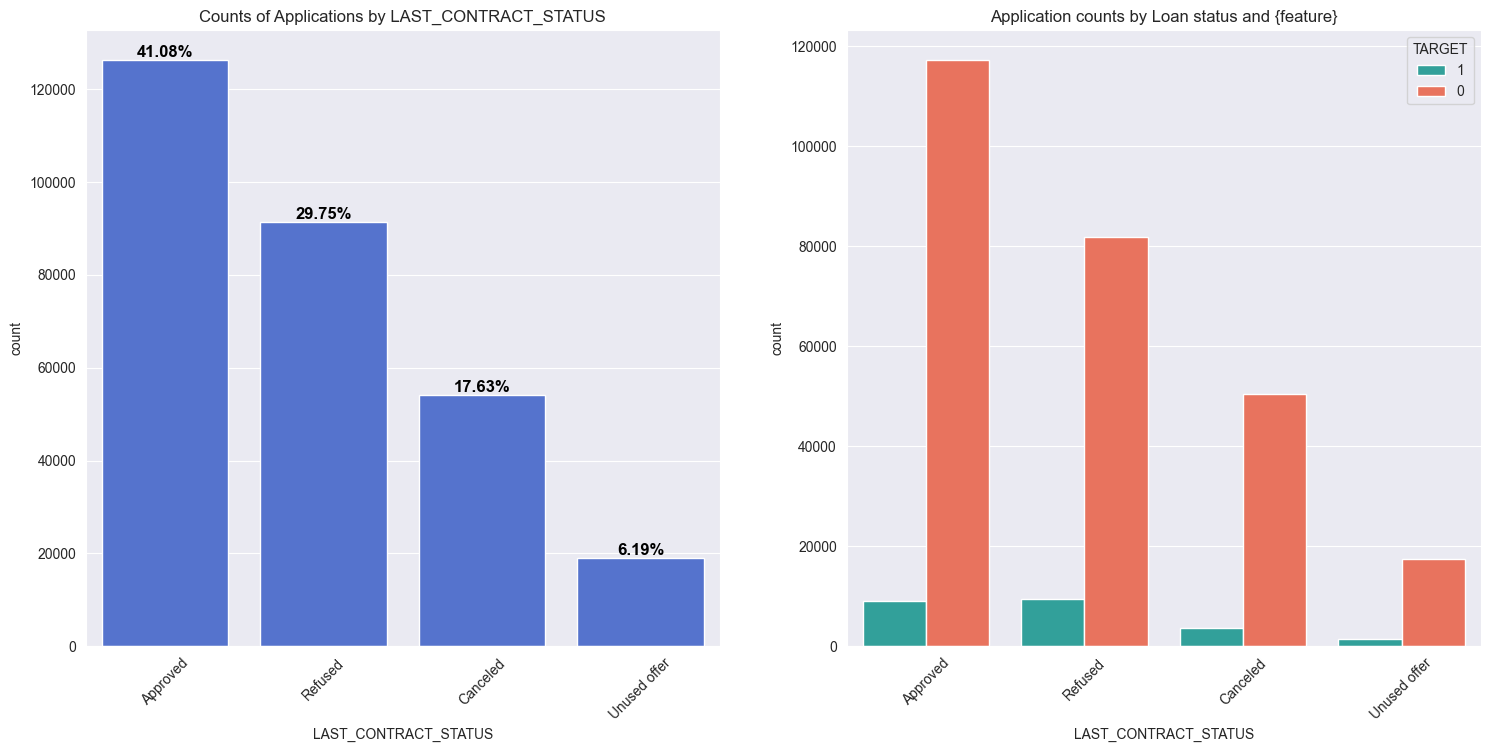

TARGET                        0          1
LAST_CONTRACT_STATUS                      
Approved              92.866190   7.133810
Canceled              93.124182   6.875818
Refused               89.560854  10.439146
Unused offer          91.824725   8.175275
--------------------------------------------------
REGION_RATING_CLIENT


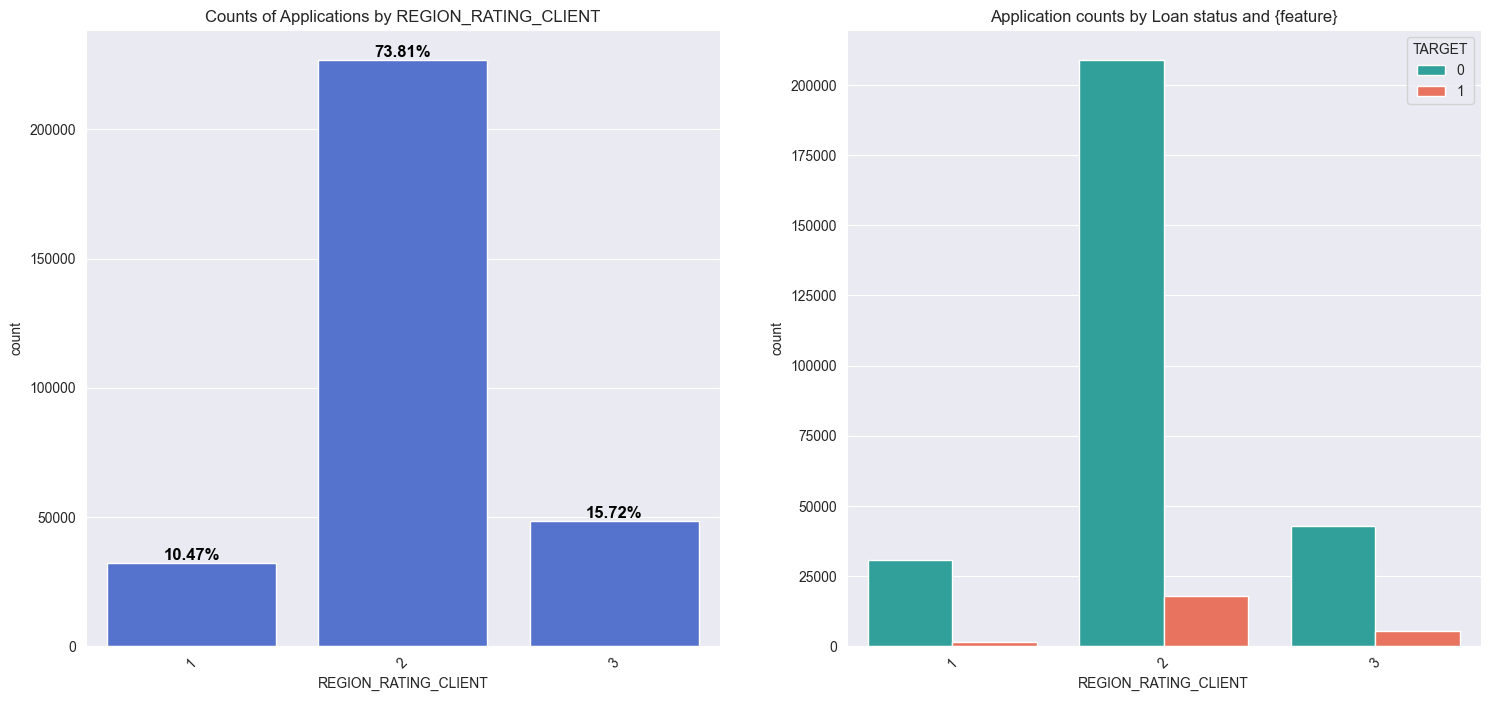

TARGET                        0          1
REGION_RATING_CLIENT                      
1                     95.179675   4.820325
2                     92.110724   7.889276
3                     88.896936  11.103064
--------------------------------------------------


<IPython.core.display.Javascript object>

In [133]:
feat_list = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
             'OCCUPATION_TYPE', 'LAST_CONTRACT_STATUS', 
             'REGION_RATING_CLIENT']

for feature in feat_list:
    print(feature)
    if feature == 'REGION_RATING_CLIENT':
        hue_order = [1, 2, 3]
    else:
        hue_order = application_train_upd[feature].value_counts().index.tolist()
    hf.visualize_double_countplots(application_train_upd, feature=feature, 
                               hue_feature=application_train_upd['TARGET'].astype('str'),
                               plot_1_title=f'Counts of Applications by {feature}',
                               plot_2_title='Application counts by Loan status and {feature}',
                               left_plot_colors = ["royalblue"],
                               x_axis_label_order=hue_order,
                               xticklabel_rotation=45,
                               hue_colors=["lightseagreen", "tomato"], 
                               percentages=True)
    print(pd.crosstab(application_train_upd[feature], 
                      application_train_upd['TARGET'], 
                      normalize='index') * 100)
    print("-"*50)

In [134]:
print(pd.crosstab(application_train_upd['TARGET'], 
                  application_train_upd['LAST_CONTRACT_STATUS'], 
                  normalize='index') * 100)

LAST_CONTRACT_STATUS   Approved   Canceled    Refused  Unused offer
TARGET                                                             
0                     43.904374  18.895767  30.659262      6.540598
1                     37.794087  15.634305  40.046131      6.525477


<IPython.core.display.Javascript object>

- The majority of applicants are working, are commercial associates or pensioners. There are very few applicants who are students, unemployed, businessmen, or are on maternity leave.
- The most popular education levels among the applicants are Secondary/secondary special and higher education.
- The majority of applicants haven't specified their occupation type. Among the ones who have specified this information, the majority of applicants are laborers, sales and care staff.
- Regarding the previous loans statuses, the applicants who have been refused a loan before, had higher share of problematic current loans.
- The majority of applicants live in medium-rated regions (based on Home Credit rating system). Applicants coming from regions with rating 3 have the highest share of problematic loans.

### 1.6.8. What are the distributions of the credit amount of the loan for different income levels, annuity levels and region population sizes?  

**Additional notes:**
- REGION_POPULATION_RELATIVE means normalized population of region where client lives (higher number means the client lives in more populated region).

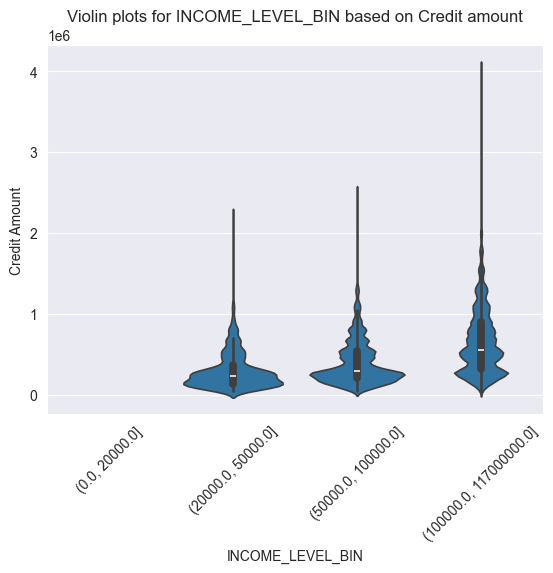

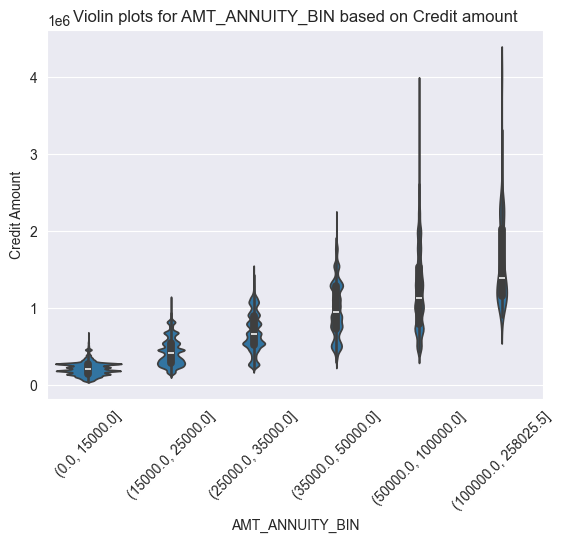

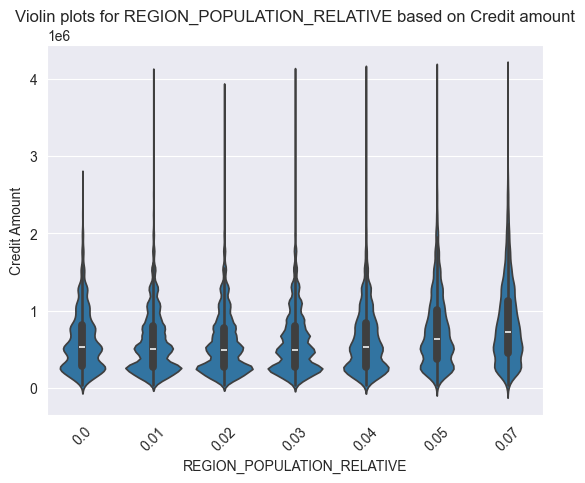

<IPython.core.display.Javascript object>

In [135]:
selected_columns = ['INCOME_LEVEL_BIN', 'AMT_ANNUITY_BIN', 'REGION_POPULATION_RELATIVE']

for i, c in enumerate(selected_columns):
    plt.figure(i)
    sns.violinplot(
        y="AMT_CREDIT",
        x=f"{c}",
        data=application_train_upd,
    )

    plt.title(f"Violin plots for {c} based on Credit amount")
    plt.ylabel("Credit Amount")
    plt.xlabel(f"{c}")
    
    plt.xticks(rotation=45)

plt.show()

- Applicants with a higher income level seem to have a higher credit amount of the loan.
- Higher credit amount of the loan is seemingly associated with a higher annuity amount.
- Applicants from more populated regions seem to have a bit higher credit amount of the loan. 

### 1.6.9. What are the distributions of LOAN_INCOME_RATIO, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, AGE, YEARS_EMPLOYED, CNT_FAM_MEMBERS, AVG_DOWN_PAYMENT, NUM_PAST_DUE_INSTALL, and APPS_APPROVAL_RATE? Are the distributions different for good and problematic loans?

**Additional notes:**
- For more informative visualizations, we will scale and trim the data beforehand.

In [136]:
selected_columns_num = ['LOAN_INCOME_RATIO', 'AMT_CREDIT', 'AMT_ANNUITY', 
                           'AMT_GOODS_PRICE', 'AGE', 'YEARS_EMPLOYED', 
                           'CNT_FAM_MEMBERS', 'AVG_DOWN_PAYMENT', 'NUM_PAST_DUE_INSTALL', 
                           'APPS_APPROVAL_RATE']

<IPython.core.display.Javascript object>

In [137]:
def trim_outliers(df, trim_percent=0.2):

    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - trim_percent * iqr
    upper_bound = q3 + trim_percent * iqr

    trim_df = df.apply(lambda x: x.clip(lower=lower_bound[x.name], upper=upper_bound[x.name]))

    return trim_df

<IPython.core.display.Javascript object>

In [138]:
scaler = MinMaxScaler()
app_train_upd_for_violin = application_train_upd[(selected_columns_num + ['TARGET'])]
app_train_upd_for_violin.replace([np.inf, -np.inf], np.nan, inplace=True)
app_train_upd_for_violin.fillna(app_train_upd_for_violin.median(), inplace=True)

normalized_df_violin = pd.DataFrame(scaler.fit_transform(app_train_upd_for_violin), columns=app_train_upd_for_violin.columns)
selected_col_norm = normalized_df_violin.loc[:, ~normalized_df_violin.columns.isin(['TARGET'])]
trimmed_df = trim_outliers(selected_col_norm)

<IPython.core.display.Javascript object>

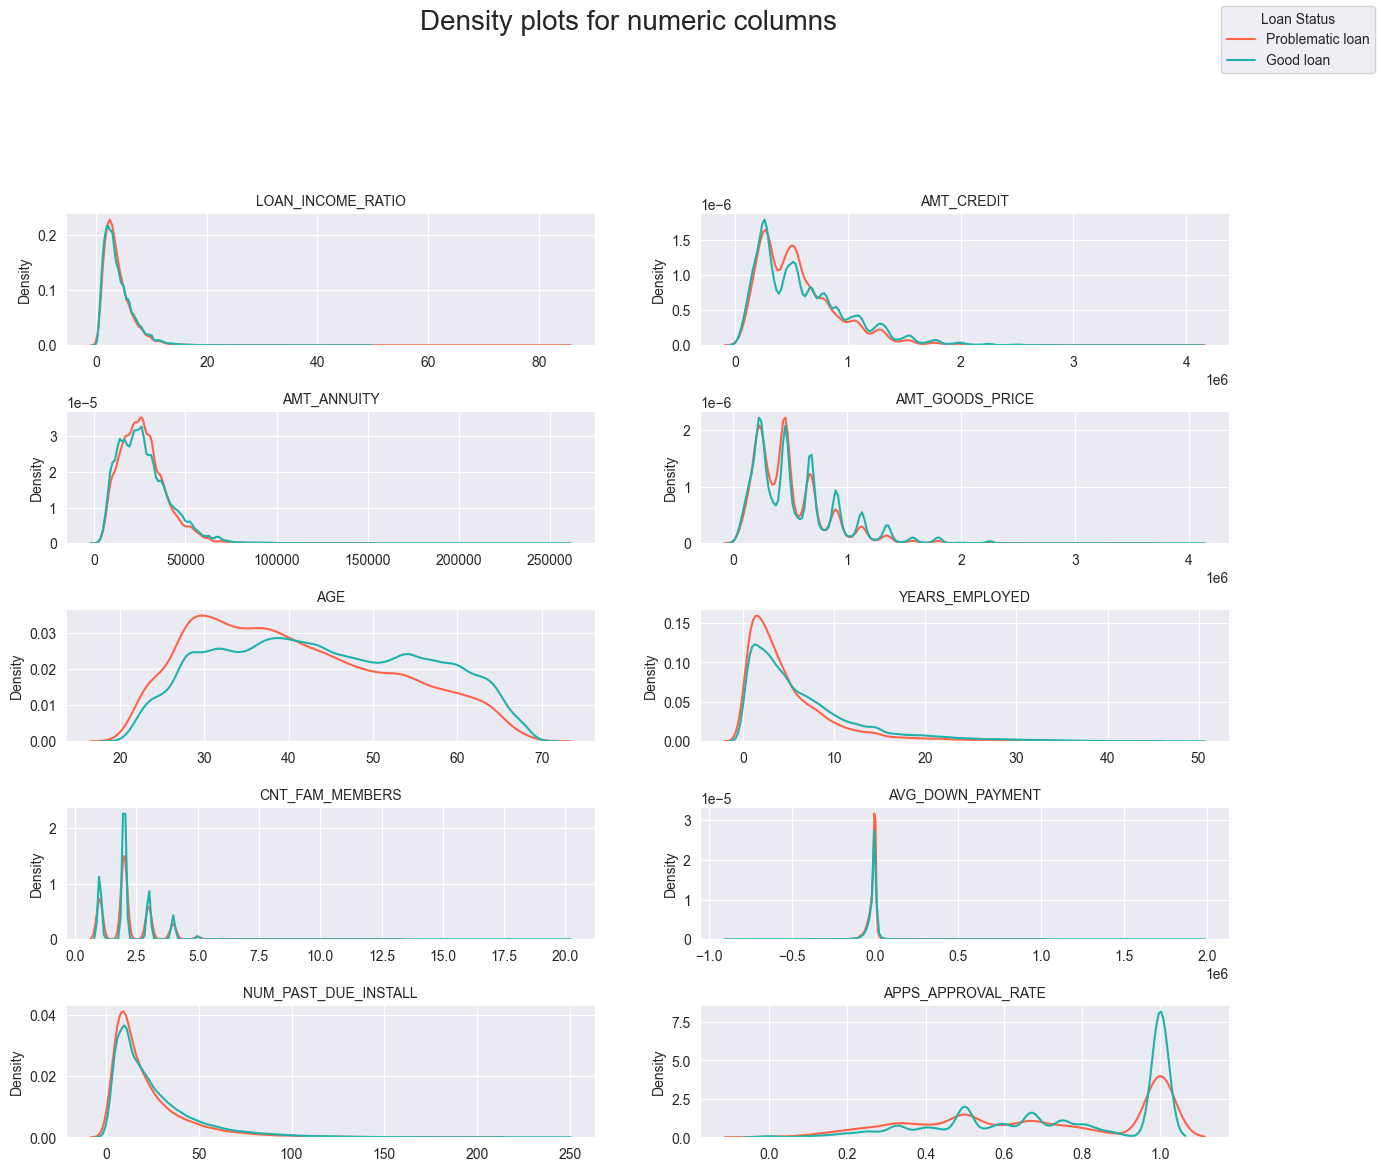

<IPython.core.display.Javascript object>

In [139]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5) 

legend_labels = {0: 'Good loan', 1: 'Problematic loan'}
line_colors = {0: 'lightseagreen', 1: 'tomato'}

for col, ax in zip(trimmed_df.columns, axes.flatten()):
    for target_value in application_train_upd['TARGET'].unique():
        sns.kdeplot(application_train_upd[application_train_upd['TARGET'] == target_value][col], 
                    ax=ax, label=legend_labels[target_value], color=line_colors[target_value])
    
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Loan Status", loc='upper right')

fig.suptitle("Density plots for numeric columns", fontsize=20, y=1.05)

plt.show()

- Most of the columns of interest seem to be not normally distributed. 
- The majority of the features have similar distributions for good and problematic loans. 
- Many applicants with problematic loans seems to be a bit younger.

## 1.7. Correlations and Associations

##### Main insights and observations:
- There are multiple highly correlated features. We've performed feature reduction to avoid multicollinearity.
- Some of the features are correlated due to structurally missing values in some groups.

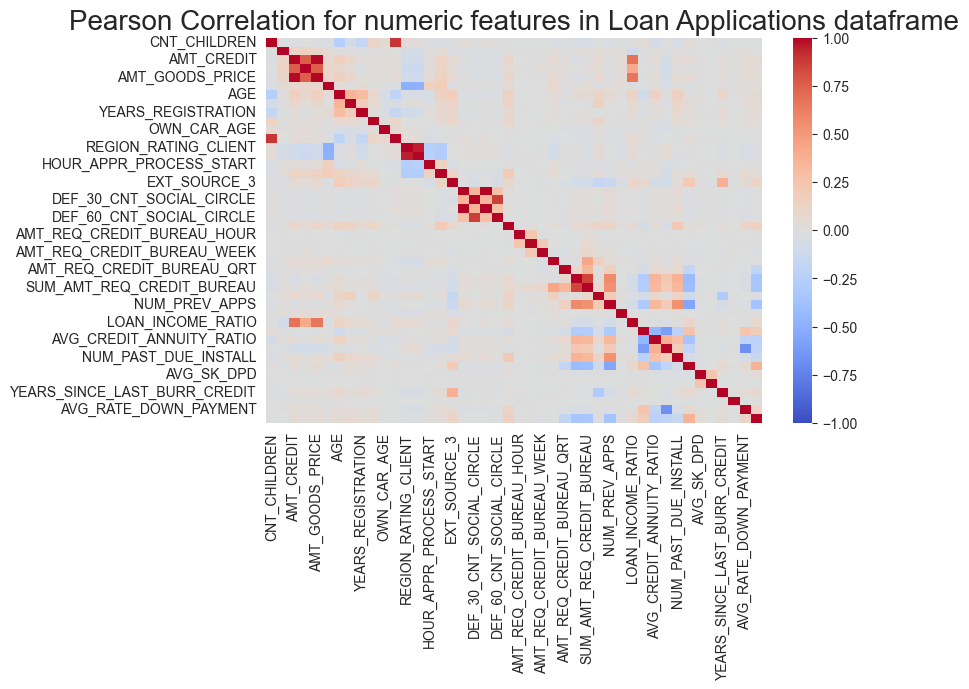

<IPython.core.display.Javascript object>

In [140]:
plt.figure(figsize=(8, 5))
plt.title("Pearson Correlation for numeric features in Loan Applications dataframe", fontsize=20)
ax = sns.heatmap(application_train_upd.dropna().corr(numeric_only=True), 
                 annot=False, vmin=-1, vmax=1, cmap="coolwarm")

In [141]:
strong_corr_accepted = hf.get_strong_corr_features(application_train_upd.dropna(), 
                                                   method='pearson', 
                                                   threshold=0.3)
strong_corr_accepted

var_1                       var_2      corr
0       OBS_60_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE  0.998548
1                AMT_GOODS_PRICE                  AMT_CREDIT  0.985868
2    REGION_RATING_CLIENT_W_CITY        REGION_RATING_CLIENT  0.950514
3                CNT_FAM_MEMBERS                CNT_CHILDREN  0.898162
4       DEF_60_CNT_SOCIAL_CIRCLE    DEF_30_CNT_SOCIAL_CIRCLE  0.863272
5      SUM_AMT_REQ_CREDIT_BUREAU  AMT_REQ_CREDIT_BUREAU_YEAR  0.845282
6                AMT_GOODS_PRICE                 AMT_ANNUITY  0.763791
7                    AMT_ANNUITY                  AMT_CREDIT  0.761768
8              LOAN_INCOME_RATIO                  AMT_CREDIT  0.678007
9              LOAN_INCOME_RATIO             AMT_GOODS_PRICE  0.658618
10                 NUM_PREV_APPS  AMT_REQ_CREDIT_BUREAU_YEAR  0.577922
11                 NUM_PREV_APPS   SUM_AMT_REQ_CREDIT_BUREAU  0.543901
12          NUM_PAST_DUE_INSTALL               NUM_PREV_APPS  0.540759
13     SUM_AMT_REQ_CREDIT_BUREAU   AMT_REQ_CREDIT_BUREAU_MON  0.432978
14             LOAN_INCOME_RATIO                 AMT_ANNUITY  0.415639
15  YEARS_SINCE_LAST_BURR_CREDIT                EXT_SOURCE_3  0.380985
16        AVG_CREDIT_GOODS_RATIO    AVG_CREDIT_ANNUITY_RATIO  0.375369
17          YEARS_SINCE_LAST_APP          APPS_APPROVAL_RATE  0.362126
18          NUM_PAST_DUE_INSTALL  AMT_REQ_CREDIT_BUREAU_YEAR  0.360513
19                YEARS_EMPLOYED                         AGE  0.353200
20      OBS_60_CNT_SOCIAL_CIRCLE    DEF_30_CNT_SOCIAL_CIRCLE  0.347900
21      DEF_30_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE  0.345794
22      AVG_CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_YEAR  0.344402
23     SUM_AMT_REQ_CREDIT_BUREAU   AMT_REQ_CREDIT_BUREAU_QRT  0.340016
24          NUM_PAST_DUE_INSTALL   SUM_AMT_REQ_CREDIT_BUREAU  0.335770
25      AVG_CREDIT_ANNUITY_RATIO               NUM_PREV_APPS  0.334523
26      AVG_CREDIT_ANNUITY_RATIO   SUM_AMT_REQ_CREDIT_BUREAU  0.325508
27              AVG_DOWN_PAYMENT               NUM_PREV_APPS -0.309029
28          YEARS_SINCE_LAST_APP   SUM_AMT_REQ_CREDIT_BUREAU -0.341075
29          YEARS_SINCE_LAST_APP  AMT_REQ_CREDIT_BUREAU_YEAR -0.345711
30            APPS_APPROVAL_RATE    AVG_CREDIT_ANNUITY_RATIO -0.357265
31          YEARS_SINCE_LAST_APP               NUM_PREV_APPS -0.360644
32            APPS_APPROVAL_RATE   SUM_AMT_REQ_CREDIT_BUREAU -0.406069
33            APPS_APPROVAL_RATE  AMT_REQ_CREDIT_BUREAU_YEAR -0.419951
34      AVG_CREDIT_ANNUITY_RATIO            AVG_DOWN_PAYMENT -0.460457
35   REGION_RATING_CLIENT_W_CITY  REGION_POPULATION_RELATIVE -0.487125
36          REGION_RATING_CLIENT  REGION_POPULATION_RELATIVE -0.493431
37            APPS_APPROVAL_RATE               NUM_PREV_APPS -0.557278
38        AVG_CREDIT_GOODS_RATIO            AVG_DOWN_PAYMENT -0.597229
39         AVG_RATE_DOWN_PAYMENT      AVG_CREDIT_GOODS_RATIO -0.672017

<IPython.core.display.Javascript object>

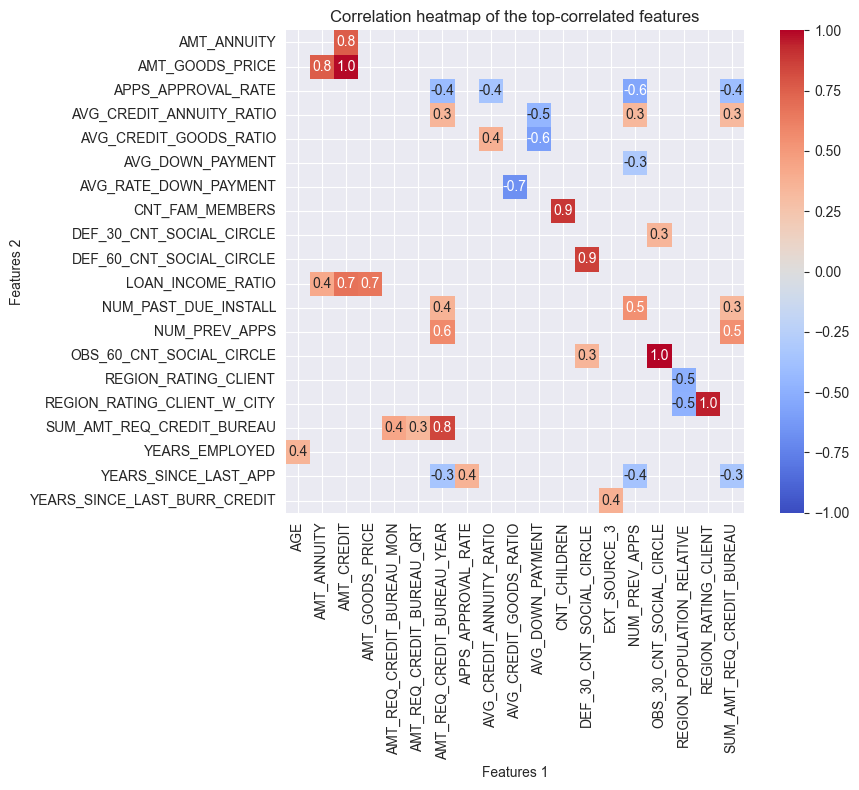

<IPython.core.display.Javascript object>

In [142]:
correlation_matrix = strong_corr_accepted.pivot(
    index=["var_1"], columns=["var_2"], values="corr"
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", 
    square=True, center=0, fmt=".1f",
    vmin=-1, vmax=1, 
)

plt.title("Correlation heatmap of the top-correlated features")
plt.xlabel("Features 1")  
plt.ylabel("Features 2")  

plt.tight_layout()

plt.show()

In [143]:
most_corr_accepted = hf.get_strong_corr_features(application_train_upd.dropna(), 
                                                   method='pearson', 
                                                   threshold=0.7)

most_corr_accepted.groupby(by=['var_1', 'var_2'])\
                  .min().sort_values(by='corr', ascending=False)

corr
var_1                       var_2                               
OBS_60_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE    0.998548
AMT_GOODS_PRICE             AMT_CREDIT                  0.985868
REGION_RATING_CLIENT_W_CITY REGION_RATING_CLIENT        0.950514
CNT_FAM_MEMBERS             CNT_CHILDREN                0.898162
DEF_60_CNT_SOCIAL_CIRCLE    DEF_30_CNT_SOCIAL_CIRCLE    0.863272
SUM_AMT_REQ_CREDIT_BUREAU   AMT_REQ_CREDIT_BUREAU_YEAR  0.845282
AMT_GOODS_PRICE             AMT_ANNUITY                 0.763791
AMT_ANNUITY                 AMT_CREDIT                  0.761768

<IPython.core.display.Javascript object>

We will drop some of the highly correlated features:

In [267]:
cols_to_drop = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE', 
                'REGION_RATING_CLIENT', 'CNT_CHILDREN', 'SUM_AMT_REQ_CREDIT_BUREAU', 'AMT_ANNUITY']

application_train_upd_reduced = application_train_upd.drop(cols_to_drop, axis=1)

<IPython.core.display.Javascript object>

In [429]:
cols_to_drop = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE', 
                'REGION_RATING_CLIENT', 'CNT_CHILDREN', 'SUM_AMT_REQ_CREDIT_BUREAU', 'AMT_ANNUITY']

application_test_upd_reduced = application_test_upd.drop(cols_to_drop, axis=1)

<IPython.core.display.Javascript object>

#### Theil's U and Cramer's V Association scores for categorical features

In [268]:
cat_cols_app_train = application_train_upd_reduced.select_dtypes(include=['object', 
                                                            'category', 
                                                            'bool']).columns.tolist()
categorical_cols_app_train = application_train_upd_reduced[cat_cols_app_train]

<IPython.core.display.Javascript object>

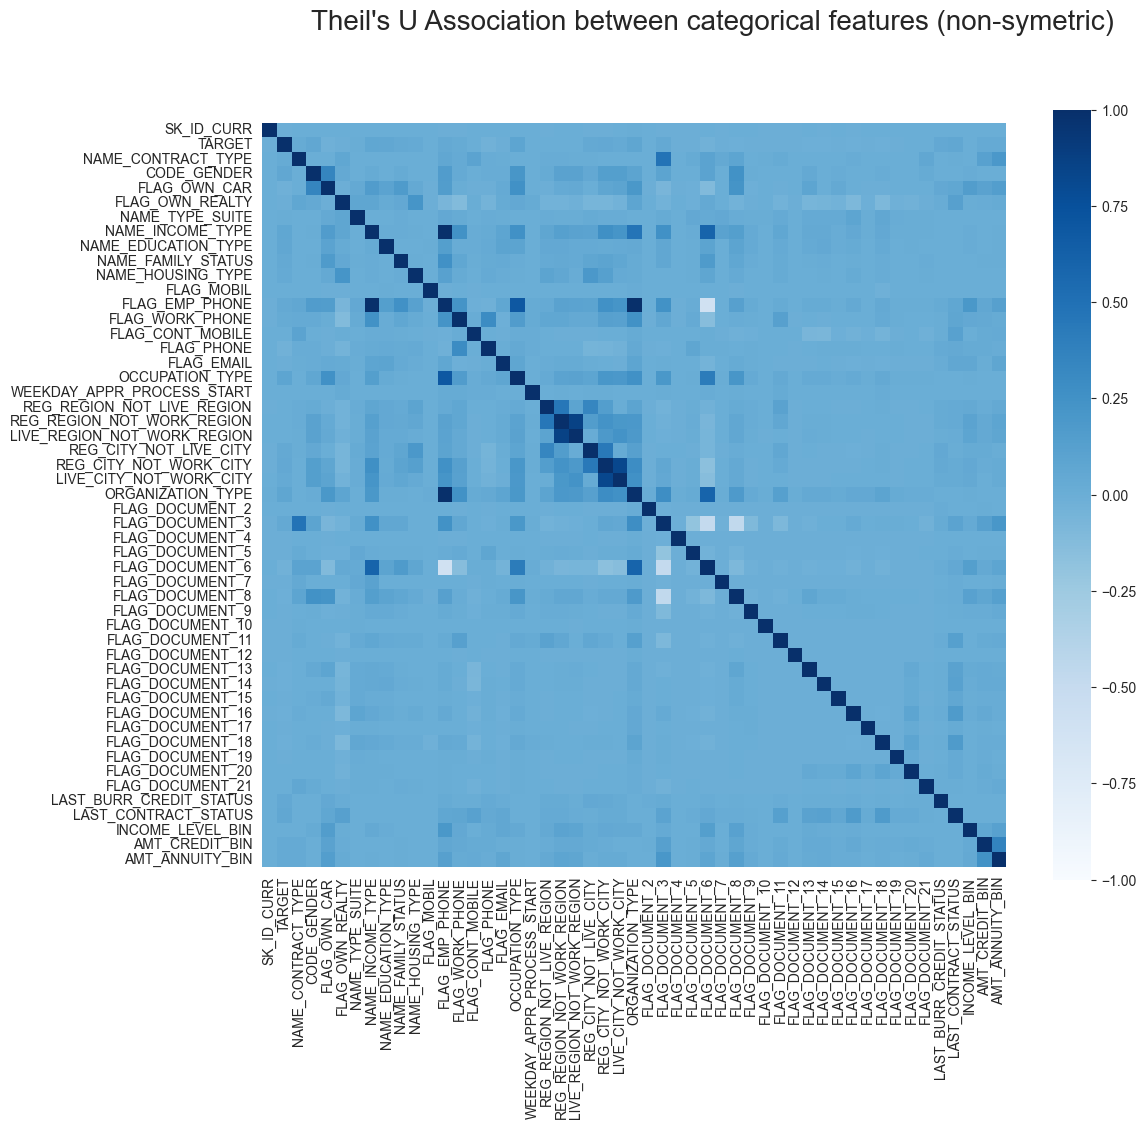

<IPython.core.display.Javascript object>

In [204]:
fig, ax = plt.subplots(figsize = (12, 10))
fig.suptitle("Theil's U Association between categorical features (non-symetric)", fontsize=20)

theils_u = associations(categorical_cols_app_train,
             nom_nom_assoc = 'theil',
             ax = ax,
             cmap = "Blues",
             annot=False)

In [205]:
correlation_df = theils_u['corr']

threshold = 0.5
upper_triangle = correlation_df.where(np.triu(np.ones(correlation_df.shape), k=1).astype(np.bool_))
top_correlations = upper_triangle.unstack().sort_values(ascending=False)
filtered_correlations = top_correlations[(abs(top_correlations) > threshold) & (abs(top_correlations) < 1)]
top_corr_df = pd.DataFrame(filtered_correlations, columns=['corr_score_theilsu'])
top_corr_df = top_corr_df.reset_index()
top_corr_df.columns = ['feature_1', 'feature_2', 'corr_score_theilsu']
top_corr_df

feature_1                   feature_2  corr_score_theilsu
0            ORGANIZATION_TYPE              FLAG_EMP_PHONE            0.999868
1               FLAG_EMP_PHONE            NAME_INCOME_TYPE            0.999759
2  LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION            0.860618
3      LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY            0.825572
4              OCCUPATION_TYPE              FLAG_EMP_PHONE            0.693455
5              FLAG_DOCUMENT_6           ORGANIZATION_TYPE            0.597932
6              FLAG_DOCUMENT_6            NAME_INCOME_TYPE            0.597916
7              FLAG_DOCUMENT_6              FLAG_EMP_PHONE           -0.597731

<IPython.core.display.Javascript object>

In [206]:
for col in ['LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 
            'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY']:
    print(col)
    print(home_credit_cols_description[(home_credit_cols_description.Table == 'application_{train|test}.csv') 
          & (home_credit_cols_description.Row == col)]['Description'].values)

LIVE_REGION_NOT_WORK_REGION
["Flag if client's contact address does not match work address (1=different, 0=same, at region level)"]
REG_REGION_NOT_WORK_REGION
["Flag if client's permanent address does not match work address (1=different, 0=same, at region level)"]
LIVE_CITY_NOT_WORK_CITY
["Flag if client's contact address does not match work address (1=different, 0=same, at city level)"]
REG_CITY_NOT_WORK_CITY
["Flag if client's permanent address does not match work address (1=different, 0=same, at city level)"]


<IPython.core.display.Javascript object>

We can see that some of the highly associated features denote similar information. We will drop some of the columns:

In [269]:
cols_to_drop = ['REG_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 
                'REG_CITY_NOT_WORK_CITY']

application_train_upd_reduced = application_train_upd_reduced.drop(cols_to_drop, axis=1)
categorical_cols_app_train = categorical_cols_app_train.drop(cols_to_drop, axis=1)

<IPython.core.display.Javascript object>

In [430]:
cols_to_drop = ['REG_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 
                'REG_CITY_NOT_WORK_CITY']

application_test_upd_reduced = application_test_upd_reduced.drop(cols_to_drop, axis=1)

<IPython.core.display.Javascript object>

Let's investigate some of the associations between features:

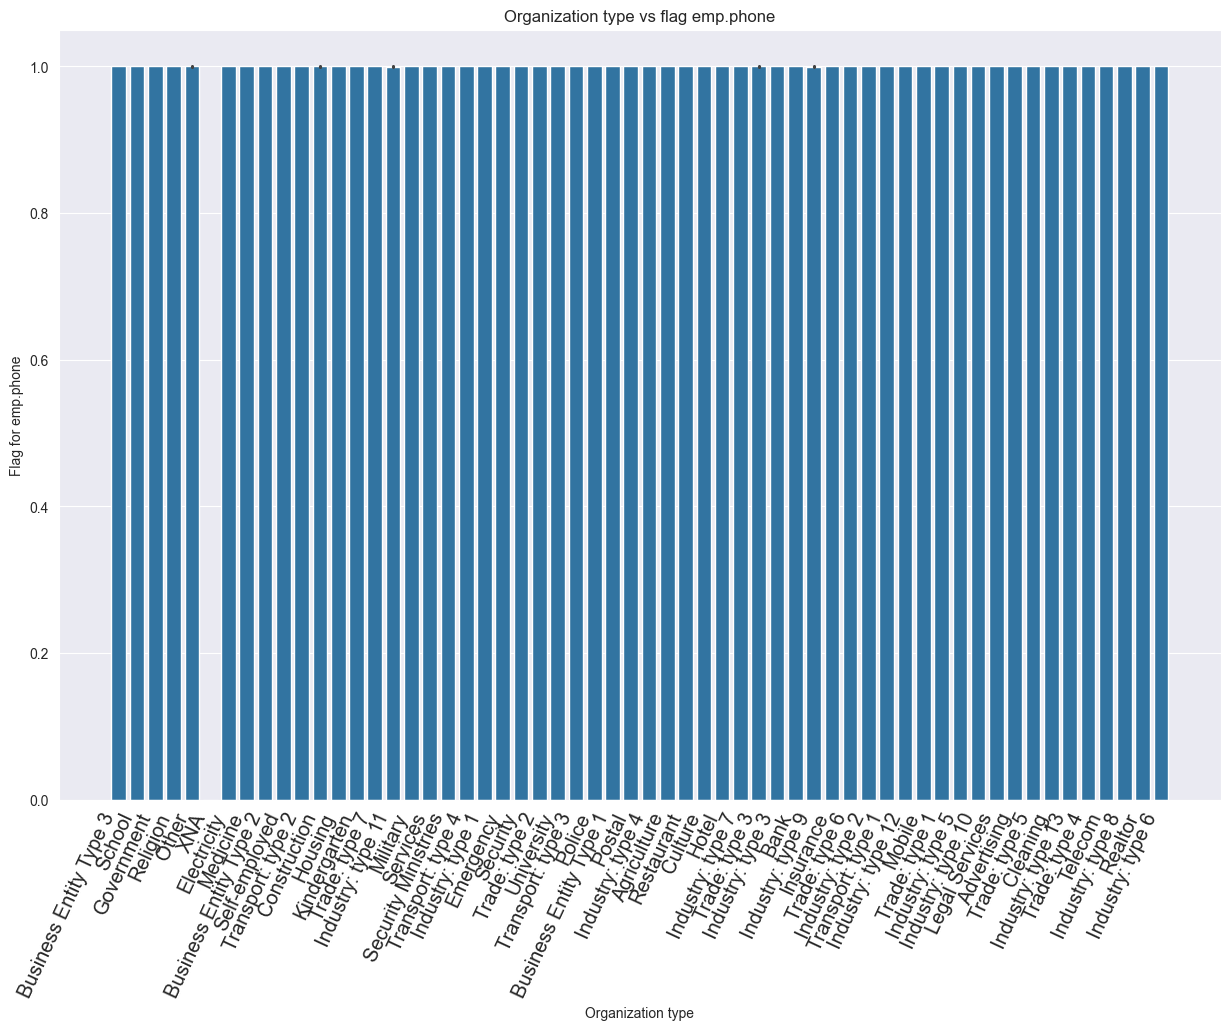

<IPython.core.display.Javascript object>

In [209]:
hf.plot_sns_barplot(application_train_upd_reduced, x='ORGANIZATION_TYPE', y='FLAG_EMP_PHONE',
                    x_label='Organization type', y_label='Flag for emp.phone',
                    title='Organization type vs flag emp.phone', 
                    my_figsize=(15, 10))

It seems that when the organization type is not specified, we don't have the employer's phone. 

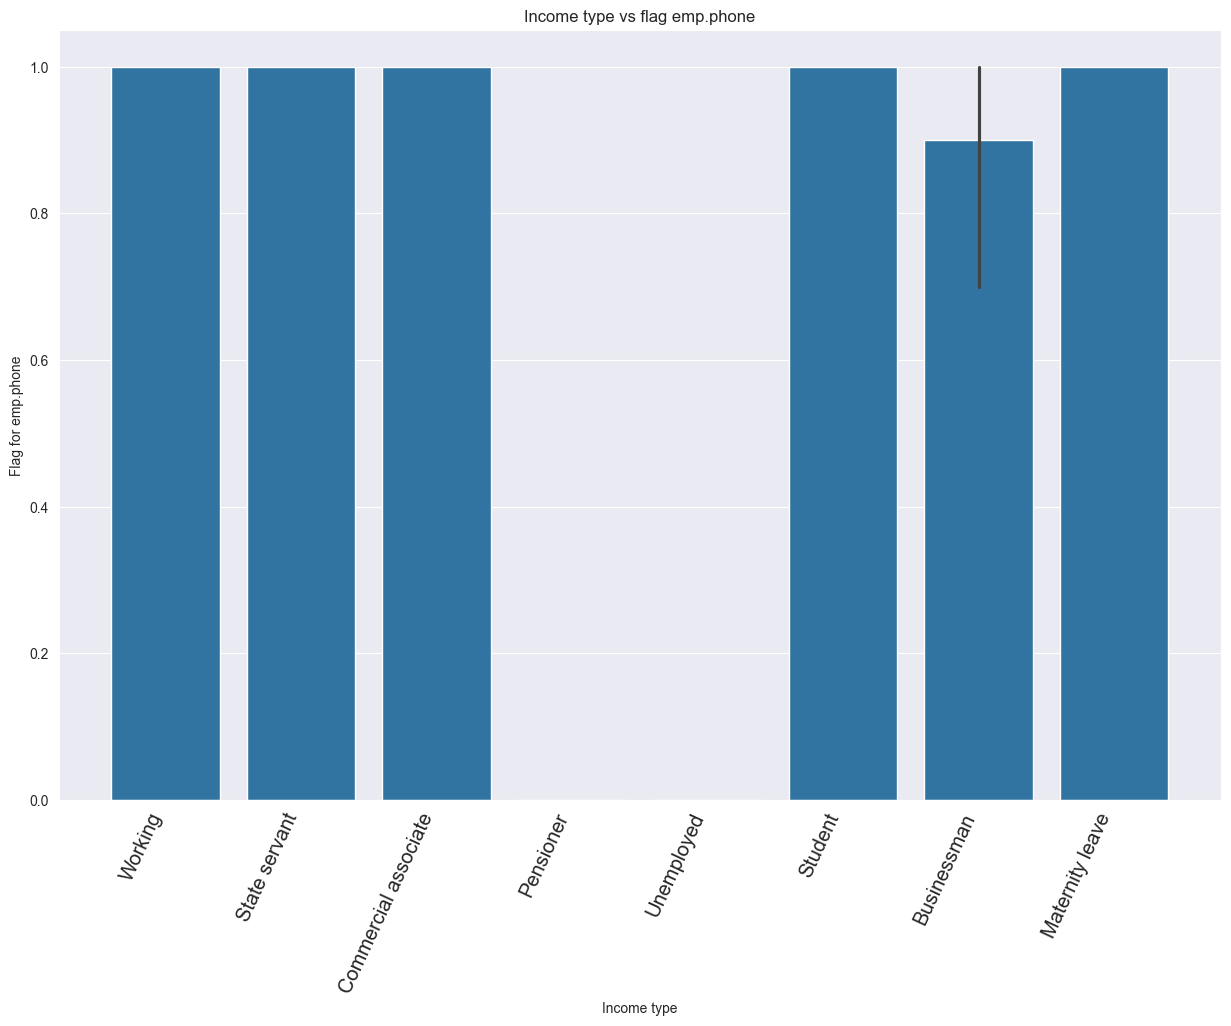

<IPython.core.display.Javascript object>

In [210]:
hf.plot_sns_barplot(application_train_upd_reduced, x='NAME_INCOME_TYPE', y='FLAG_EMP_PHONE',
                    x_label='Income type', y_label='Flag for emp.phone',
                    title='Income type vs flag emp.phone', 
                    my_figsize=(15, 10))

We can see that the feature flag emp.phone is also associated with the income type. Pensioners and unemployed applicants didn't share the employer's phone number, which makes sense.

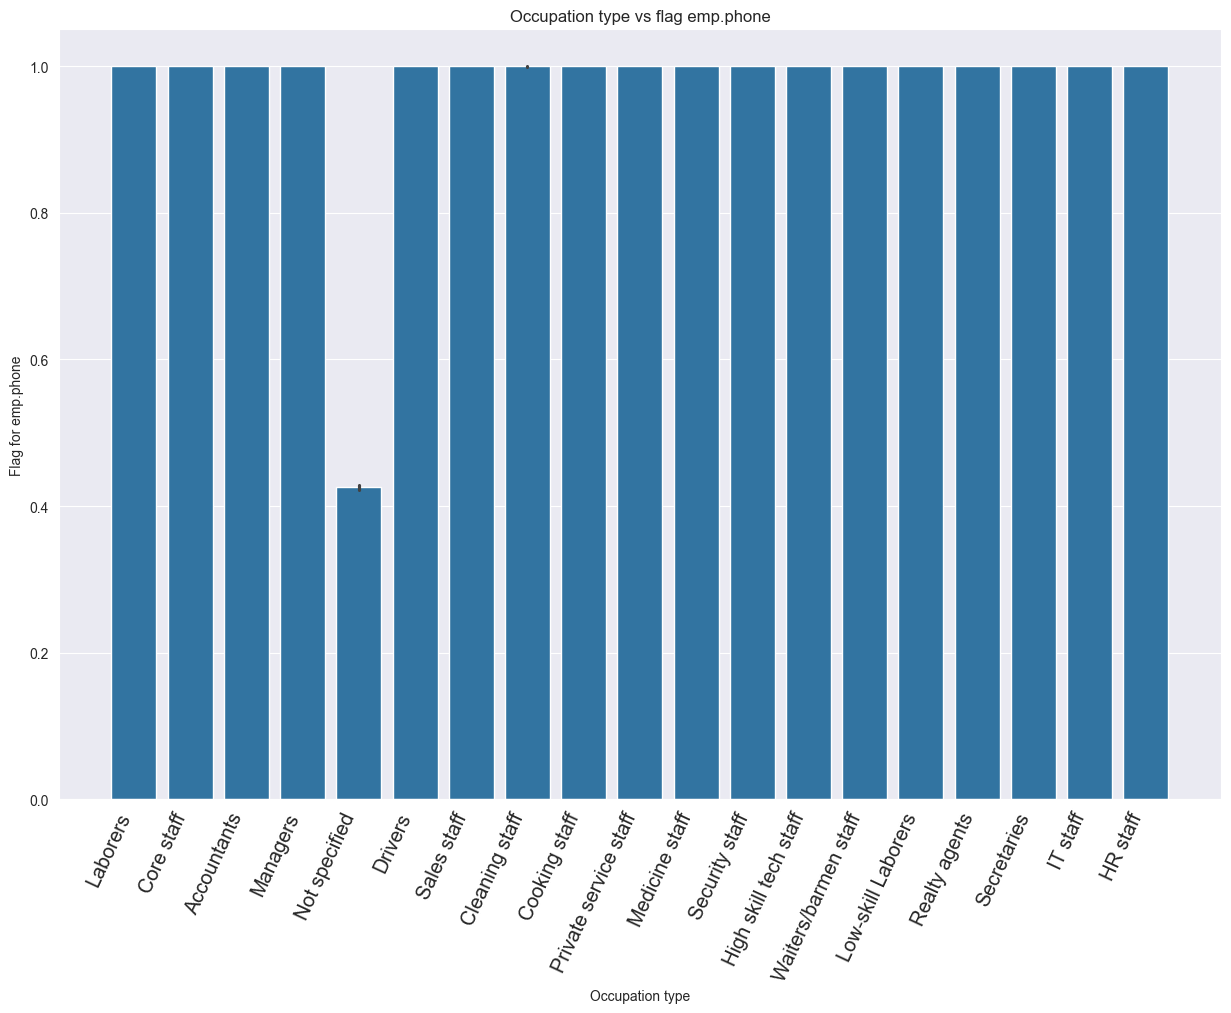

<IPython.core.display.Javascript object>

In [211]:
hf.plot_sns_barplot(application_train_upd_reduced, x='OCCUPATION_TYPE', y='FLAG_EMP_PHONE',
                    x_label='Occupation type', y_label='Flag for emp.phone',
                    title='Occupation type vs flag emp.phone', 
                    my_figsize=(15, 10))

There are some emp.phone numbers not given for applications where the occupation type hasn't been specified.

We can observe that the column FLAG_EMP_PHONE is highly associated with multiple other features, so we will drop it:

In [270]:
application_train_upd_reduced = application_train_upd_reduced.drop(['FLAG_EMP_PHONE'], axis=1)
categorical_cols_app_train = categorical_cols_app_train.drop(['FLAG_EMP_PHONE'], axis=1)

<IPython.core.display.Javascript object>

In [431]:
application_test_upd_reduced = application_test_upd_reduced.drop(['FLAG_EMP_PHONE'], axis=1)

<IPython.core.display.Javascript object>

Now, let's calculate the Phi coefficients for binary bool columns:

In [271]:
binary_columns = []

for column in categorical_cols_app_train.columns:
    unique_values = categorical_cols_app_train[column].unique()
    if set(unique_values) == {0, 1}:
        binary_columns.append(column)

<IPython.core.display.Javascript object>

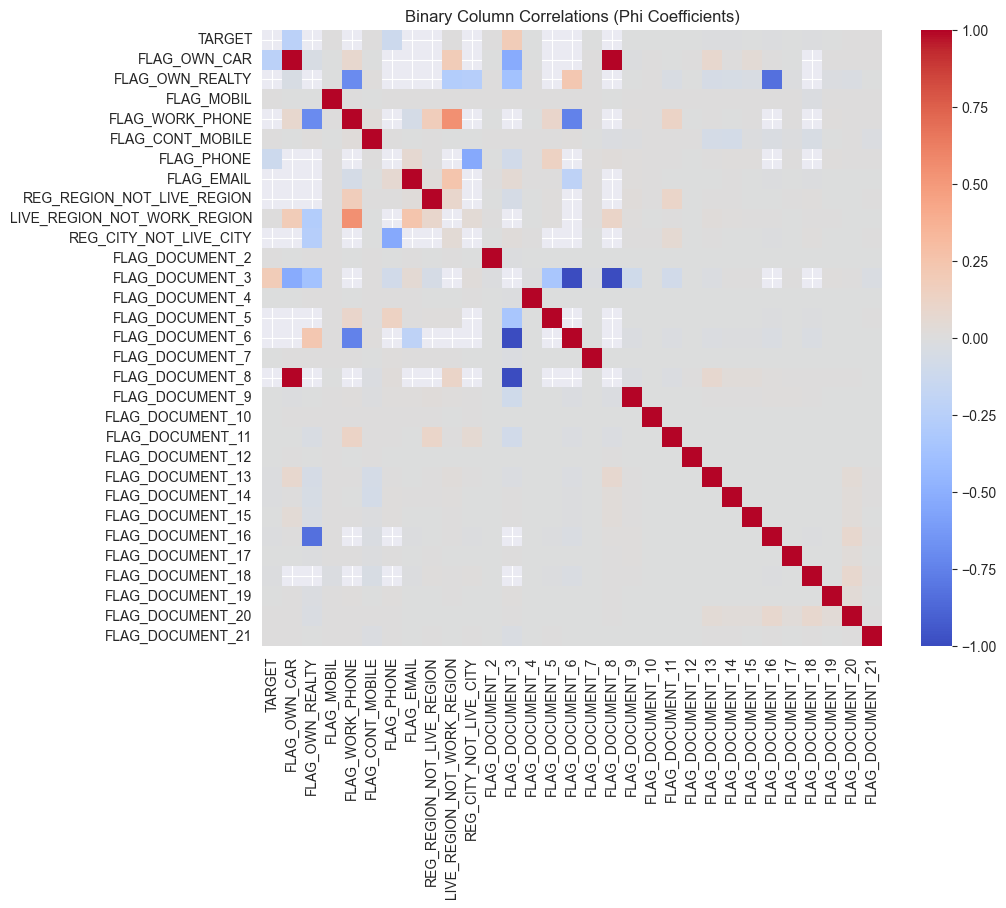

<IPython.core.display.Javascript object>

In [214]:
categoical_df = categorical_cols_app_train[binary_columns].astype('int')

def phi_coefficient(x, y):
    n11 = np.sum((x == 1) & (y == 1))
    n10 = np.sum((x == 1) & (y == 0))
    n01 = np.sum((x == 0) & (y == 1))
    n00 = np.sum((x == 0) & (y == 0))

    phi = (n11 * n00 - n10 * n01) / np.sqrt((n11 + n10) * (n11 + n01) * (n10 + n00) * (n01 + n00))
    return phi

corr_matrix = pd.DataFrame(index=categoical_df.columns, columns=categoical_df.columns)

for col1 in categoical_df.columns:
    for col2 in categoical_df.columns:
        phi = phi_coefficient(categoical_df[col1], categoical_df[col2])
        corr_matrix.loc[col1, col2] = phi

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Binary Column Correlations (Phi Coefficients)")
plt.show()

In [215]:
threshold = 0.5
top_corr = (np.abs(corr_matrix) > threshold) & (np.abs(corr_matrix) < 1)

features = []
for col1 in top_corr.columns:
    for col2 in top_corr.columns:
        if top_corr.loc[col1, col2]:
            features.append((col1, col2))

top_corr_df = pd.DataFrame(features, columns=['feature_1', 'feature_2'])
top_corr_df['corr_score'] = top_corr_df.apply(lambda x: 
                                               corr_matrix.loc[x['feature_1'], 
                                                              x['feature_2']], 
                                               axis=1)

print(top_corr_df.sort_values(by=['corr_score'], ascending=False))

                      feature_1                    feature_2  corr_score
4               FLAG_WORK_PHONE  LIVE_REGION_NOT_WORK_REGION    0.543500
7   LIVE_REGION_NOT_WORK_REGION              FLAG_WORK_PHONE    0.543500
0                  FLAG_OWN_CAR              FLAG_DOCUMENT_3   -0.525376
9               FLAG_DOCUMENT_3                 FLAG_OWN_CAR   -0.525376
6                    FLAG_PHONE       REG_CITY_NOT_LIVE_CITY   -0.534319
8        REG_CITY_NOT_LIVE_CITY                   FLAG_PHONE   -0.534319
1               FLAG_OWN_REALTY              FLAG_WORK_PHONE   -0.697216
3               FLAG_WORK_PHONE              FLAG_OWN_REALTY   -0.697216
5               FLAG_WORK_PHONE              FLAG_DOCUMENT_6   -0.747428
10              FLAG_DOCUMENT_6              FLAG_WORK_PHONE   -0.747428
2               FLAG_OWN_REALTY             FLAG_DOCUMENT_16   -0.831955
11             FLAG_DOCUMENT_16              FLAG_OWN_REALTY   -0.831955


<IPython.core.display.Javascript object>

Let's drop some of the highly associated features and the id columns, since we don't need it anymore:

In [272]:
cols_to_drop = ['FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_16', 'SK_ID_CURR']

application_train_upd_reduced = application_train_upd_reduced.drop(cols_to_drop, axis=1)
categorical_cols_app_train = categorical_cols_app_train.drop(cols_to_drop, axis=1)

<IPython.core.display.Javascript object>

In [432]:
cols_to_drop = ['FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_16']

for col in cols_to_drop:
    if col in application_test_upd_reduced.columns.tolist():
        application_test_upd_reduced = application_test_upd_reduced.drop(col, axis=1)

<IPython.core.display.Javascript object>

In [273]:
print(application_train_upd_reduced.shape)
application_train_upd_reduced.head()

(307505, 81)


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      1         Cash loans           M            0               1   
1      0         Cash loans           F            0               0   
2      0    Revolving loans           M            1               1   
3      0         Cash loans           F            0               1   
4      0         Cash loans           M            0               1   

   AMT_INCOME_TOTAL  AMT_CREDIT NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0          202500.0    406597.5   Unaccompanied          Working   
1          270000.0   1293502.5          Family    State servant   
2           67500.0    135000.0   Unaccompanied          Working   
3          135000.0    312682.5   Unaccompanied          Working   
4          121500.0    513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE    AGE  YEARS_EMPLOYED  YEARS_REGISTRATION  \
0                        0.02  25.90            1.74                9.99   
1                        0.00  45.90            3.25                3.25   
2                        0.01  52.15            0.62               11.66   
3                        0.01  52.03            8.32               26.92   
4                        0.03  54.57            8.32               11.80   

   YEARS_ID_PUBLISH  OWN_CAR_AGE FLAG_MOBIL FLAG_WORK_PHONE FLAG_CONT_MOBILE  \
0              5.80         -1.0          1               0                1   
1              0.80         -1.0          1               0                1   
2              6.93         26.0          1               1                1   
3              6.67         -1.0          1               0                1   
4              9.47         -1.0          1               0                1   

  FLAG_PHONE FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0          1          0        Laborers              1.0   
1          1          0      Core staff              2.0   
2          1          0        Laborers              1.0   
3          0          0        Laborers              2.0   
4          0          0      Core staff              1.0   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                  WEDNESDAY   
1                            1                     MONDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                   THURSDAY   

   HOUR_APPR_PROCESS_START REG_REGION_NOT_LIVE_REGION  \
0                       10                          0   
1                       11                          0   
2                        9                          0   
3                       17                          0   
4                       11                          0   

  LIVE_REGION_NOT_WORK_REGION REG_CITY_NOT_LIVE_CITY       ORGANIZATION_TYPE  \
0                           0                      0  Business Entity Type 3   
1                           0                      0                  School   
2                           0                      0              Government   
3                           0                      0  Business Entity Type 3   
4                           0                      0                Religion   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_60_CNT_SOCIAL_CIRCLE  \
0          0.26          0.14                       2.0   
1          0.62           NaN                       1.0   
2          0.56          0.73 

<IPython.core.display.Javascript object>

## 1.8. Mutual information scores and Recursive feature elimination

First, let's preprocess the data:

In [274]:
categorical_cols_app = application_train_upd_reduced.select_dtypes(exclude=['int', 'float']).columns.tolist()
bool_cols = [col for col in application_train_upd_reduced[categorical_cols_app].columns 
             if len(application_train_upd_reduced[col].unique()) == 2]
non_bool_cat_cols = [col for col in categorical_cols_app if col not in bool_cols]
application_train_upd_reduced[non_bool_cat_cols].isna().sum()

NAME_TYPE_SUITE                   0
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE                   0
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
LAST_BURR_CREDIT_STATUS       44019
LAST_CONTRACT_STATUS          16452
INCOME_LEVEL_BIN                  0
AMT_CREDIT_BIN                    0
AMT_ANNUITY_BIN                  12
dtype: int64

<IPython.core.display.Javascript object>

In [434]:
for col in ['LAST_BURR_CREDIT_STATUS', 'LAST_CONTRACT_STATUS']:
    application_train_upd_reduced[col] = application_train_upd_reduced[col].fillna("Not specified")
    application_test_upd_reduced[col] = application_test_upd_reduced[col].fillna("Not specified")

<IPython.core.display.Javascript object>

In [291]:
def preprocess_columns(my_df):
    
    df = my_df.copy()
    df = df.dropna()

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns  
    df[numeric_cols] = df[numeric_cols].apply(lambda x: (x - x.min()) / (x.max()-x.min()))
    
    ordinal_cols = ['NAME_EDUCATION_TYPE', 'LAST_CONTRACT_STATUS', 'INCOME_LEVEL_BIN', 
                    'AMT_CREDIT_BIN', 'AMT_ANNUITY_BIN']
    bool_cols = [col for col in df.select_dtypes(exclude=['int', 'float']).columns if len(df[col].unique()) == 2]

    non_ordinal_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    non_ordinal_cols = [col for col in non_ordinal_cols if col not in [ordinal_cols+bool_cols]]
    
    education_map = {'Secondary / secondary special':1, 
                     'Higher education':2,
                     'Incomplete higher':3,
                     'Lower secondary':4,
                     'Academic degree':5}

    contract_map = {'Approved':1,
                    'Refused':2,
                    'Canceled':3,   
                    'Not specified':4,
                    'Unused offer':5}

    income_max = df['INCOME_LEVEL_BIN'].max().right
    income_bins = pd.IntervalIndex.from_tuples([
        (0.0, 20000.0), 
        (20000.0, 50000.0),
        (50000.0, 100000.0), 
        (100000.0, income_max)])    
    income_map = {interval:idx for idx, interval in enumerate(income_bins, 1)}
    
    credit_max = df['AMT_CREDIT_BIN'].max().right  
    credit_bins = pd.IntervalIndex.from_tuples([
        (0.0, 50000.0),
        (50000.0, 500000.0),
        (500000.0, 1000000.0),
        (1000000.0, credit_max)])       
    credit_map = {interval:idx for idx, interval in enumerate(credit_bins, 1)}
    
    annuity_max = df['AMT_ANNUITY_BIN'].max().right 
    annuity_bins = pd.IntervalIndex.from_tuples([
        (0.0, 15000.0), 
        (15000.0, 25000.0),
        (25000.0, 35000.0),
        (35000.0, 50000.0),
        (50000.0, 100000.0),
        (100000.0, annuity_max)])  
    annuity_map = {interval:idx for idx, interval in enumerate(annuity_bins, 1)}

    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_map)
    df['LAST_CONTRACT_STATUS'] = df['LAST_CONTRACT_STATUS'].map(contract_map) 
    df['INCOME_LEVEL_BIN'] = df['INCOME_LEVEL_BIN'].map(income_map)
    df['AMT_CREDIT_BIN'] = df['AMT_CREDIT_BIN'].map(credit_map)
    df['AMT_ANNUITY_BIN'] = df['AMT_ANNUITY_BIN'].map(annuity_map)

    for col in non_ordinal_cols:
        lbl = LabelEncoder()
        df[col] = lbl.fit_transform(df[col].astype(str)) 
    
    return df

<IPython.core.display.Javascript object>

In [292]:
application_train_upd_processed = preprocess_columns(application_train_upd_reduced)
application_train_upd_processed.dropna(inplace=True)

<IPython.core.display.Javascript object>

#### Mutual information scores

Selected 50 features: ['AVG_DOWN_PAYMENT', 'SUM_CREDIT_MAX_OVERDUE_BURR', 'AVG_CREDIT_LIMIT_BUREAU', 'AMT_CREDIT', 'AGE', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'EXT_SOURCE_2', 'AVG_SK_DPD', 'LOAN_INCOME_RATIO', 'YEARS_ID_PUBLISH', 'YEARS_SINCE_LAST_BURR_CREDIT', 'YEARS_LAST_PHONE_CHANGE', 'APPS_APPROVAL_RATE', 'YEARS_SINCE_LAST_APP', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL', 'AVG_SK_DPD_DEF', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'LAST_CONTRACT_STATUS', 'LAST_BURR_CREDIT_STATUS', 'NUM_PAST_DUE_INSTALL', 'OWN_CAR_AGE', 'AVG_RATE_DOWN_PAYMENT', 'CODE_GENDER', 'REGION_POPULATION_RELATIVE', 'NAME_INCOME_TYPE', 'AMT_ANNUITY_BIN', 'AMT_CREDIT_BIN', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NUM_PREV_APPS', 'NAME_CONTRACT_TYPE', 'NAME_HOUSING_TYPE', 'NUM_TOTAL_CREDITS', 'HOUR_APPR_PROCESS_START', 'FLAG_OWN_CAR', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_PHONE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_

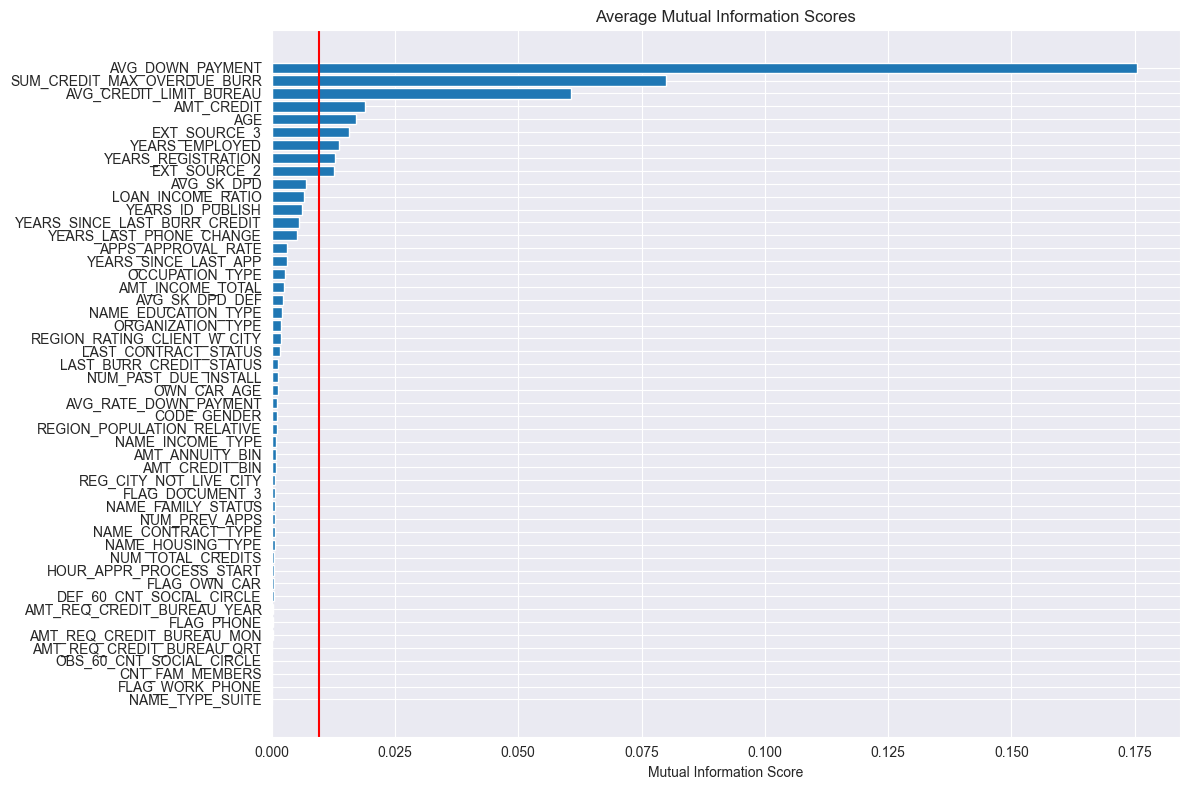

<IPython.core.display.Javascript object>

In [295]:
target = ['TARGET']
features = [col for col in application_train_upd_processed if col not in target]
mi_avg_scores = hf.avg_mi(application_train_upd_processed, features, target)
selected_features = hf.select_features(mi_avg_scores, k=50)
hf.plot_mi_scores(mi_avg_scores[mi_avg_scores.index.isin(selected_features)])

In [297]:
mi_avg_scores[mi_avg_scores.index.isin(selected_features)]

AVG_DOWN_PAYMENT                0.175411
SUM_CREDIT_MAX_OVERDUE_BURR     0.080046
AVG_CREDIT_LIMIT_BUREAU         0.060661
AMT_CREDIT                      0.018999
AGE                             0.017084
EXT_SOURCE_3                    0.015734
YEARS_EMPLOYED                  0.013589
YEARS_REGISTRATION              0.012901
EXT_SOURCE_2                    0.012733
AVG_SK_DPD                      0.006946
LOAN_INCOME_RATIO               0.006480
YEARS_ID_PUBLISH                0.006157
YEARS_SINCE_LAST_BURR_CREDIT    0.005642
YEARS_LAST_PHONE_CHANGE         0.005116
APPS_APPROVAL_RATE              0.003172
YEARS_SINCE_LAST_APP            0.003046
OCCUPATION_TYPE                 0.002677
AMT_INCOME_TOTAL                0.002520
AVG_SK_DPD_DEF                  0.002321
NAME_EDUCATION_TYPE             0.002147
ORGANIZATION_TYPE               0.001906
REGION_RATING_CLIENT_W_CITY     0.001892
LAST_CONTRACT_STATUS            0.001782
LAST_BURR_CREDIT_STATUS         0.001363
NUM_PAST_DUE_INS

<IPython.core.display.Javascript object>

- The top-5 features based on average mutual information scores are:
    - AVG_DOWN_PAYMENT
    - SUM_CREDIT_MAX_OVERDUE_BURR
    - AVG_CREDIT_LIMIT_BUREAU
    - AMT_CREDIT
    - AGE

#### Recursive feature elimination

In [352]:
X = application_train_upd_processed[features]
y = application_train_upd_processed['TARGET'].ravel()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfe = RFECV(estimator=LogisticRegression(),
            step=1,
            cv=cv,
            scoring='roc_auc',
            verbose=1,
            n_jobs=-1,
            min_features_to_select=30) 
            
rfe.fit(X_scaled, y)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(), min_features_to_select=30, n_jobs=-1,
      scoring='roc_auc', verbose=1)

<IPython.core.display.Javascript object>

Top Optimal RFE Features:
Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_CREDIT',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'AGE',
       'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'YEARS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AVG_CREDIT_LIMIT_BUREAU',
       'LOAN_INCOME_RATIO', 'AVG_DOWN_PAYMENT', 'NUM_PAST_DUE_INSTALL',
       'APPS_APPROVAL_RATE', 'LAST_BURR_CREDIT_STATUS',
       'YEARS_SINCE_LAST_BURR_CREDI

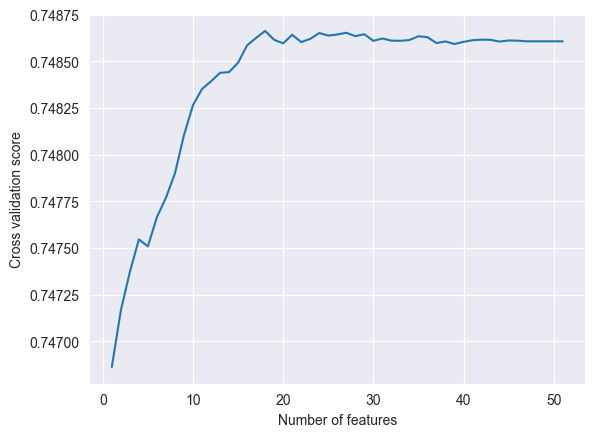

<IPython.core.display.Javascript object>

In [353]:
print('Top Optimal RFE Features:')
print(X.columns[rfe.support_])

plt.plot(range(1, len(rfe.cv_results_['mean_test_score'])+1),
         rfe.cv_results_['mean_test_score'])  

plt.xlabel('Number of features')
plt.ylabel('Cross validation score') 

plt.show()

In [357]:
recursive_selected_features = X.columns[rfe.support_].values.tolist()
recursive_selected_features[:10]

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_CREDIT',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'AGE',
 'YEARS_EMPLOYED',
 'YEARS_ID_PUBLISH']

<IPython.core.display.Javascript object>

Let's see what features did mutual information and RFE select in common:

In [360]:
common_selected_features = list(set(selected_features) & set(recursive_selected_features))
common_selected_features

['AMT_ANNUITY_BIN',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'CODE_GENDER',
 'YEARS_EMPLOYED',
 'AVG_RATE_DOWN_PAYMENT',
 'EXT_SOURCE_3',
 'FLAG_PHONE',
 'YEARS_LAST_PHONE_CHANGE',
 'YEARS_ID_PUBLISH',
 'NAME_INCOME_TYPE',
 'AVG_DOWN_PAYMENT',
 'LOAN_INCOME_RATIO',
 'LAST_BURR_CREDIT_STATUS',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_TYPE_SUITE',
 'EXT_SOURCE_2',
 'AGE',
 'NUM_PAST_DUE_INSTALL',
 'YEARS_SINCE_LAST_APP',
 'LAST_CONTRACT_STATUS',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'AMT_CREDIT',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'APPS_APPROVAL_RATE',
 'FLAG_OWN_CAR',
 'YEARS_SINCE_LAST_BURR_CREDIT',
 'FLAG_DOCUMENT_3',
 'NAME_EDUCATION_TYPE',
 'FLAG_WORK_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'AVG_CREDIT_LIMIT_BUREAU',
 'REG_CITY_NOT_LIVE_CITY']

<IPython.core.display.Javascript object>

# 2. Statistical Inference

##### Main insights and observations:
- There is a significant association between the loan status and AMT_ANNUITY_BIN, CODE_GENDER, FLAG_PHONE, NAME_INCOME_TYPE, LAST_BURR_CREDIT_STATUS, NAME_TYPE_SUITE, LAST_CONTRACT_STATUS, OCCUPATION_TYPE, FLAG_OWN_CAR, FLAG_DOCUMENT_3, NAME_EDUCATION_TYPE, FLAG_WORK_PHONE, REG_CITY_NOT_LIVE_CITY.
- The median values of YEARS_ID_PUBLISH, AGE, AMT_CREDIT, REGION_RATING_CLIENT_W_CITY are significantly different between fully paid loan applications and problematic loan applications.
- The 95% confidence interval for people who have fully paid their loan:
    - YEARS_ID_PUBLISH: 8.24-8.27 (as opposed to 7.43-7.53 for problematic applications)
    - AGE: 44.14-44.23 (as opposed to 40.6-40.89 for problematic applications)
    - AMT_CREDIT: 601151.16-604150.77 (as opposed to 553469.06-562087.99 for problematic applications)
    - REGION_RATING_CLIENT_W_CITY: 2.02 (as opposed to 2.12-2.14 for problematic applications)

## 2.1. Hypothesis testing

### 2.1.1. Is there a significant association between the categorical features and the loan status?

##### Outcomes: 
- There is a significant association between the loan status and AMT_ANNUITY_BIN, CODE_GENDER, FLAG_PHONE, NAME_INCOME_TYPE, LAST_BURR_CREDIT_STATUS, NAME_TYPE_SUITE, LAST_CONTRACT_STATUS, OCCUPATION_TYPE, FLAG_OWN_CAR, FLAG_DOCUMENT_3, NAME_EDUCATION_TYPE, FLAG_WORK_PHONE, REG_CITY_NOT_LIVE_CITY.

In [442]:
selected_app_train_upd = application_train_upd_reduced[common_selected_features+['TARGET']]
selected_app_train_cat_cols = selected_app_train_upd.select_dtypes(include=['object', 
                                                                            'category']).columns.tolist()

<IPython.core.display.Javascript object>

In [377]:
for col in selected_app_train_cat_cols[:-1]:
    print(col)
    print("_"*20)
    print(hf.chi_square_test(application_train_upd_reduced, col, 'TARGET'))
    print("-"*50)

AMT_ANNUITY_BIN
____________________
{'Chi-Square Statistic': 445.8952592648936, 'P-value': 3.772779685899449e-94, 'Degrees of Freedom': 5, 'Expected Frequencies Table': array([[5.85379686e+04, 5.14103142e+03],
       [8.38233117e+04, 7.36168831e+03],
       [7.14904329e+04, 6.27856707e+03],
       [4.92386691e+04, 4.32433088e+03],
       [1.91133881e+04, 1.67861187e+03],
       [4.64229560e+02, 4.07704403e+01]]), 'Significance Level (alpha)': 0.05, 'Hypothesis Test Result': 'Reject the null hypothesis: There is a significant association between the two features.'}
--------------------------------------------------
CODE_GENDER
____________________
{'Chi-Square Statistic': 920.0292340000075, 'P-value': 4.342688928926844e-202, 'Degrees of Freedom': 1, 'Expected Frequencies Table': array([[186103.3737988,  16343.6262012],
       [ 96576.6262012,   8481.3737988]]), 'Significance Level (alpha)': 0.05, 'Hypothesis Test Result': 'Reject the null hypothesis: There is a significant association 

<IPython.core.display.Javascript object>

### 2.1.2. Are median values of numeric features for fully paid loans different from problematic loans?

##### Outcomes:
- The median values of YEARS_ID_PUBLISH, AGE, AMT_CREDIT, REGION_RATING_CLIENT_W_CITY are significantly different between fully paid loan applications and problematic loan applications.

In [382]:
selected_app_train_num_cols = selected_app_train_upd.select_dtypes(exclude=['object', 'category']).columns.tolist()
selected_app_train_num_df = application_train_upd_reduced[selected_app_train_num_cols+['TARGET']]

<IPython.core.display.Javascript object>

In [383]:
problematic_loans = selected_app_train_num_df[selected_app_train_num_df['TARGET'] == 1]
fully_paid_loans = selected_app_train_num_df[selected_app_train_num_df['TARGET'] == 0]

<IPython.core.display.Javascript object>

Results of the tests for assumptions for 2-sample t-tests for groups in AMT_REQ_CREDIT_BUREAU_MON:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


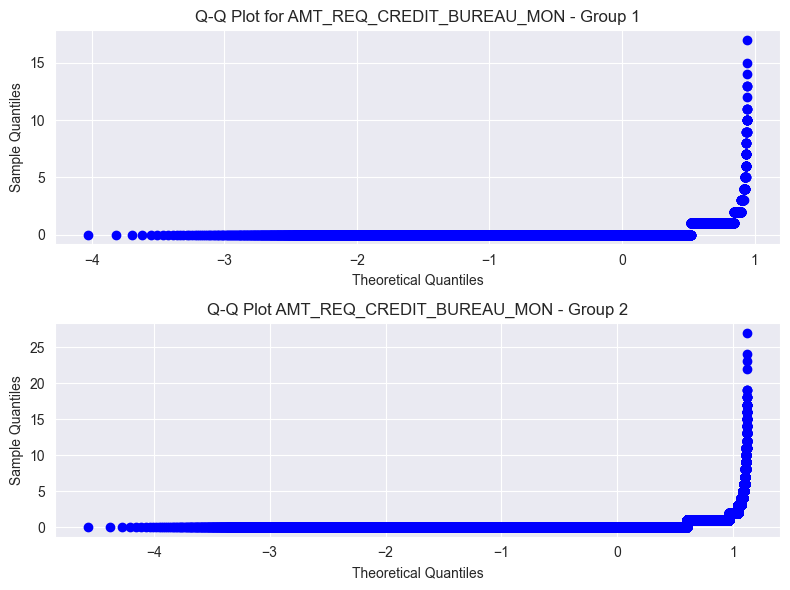

Results of the tests for assumptions for 2-sample t-tests for groups in YEARS_EMPLOYED:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


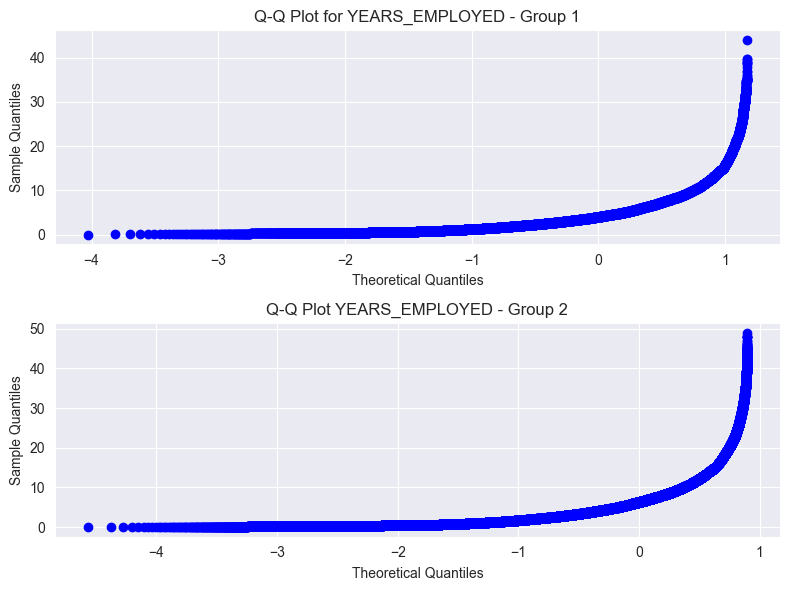

Results of the tests for assumptions for 2-sample t-tests for groups in AVG_RATE_DOWN_PAYMENT:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


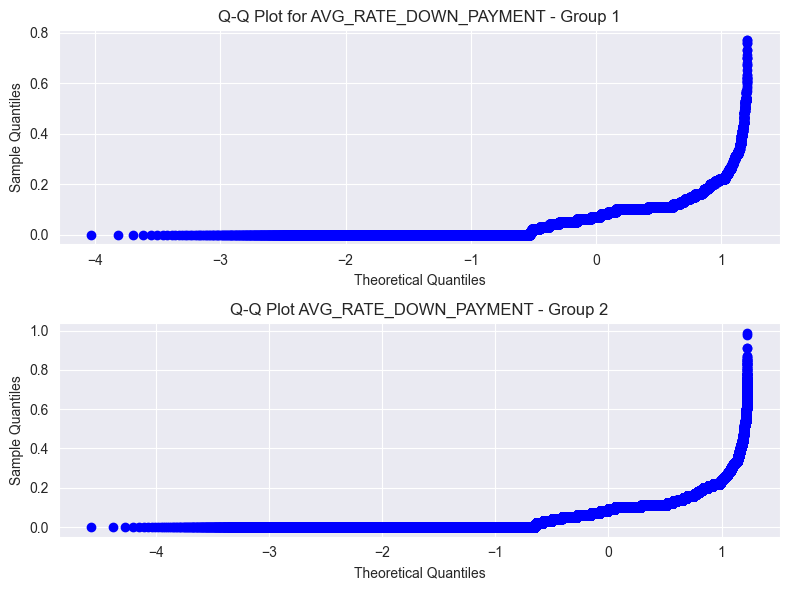

Results of the tests for assumptions for 2-sample t-tests for groups in EXT_SOURCE_3:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


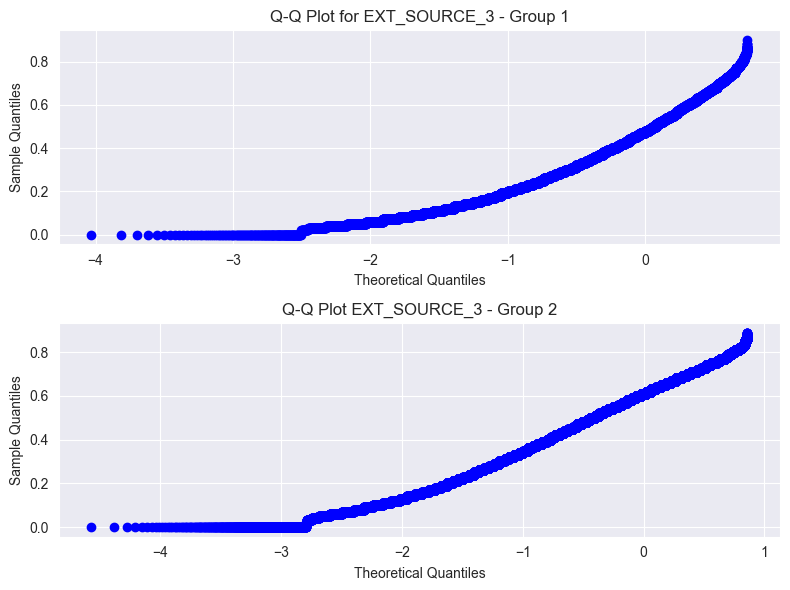

Results of the tests for assumptions for 2-sample t-tests for groups in YEARS_LAST_PHONE_CHANGE:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.8960569500923157 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 2850.180815405516 P-value = 0.0
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


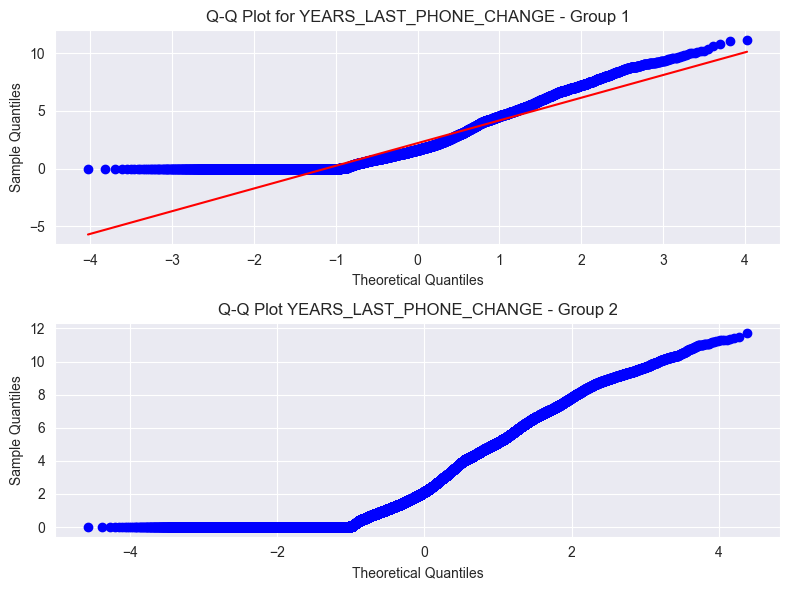

Results of the tests for assumptions for 2-sample t-tests for groups in YEARS_ID_PUBLISH:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.950714647769928 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = 0.9401461482048035 P-value = 0.0
Levene's Test - P-value = 1.1633151229385817e-06
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 27951.86513281671 P-value = 0.0
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 114567.78103193673 P-value = 0.0
One or both groups may not be normally distributed.
--------------------------------------------------


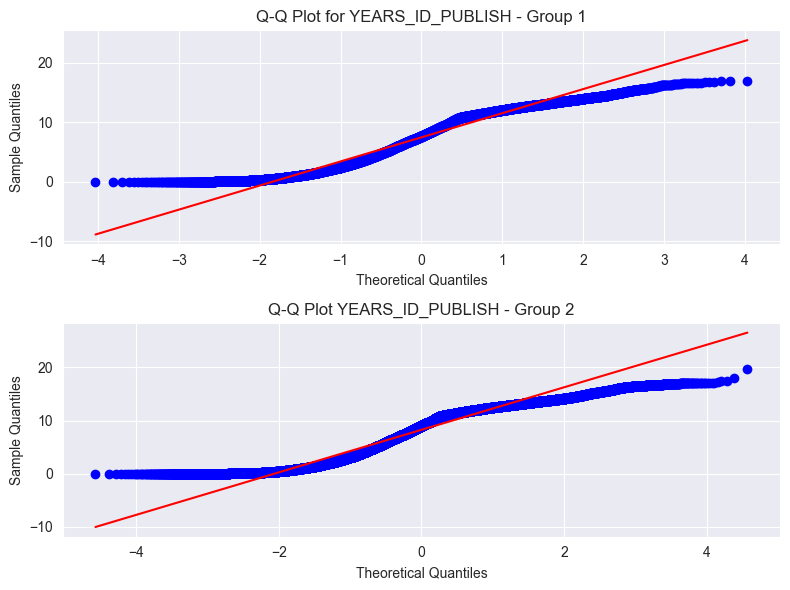

Results of the tests for assumptions for 2-sample t-tests for groups in AVG_DOWN_PAYMENT:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


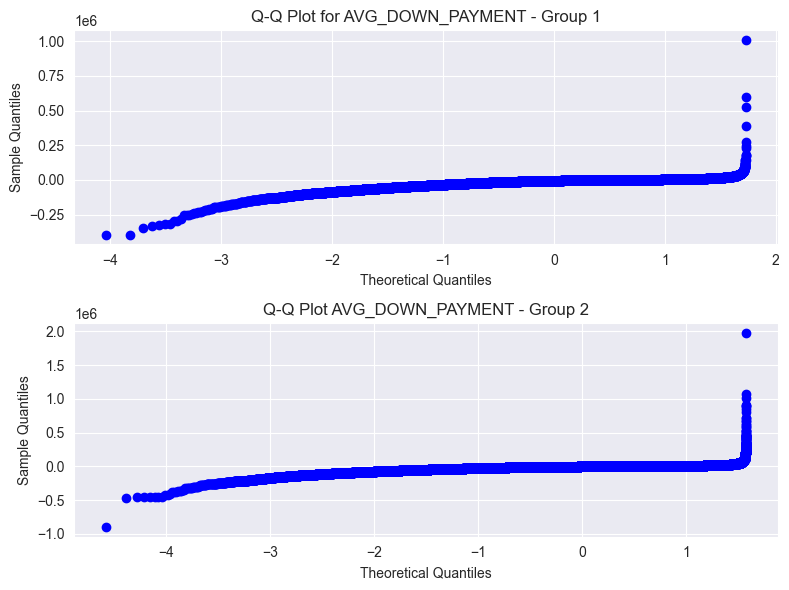

Results of the tests for assumptions for 2-sample t-tests for groups in LOAN_INCOME_RATIO:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.8257390856742859 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = 0.8716883659362793 P-value = 0.0
Levene's Test - P-value = 2.1958452031498113e-26
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 19890.270269635315 P-value = 0.0
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 102942.85593051137 P-value = 0.0
One or both groups may not be normally distributed.
--------------------------------------------------


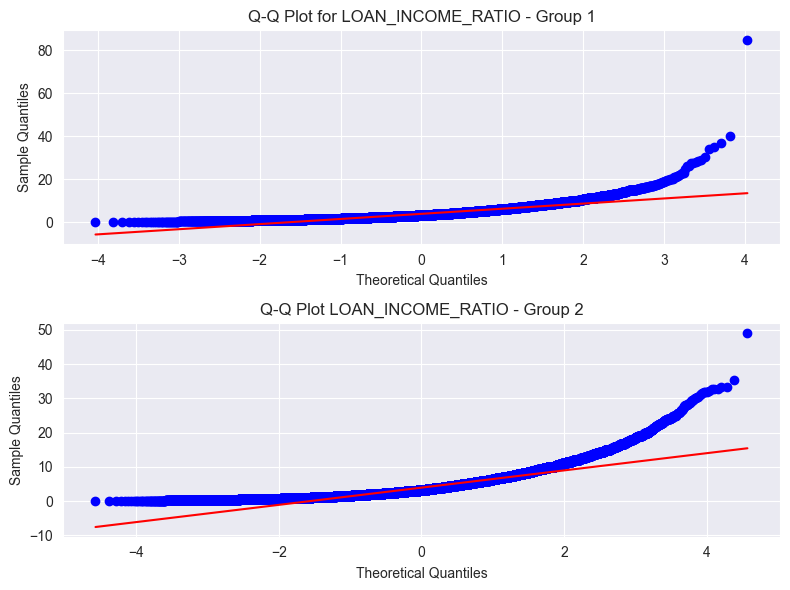

Results of the tests for assumptions for 2-sample t-tests for groups in AMT_REQ_CREDIT_BUREAU_QRT:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


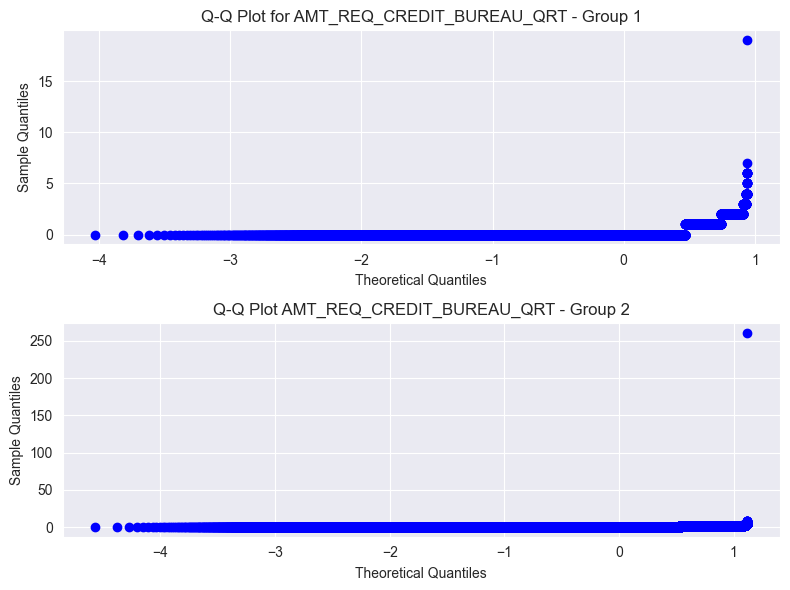

Results of the tests for assumptions for 2-sample t-tests for groups in EXT_SOURCE_2:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


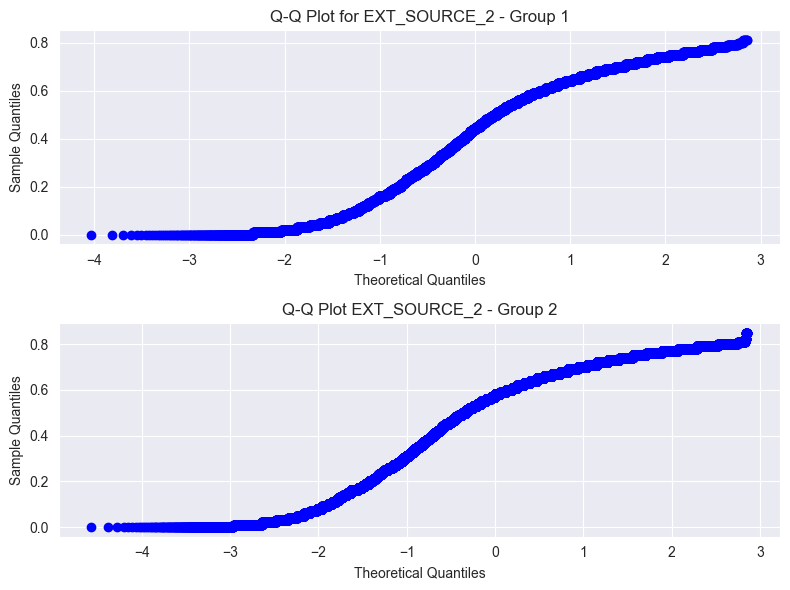

Results of the tests for assumptions for 2-sample t-tests for groups in AGE:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9623889327049255 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = 0.9702861905097961 P-value = 0.0
Levene's Test - P-value = 6.718839098422011e-48
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 3040.8307756977692 P-value = 0.0
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 88713.88388970225 P-value = 0.0
One or both groups may not be normally distributed.
--------------------------------------------------


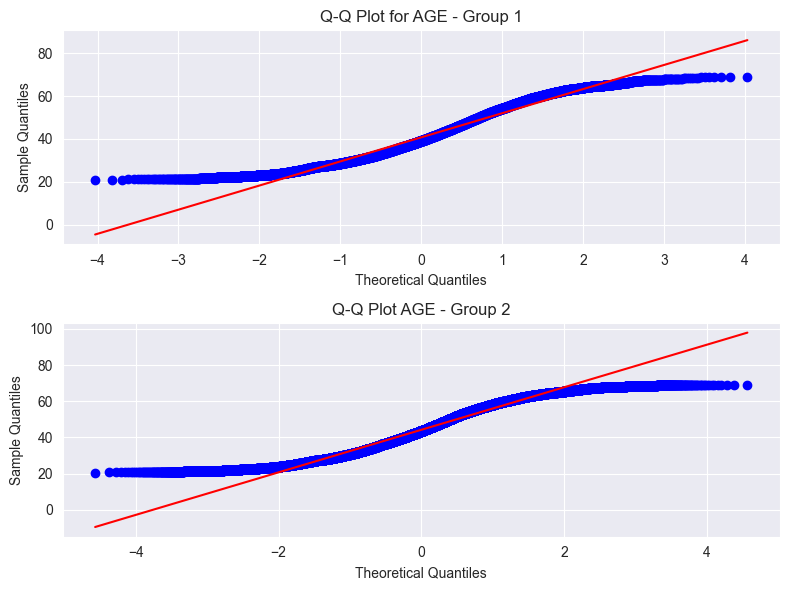

Results of the tests for assumptions for 2-sample t-tests for groups in NUM_PAST_DUE_INSTALL:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


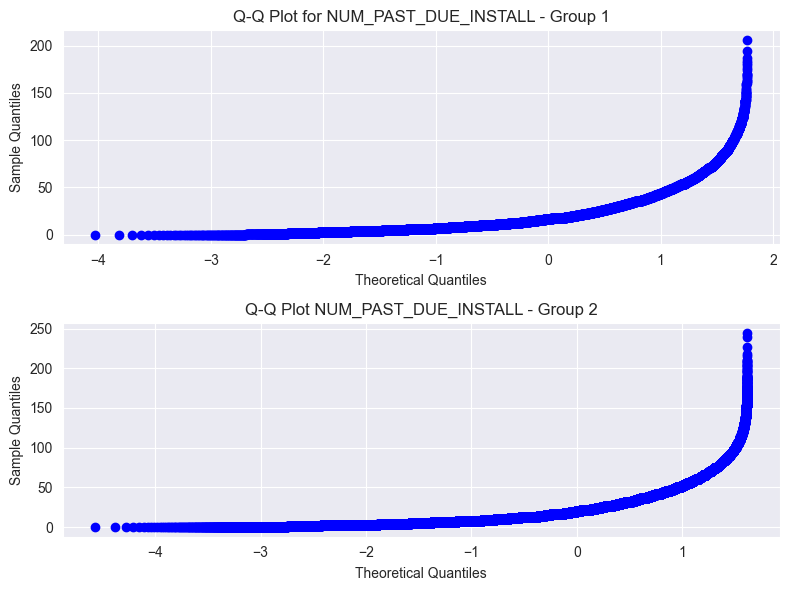

Results of the tests for assumptions for 2-sample t-tests for groups in YEARS_SINCE_LAST_APP:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


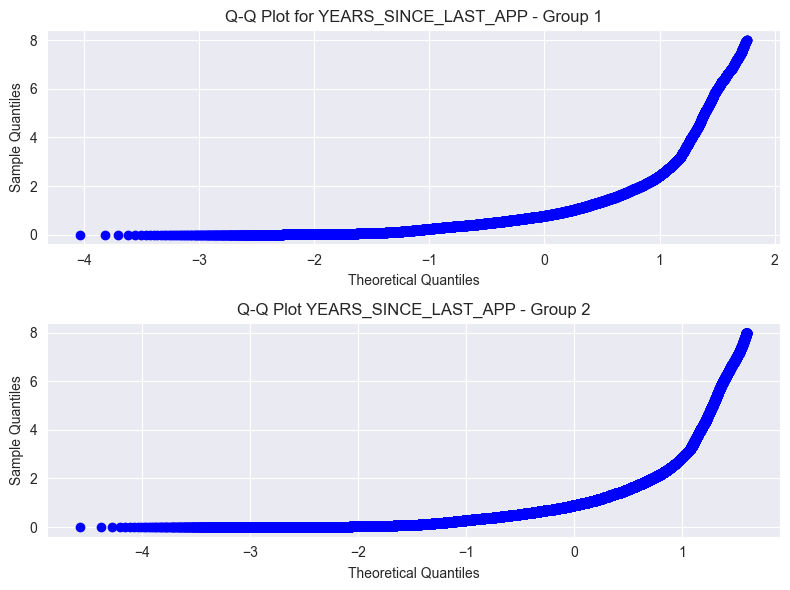

Results of the tests for assumptions for 2-sample t-tests for groups in OWN_CAR_AGE:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.5235438346862793 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 18671.045660277552 P-value = 0.0
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


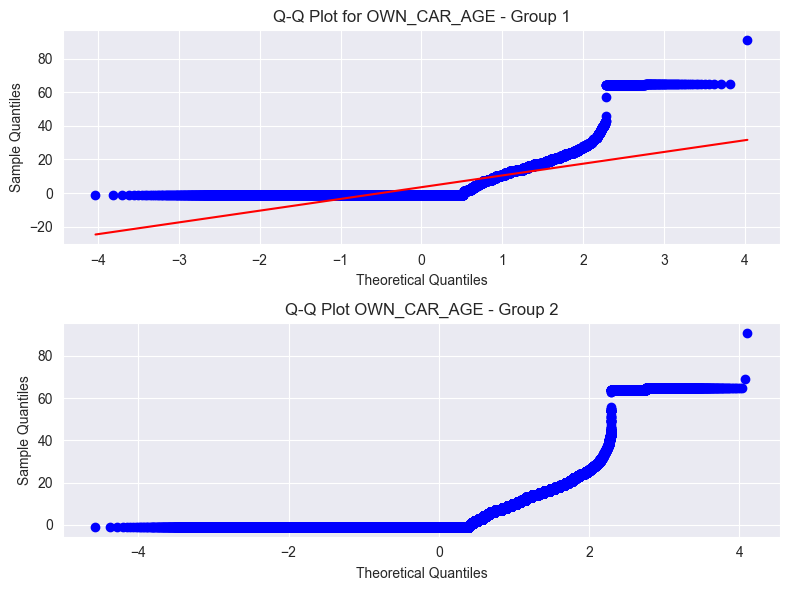

Results of the tests for assumptions for 2-sample t-tests for groups in AMT_CREDIT:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.9049122333526611 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = 0.9062390923500061 P-value = 0.0
Levene's Test - P-value = 5.680943237061567e-184
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 6016.679659972541 P-value = 0.0
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 56661.55585959433 P-value = 0.0
One or both groups may not be normally distributed.
--------------------------------------------------


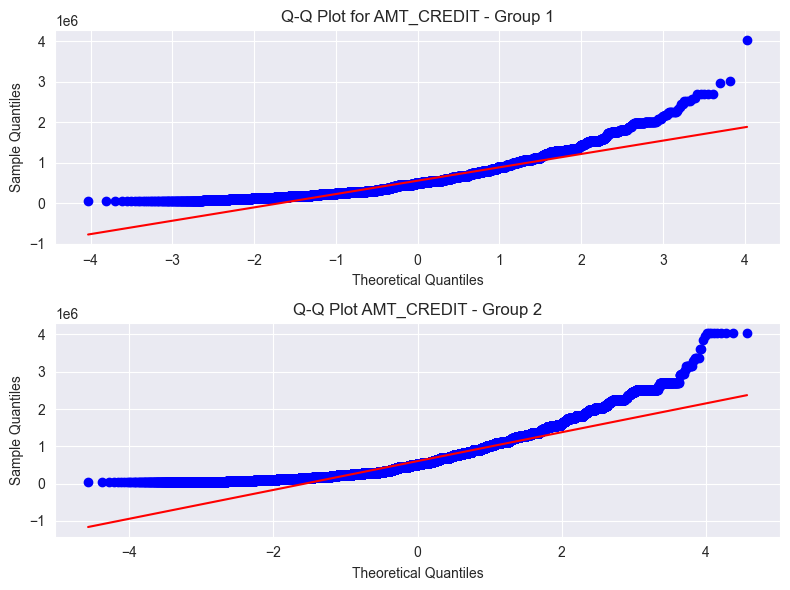

Results of the tests for assumptions for 2-sample t-tests for groups in DEF_60_CNT_SOCIAL_CIRCLE:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


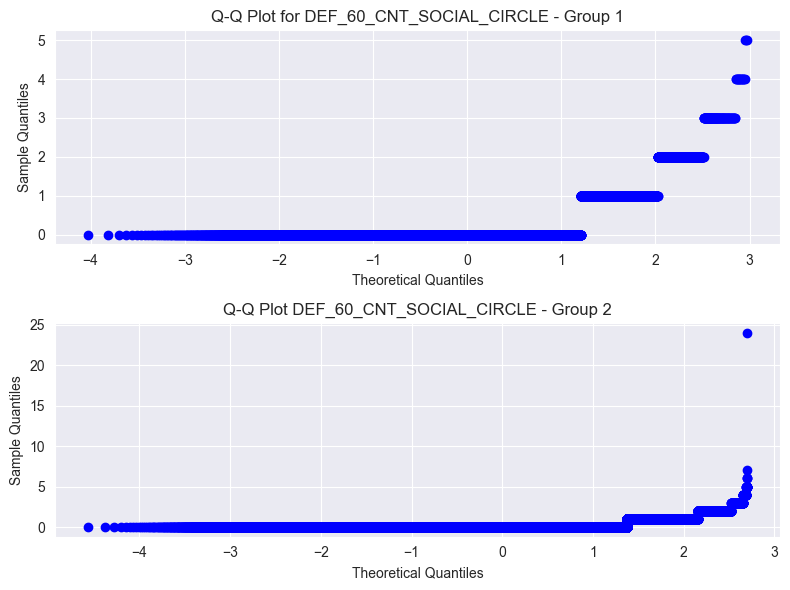

Results of the tests for assumptions for 2-sample t-tests for groups in APPS_APPROVAL_RATE:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


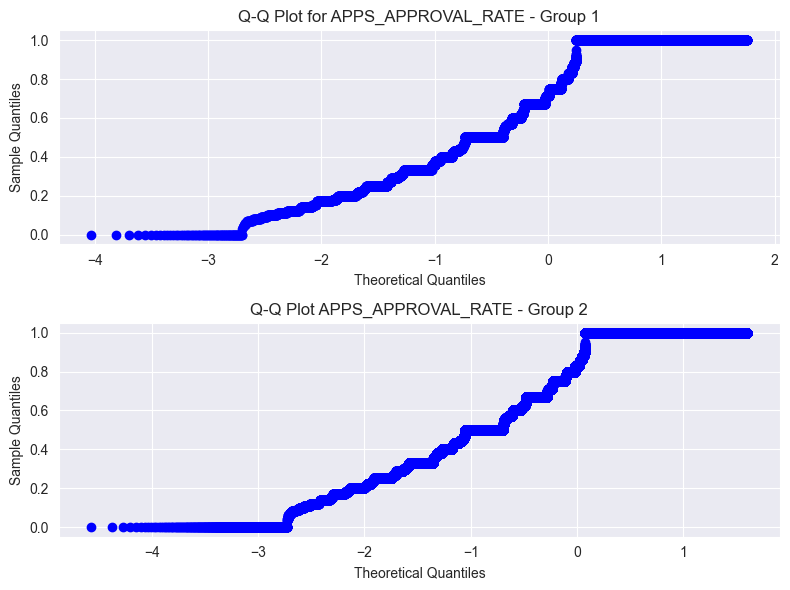

Results of the tests for assumptions for 2-sample t-tests for groups in YEARS_SINCE_LAST_BURR_CREDIT:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


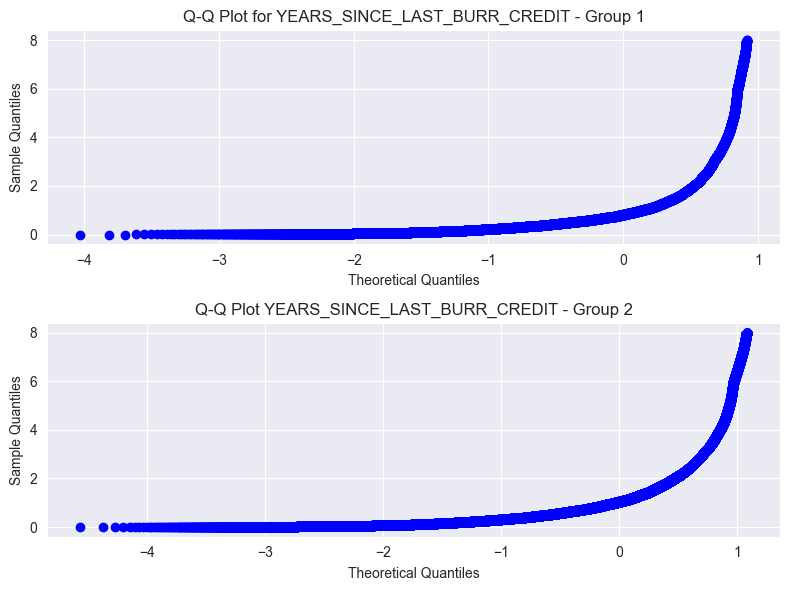

Results of the tests for assumptions for 2-sample t-tests for groups in REGION_RATING_CLIENT_W_CITY:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = 0.6742711067199707 P-value = 0.0
Shapiro-Wilk Test - Group 2: Statistic = 0.680864155292511 P-value = 0.0
Levene's Test - P-value = 6.14171462652083e-08
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = 466.3402957587439 P-value = 5.438654012174068e-102
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = 5219.748793466441 P-value = 0.0
One or both groups may not be normally distributed.
--------------------------------------------------


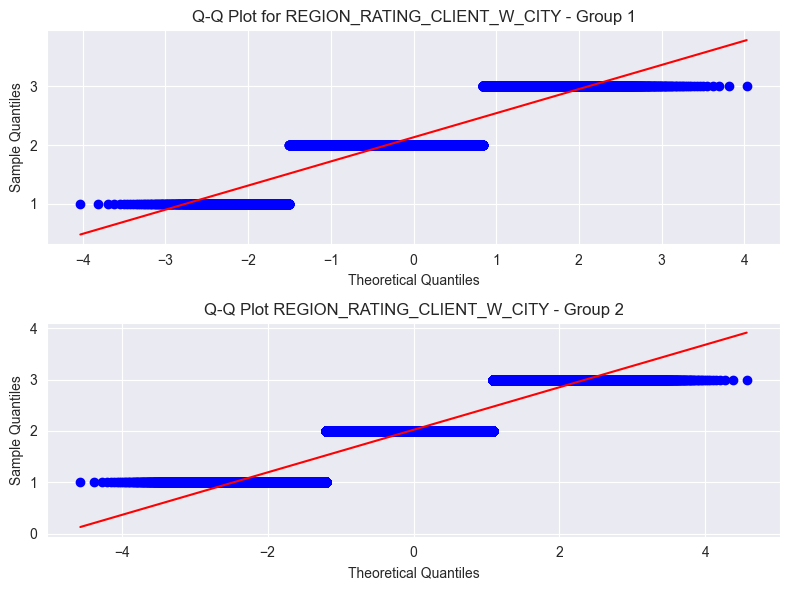

Results of the tests for assumptions for 2-sample t-tests for groups in AVG_CREDIT_LIMIT_BUREAU:
----------------------------------------------------------------------
Shapiro-Wilk Test - Group 1: Statistic = nan P-value = 1.0
Shapiro-Wilk Test - Group 2: Statistic = nan P-value = 1.0
Levene's Test - P-value = nan
One or both groups may not meet the assumptions for the t-test.
--------------------------------------------------
D'Agostino and Pearson's omnibus Test for Normality - Group 1: Statistic = nan P-value = nan
D'Agostino and Pearson's omnibus Test for Normality - Group 2: Statistic = nan P-value = nan
One or both groups may not be normally distributed.
--------------------------------------------------


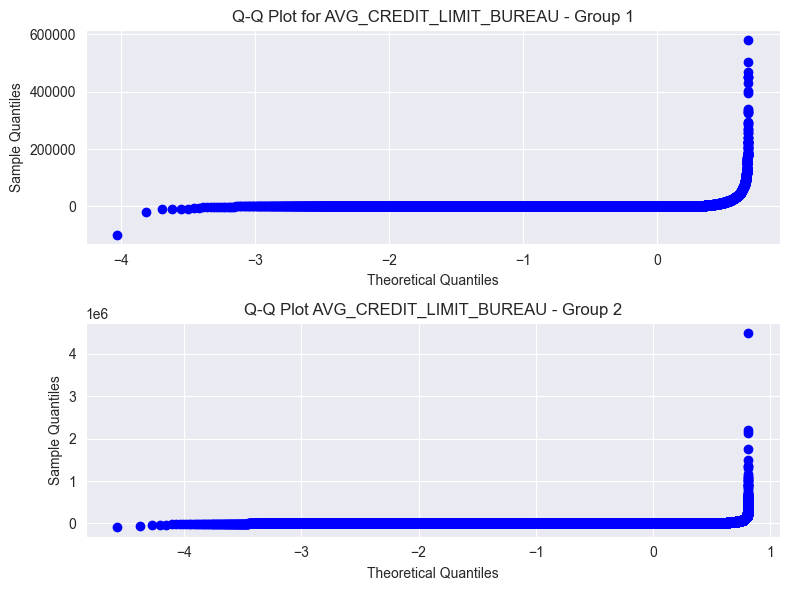

<IPython.core.display.Javascript object>

In [385]:
for col in selected_app_train_num_cols:
    hf.test_two_sample_ttest_assumptions(problematic_loans, fully_paid_loans, col)

In [387]:
significant_cols = []

for col in selected_app_train_num_cols:
    U_statistic, p_value = mannwhitneyu(problematic_loans[col], 
                                        fully_paid_loans[col], 
                                        alternative='two-sided')
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis: There is a significant difference in {col} medians between the two groups.")
        significant_cols.append(col)
    else:
        print(f"Fail to reject the null hypothesis: There is no significant difference in {col} medians between the two groups.")
    print("-"*50)

Fail to reject the null hypothesis: There is no significant difference in AMT_REQ_CREDIT_BUREAU_MON medians between the two groups.
--------------------------------------------------
Fail to reject the null hypothesis: There is no significant difference in YEARS_EMPLOYED medians between the two groups.
--------------------------------------------------
Fail to reject the null hypothesis: There is no significant difference in AVG_RATE_DOWN_PAYMENT medians between the two groups.
--------------------------------------------------
Fail to reject the null hypothesis: There is no significant difference in EXT_SOURCE_3 medians between the two groups.
--------------------------------------------------
Fail to reject the null hypothesis: There is no significant difference in YEARS_LAST_PHONE_CHANGE medians between the two groups.
--------------------------------------------------
Reject the null hypothesis: There is a significant difference in YEARS_ID_PUBLISH medians between the two groups.
-

<IPython.core.display.Javascript object>

In [388]:
significant_cols

['YEARS_ID_PUBLISH', 'AGE', 'AMT_CREDIT', 'REGION_RATING_CLIENT_W_CITY']

<IPython.core.display.Javascript object>

## 2.2. Confidence intervals

##### Main insights and observations:
- The 95% confidence interval for people who have fully paid their loan:
    - YEARS_ID_PUBLISH: 8.24-8.27 (as opposed to 7.43-7.53 for problematic applications)
    - AGE: 44.14-44.23 (as opposed to 40.6-40.89 for problematic applications)
    - AMT_CREDIT: 601151.16-604150.77 (as opposed to 553469.06-562087.99 for problematic applications)
    - REGION_RATING_CLIENT_W_CITY: 2.02 (as opposed to 2.12-2.14 for problematic applications)

In [393]:
print(f"95% confidence interval for YEARS_ID_PUBLISH of people who've fully paid their loan:")
print(sm.stats.DescrStatsW(fully_paid_loans['YEARS_ID_PUBLISH']).zconfint_mean())
print(f"95% confidence interval for YEARS_ID_PUBLISH of people who've not paid back their loan fully:")
print(sm.stats.DescrStatsW(problematic_loans['YEARS_ID_PUBLISH']).zconfint_mean())
print("-"*30)
print(f"95% confidence interval for AGE of people who've fully paid their loan:")
print(sm.stats.DescrStatsW(fully_paid_loans['AGE']).zconfint_mean())
print(f"95% confidence interval for AGE of people who've not paid back their loan fully:")
print(sm.stats.DescrStatsW(problematic_loans['AGE']).zconfint_mean())
print("-"*30)
print(f"95% confidence interval for AMT_CREDIT of people who've fully paid their loan:")
print(sm.stats.DescrStatsW(fully_paid_loans['AMT_CREDIT']).zconfint_mean())
print(f"95% confidence interval for AMT_CREDIT of people who've not paid back their loan fully:")
print(sm.stats.DescrStatsW(problematic_loans['AMT_CREDIT']).zconfint_mean())
print("-"*30)
print(f"95% confidence interval for REGION_RATING_CLIENT_W_CITY of people who've fully paid their loan:")
print(sm.stats.DescrStatsW(fully_paid_loans['REGION_RATING_CLIENT_W_CITY']).zconfint_mean())
print(f"95% confidence interval for REGION_RATING_CLIENT_W_CITY of people who've not paid back their loan fully:")
print(sm.stats.DescrStatsW(problematic_loans['REGION_RATING_CLIENT_W_CITY']).zconfint_mean())

95% confidence interval for YEARS_ID_PUBLISH of people who've fully paid their loan:
(8.245487445845331, 8.275899351947231)
95% confidence interval for YEARS_ID_PUBLISH of people who've not paid back their loan fully:
(7.428421582579053, 7.531750018629407)
------------------------------
95% confidence interval for AGE of people who've fully paid their loan:
(44.14005459922856, 44.22814831572826)
95% confidence interval for AGE of people who've not paid back their loan fully:
(40.609662140445735, 40.89525789983624)
------------------------------
95% confidence interval for AMT_CREDIT of people who've fully paid their loan:
(601151.1621029493, 604150.76761263)
95% confidence interval for AMT_CREDIT of people who've not paid back their loan fully:
(553469.0661003938, 562087.9892470381)
------------------------------
95% confidence interval for REGION_RATING_CLIENT_W_CITY of people who've fully paid their loan:
(2.0205954099926924, 2.0242963403964405)
95% confidence interval for REGION_RAT

<IPython.core.display.Javascript object>

# 3. Conclusions and Further Analysis

## Main insights and observations:
- There distribution of classes in the target feature is imbalanced. There are around 8% of observations with problematic loans.
- Most of the loans are cash loans.
- There are around twice female applicants more than male applicants in this dataset. The share of defaulted loans is higher among male applicants.
- The majority of applicants are unaccompanied or accompanied by family members/spouses.
- The majority of applicants are married or single. The least amount of applicants are separated or widowed.
- The majority of applicants own real estate. There seems to be no significant association between the realty ownership and the loan status.
- The majority of applicants are working, are commercial associates or pensioners. There are very few applicants who are students, unemployed, businessmen, or are on maternity leave.
- The most popular education levels among the applicants are Secondary/secondary special and higher education.
- The majority of applicants haven't specified their occupation type. Among the ones who have specified this information, the majority of applicants are laborers, sales and care staff.
- Regarding the previous loans statuses, the applicants who have been refused a loan before, had higher share of problematic current loans.
- The majority of applicants live in medium-rated regions (based on Home Credit rating system). Applicants coming from regions with rating 3 have the highest share of problematic loans.
- Applicants with a higher income level seem to have a higher credit amount of the loan.
- Higher credit amount of the loan is seemingly associated with a higher annuity amount.
- Applicants from more populated regions seem to have a bit higher credit amount of the loan. 
- Most of the columns of interest seem to be not normally distributed. 
- The majority of the features have similar distributions for good and problematic loans. 
- Many applicants with problematic loans seems to be a bit younger.
- There is a significant association between the loan status and AMT_ANNUITY_BIN, CODE_GENDER, FLAG_PHONE, NAME_INCOME_TYPE, LAST_BURR_CREDIT_STATUS, NAME_TYPE_SUITE, LAST_CONTRACT_STATUS, OCCUPATION_TYPE, FLAG_OWN_CAR, FLAG_DOCUMENT_3, NAME_EDUCATION_TYPE, FLAG_WORK_PHONE, REG_CITY_NOT_LIVE_CITY.
- The median values of YEARS_ID_PUBLISH, AGE, AMT_CREDIT, REGION_RATING_CLIENT_W_CITY are significantly different between fully paid loan applications and problematic loan applications.
- The 95% confidence interval for people who have fully paid their loan:
    - YEARS_ID_PUBLISH: 8.24-8.27 (as opposed to 7.43-7.53 for problematic applications)
    - AGE: 44.14-44.23 (as opposed to 40.6-40.89 for problematic applications)
    - AMT_CREDIT: 601151.16-604150.77 (as opposed to 553469.06-562087.99 for problematic applications)
    - REGION_RATING_CLIENT_W_CITY: 2.02 (as opposed to 2.12-2.14 for problematic applications)
  
## Recommendations:
- Data selection should be performed with a domain expert to ensure the highest quality of ML models.

## Further Analysis: 
- Feedback from domain experts should be collected regarding the feature selection part and model performance. The models should be updated fairly regularly since some of the values may change in future (like annual income or loan amounts requested).